In [1]:
%%capture
!pip install linearmodels

In [6]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

import graphviz as gr
import cvxpy as cp

from linearmodels.datasets import wage_panel

from linearmodels.panel import PanelOLS

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

%matplotlib inline

In [8]:
from toolz import *
import toolz as f
from toolz import curry

from scipy.special import expit

import warnings
warnings.filterwarnings("ignore")

In [4]:
style.available

style.use("ggplot")

# style.use("bmh")

In [78]:
plt.rcParams['font.size'] = 7
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['legend.fontsize'] = 7
plt.rcParams["lines.markersize"] = 4
plt.rcParams['lines.linewidth'] = 1.1

# 1 - Difference-in-Differences

## Three Billboards in the South of Brazil

I remember when I worked with marketing and a great way to do it was with internet advertisement. Not because it is very efficient (although it is), but because it is very easy to know if it's effective or not. With online marketing, you have a way of knowing which customers saw the ad and you can track them with cookies to see if they ended up on your landing page or clicked some download button. You can also use machine learning to find prospects that are very similar to your customers and present the ad only to them. In this sense, online marketing is very precise: you target only those you want to and you can see if they respond as you would like them to.

But not everyone is susceptible to online marketing. Sometimes you have to resort to less precise techniques, like a TV campaign or placing a billboard down the street. Usually, diversity of marketing channels is something marketing departments look for. But if online marketing is a professional fishing rod to catch that specific type of tuna, billboard and TV are giant nets you throw at a fish shoal and hope to catch at least some big ones. Another problem with billboard and TV ads is that it is much harder to know how effective they are. Sure, you could measure the purchase volume, or whatever you want to drive, before and after placing a billboard somewhere. If there is an increase, there is some evidence that the marketing is effective. But how would you know if this increase is not just some natural trend in the awareness of your product? In other words, how would you know the counterfactual $Y_0$ of what would have happened if you didn't set up the billboards in the first place?

One technique to answer these types of questions is Difference-in-Difference, or diff-in-diff for close friends. Diff-in-diff is commonly used to assess the effect of macro interventions, like the effect of immigration on unemployment, the effect of gun law changes in crime rates or simply the difference in user engagement due to a marketing campaign. In all these cases, you have a period before and after the intervention and you wish to untangle the impact of the intervention from a general trend. As a motivating example, let's look at a question similar to the one I had to answer.

In order to figure out how good billboards were as a marketing channel, we placed 3 billboards in the city of Porto Alegre, the capital of the state of Rio Grande do Sul. We wanted to see if that boosted deposits into our savings account. As a note for those not very familiar with Brazilian geography, Rio Grande do Sul is part of the south of the country, one of the most developed regions.

Having this in mind, we decided to also look at data from another capital from the south, Florianopolis, the capital city of the state of Santa Catarina. The idea is that we could use Florianopolis as a control sample to estimate the counterfactual $Y_0$ when compared to Porto Alegre (by the way, this was not the true experiment, which is confidential, but the idea is very similar). We placed the billboard in Porto Alegre for the entire month of June. The data we have looks like this:

In [ ]:
data = pd.read_csv("./data/billboard_impact.csv")
data.head()

,deposits,poa,jul
0,42,1,0
1,0,1,0
2,52,1,0
3,119,1,0
4,21,1,0


In [ ]:
data.shape

(4600, 3)

In [ ]:
data[data["poa"]==1]

,deposits,poa,jul
0,42,1,0
1,0,1,0
2,52,1,0
3,119,1,0
4,21,1,0
...,...,...,...
1295,99,1,1
1296,159,1,1
1297,74,1,1
1298,0,1,1


Remember that deposits are our outcome variable, the one we wish to increase with the billboards. POA is a dummy indicator for the city of Porto Alegre. When it is zero, it means the samples are from Florianopolis. Jul is a dummy for the month of July, or for the post intervention period. When it is zero it refers to samples from May, the pre-intervention period.

## DID Estimator

To avoid confusion between Time and Treatment, from now on, I'll use D to denote treatment and T to denote time. Let $Y_D(T)$ be the potential outcome for treatment D on period T. In an ideal world where we have the ability to observe the counterfactual, we would estimate the treatment effect of an intervention the following way:

$
\hat{ATET} = E[Y_1(1) - Y_0(1)|D=1]
$

In words, the causal effect is the outcome in the period post intervention in case of a treatment minus the outcome in also in the period after the intervention, but in the case of no treatment. Of course, we can't measure this because $Y_0(1)$ is counterfactual.

One way around this is a before and after comparison.

$
\hat{ATET} = E[Y(1)|D=1] - E[Y(0)|D=1]
$

In our example, we would compare the average deposits from POA before and after the billboard was placed.

In [ ]:
poa_before = data.query("poa==1 & jul==0")["deposits"].mean()

poa_after = data.query("poa==1 & jul==1")["deposits"].mean()

poa_after - poa_before

np.float64(41.04775)

This estimator is telling us that we should expect deposits to increase R$ 41,04 after the intervention. But can we trust this?

Notice that $E[Y(0)|D=1]=E[Y_0(0)|D=1]$, that is, the observed outcome for the treated unit **before the intervention** is equal to the counterfactual outcome for the treated unit also before the intervention. Since we are using this to estimate the counterfactual **after the intervention**  $E[Y_0(1)|D=1]$, this estimation above assumes that $E[Y_0(1)|D=1] = E[Y_0(0)|D=1]$.

It is saying that in the case of no intervention, the outcome in the latter period would be the same as the outcome from the starting period. This would obviously be false if your outcome variable follows any kind of trend. For example, if deposits are going up in POA, $E[Y_0(1)|D=1] > E[Y_0(0)|D=1]$, i.e. the outcome of the latter period would be greater than that of the starting period even in the absence of the intervention. With a similar argument, if the trend in Y is going down, $E[Y_0(1)|D=1] < E[Y_0(0)|D=1]$. This is to show that this before and after thing is not a great estimator.

Another idea is to compare the treated group with an untreated group that didn't get the intervention:

$
\hat{ATET} = E[Y(1)|D=1] - E[Y(1)|D=0]
$

In our example, it would be to compare the deposits from POA to that of Florianopolis in the post intervention period.

In [ ]:
fl_after = data.query("poa==0 & jul==1")["deposits"].mean()

poa_after - fl_after

np.float64(-119.10175000000001)

This estimator is telling us that the campaign is detrimental and that customers will decrease deposits by R$ 119.10.

Notice that $E[Y(1)|D=0]=E[Y_0(1)|D=0]$. And since we are using $E[Y(1)|D=0]$ to estimate the counterfactual for the treated after the intervention, we are assuming we can replace the missing counterfactual like this: $E[Y_0(1)|D=0] = E[Y_0(1)|D=1]$. But notice that this would only be true if both groups have a very similar baseline level. For instance, if Florianopolis has way more deposits than Porto Alegre, this would not be true because $E[Y_0(1)|D=0] > E[Y_0(1)|D=1]$. On the other hand, if the level of deposits are lower in Florianopolis, we would have $E[Y_0(1)|D=0] < E[Y_0(1)|D=1]$.

Again, this is not a great idea. To solve this, we can use both space and time comparison. This is the idea of the difference in difference approach. It works by replacing the missing counterfactual the following way:

$
E[Y_0(1)|D=1] = E[Y_0(0)|D=1] + (E[Y_0(1)|D=0] - E[Y_0(0)|D=0])
$

What this does is take the treated unit **before the intervention** and adds a trend component to it, which is estimated using the control $E[Y_0(1)|D=0] - E[Y_0(0)|D=0]$. In words, it is saying that the treated **after the intervention**, had it not been treated, would look like the **treated before the treatment** plus a growth factor that is the same as the growth of the control.

It is important to notice that this assumes that the trends in the treatment and control are the same:

$
E[Y_0(1) − Y_0(0)|D=1] = E[Y_0(1) − Y_0(0)|D=0]
$

where the left hand side is the counterfactual trend. Now, we can replace the estimated counterfactual in the treatment effect definition $E[Y_1(1)|D=1] - E[Y_0(1)|D=1]$

$
\hat{ATET} = E[Y(1)|D=1] - (E[Y(0)|D=1] + (E[Y(1)|D=0] - E[Y(0)|D=0])
$

If we rearrange the terms, we get the classical Diff-in-Diff estimator.

$
\hat{ATET} = (E[Y(1)|D=1] - E[Y(1)|D=0]) - (E[Y(0)|D=1] - E[Y(0)|D=0])
$

It gets that name because it gets the difference between the difference between treatment and control after and before the treatment.

Here is what that looks in code.

In [ ]:
fl_before = data.query("poa==0 & jul==0")["deposits"].mean()

diff_in_diff = (poa_after-poa_before)-(fl_after-fl_before)

diff_in_diff

np.float64(6.524557692307688)

Diff-in-Diff is telling us that we should expect deposits to increase by R$ 6.52 per customer. Notice that the assumption that diff-in-diff makes is much more plausible than the other 2 estimators. It just assumes that the growth pattern between the 2 cities are the same. But it doesn't require them to have the same base level nor does it require the trend to be zero.

To visualize what diff-in-diff is doing, we can project the growth trend from the untreated into the treated to see the counterfactual, that is, the number of deposits we should expect if there were no intervention.

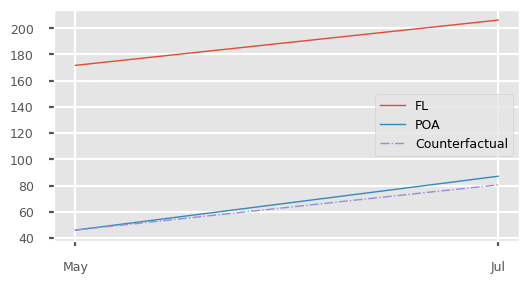

In [ ]:
plt.figure(figsize=(6, 3))

plt.plot(["May", "Jul"], [fl_before, fl_after], label="FL", lw=1)
plt.plot(["May", "Jul"], [poa_before, poa_after], label="POA", lw=1)

plt.plot(["May", "Jul"], [poa_before, poa_before+(fl_after-fl_before)], label="Counterfactual", lw=1, color="C2", ls="-.")

plt.legend();

See that small difference between the red and the yellow dashed lines? If you really focus you can see the small treatment effect on Porto Alegre.

Now, what you might be asking yourself is "how much can I trust this estimator? It is my right to have standard errors reported to me!". Which makes sense, since estimators without them look silly. To do so, we will use a neat trick that uses regression. Specifically, we will estimate the following linear model

$
Y_i = \beta_0 + \beta_1 POA_i + \beta_2 Jul_i + \beta_3 POA_i*Jul_i + e_i
$

Notice that $\beta_0$ is the baseline of the control. In our case, is the level of deposits in Florianopolis in the month of May. If we turn on the treated city dummy, we get $\beta_1$. So $\beta_0 + \beta_1$ is the baseline of Porto Alegre in May, before the intervention, and $\beta_1$ is the increase of Porto Alegre baseline on top of Florianopolis. If we turn the POA dummy off and turn the July dummy on, we get $\beta_0 + \beta_2$, which is the level of Florianópolis in July, after the intervention period. $\beta_2$ is then the trend of the control, since we add it on top of the baseline to get the level of the control at the period post intervention. As a recap, $\beta_1$ is the increment we get by going from the control to the treated, $\beta_2$ is the increment we get by going from the period before to the period after the intervention. Finally, if we turn both dummies on, we get $\beta_3$. $\beta_0 + \beta_1 + \beta_2 + \beta_3$ is the level in Porto Alegre after the intervention. So $\beta_3$ is the incremental impact when you go from May to July and from Florianopolis to POA. In other words, it is the Difference in Difference estimator.

If you don't believe me, check for yourself. You should get the exact same number we got above. And also notice how we get our much wanted standard errors.

In [ ]:
smf.ols("deposits ~ poa*jul", data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,171.6423,2.363,72.625,0.000,167.009,176.276
poa,-125.6263,4.484,-28.015,0.000,-134.418,-116.835
jul,34.5232,3.036,11.372,0.000,28.571,40.475
poa:jul,6.5246,5.729,1.139,0.255,-4.706,17.755


## Non Parallel Trends

One obvious problem with Diff-in-Diff is failure to satisfy the parallel trend assumption. If the growth trend from the treated is different from the trend of the control, diff-in-diff will be biased. This is a common problem with non-random data, where the decision to treat a region is based on its potential to respond well to the treatment, or when the treatment is targeted at regions that are not performing very well. Take our marketing example. We decided to test billboards in Porto Alegre not in order to check the effect of billboards in general. The reason is simply because sales perform poorly there. Perhaps online marketing is not working there. In this case, it could be that the growth we would see in Porto Alegre without a billboard would be lower than the growth we observe in other cities. This would cause us to underestimate the effect of the billboard there.

One way to check if this is happening is to plot the trend using past periods. For example, let's suppose POA had a small decreasing trend but Florianopolis was on a steep ascent. In this case, showing periods from before would reveal those trends and we would know Diff-in-Diff is not a reliable estimator.

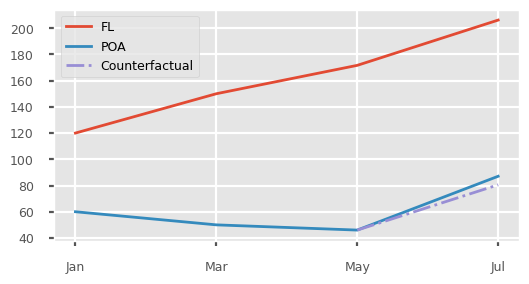

In [ ]:
plt.figure(figsize=(6,3))
x = ["Jan", "Mar", "May", "Jul"]

plt.plot(x, [120, 150, fl_before,  fl_after], label="FL", lw=2)
plt.plot(x, [60, 50, poa_before, poa_after], label="POA", lw=2)

plt.plot(["May", "Jul"], [poa_before, poa_before+(fl_after-fl_before)], label="Counterfactual", lw=2, color="C2", ls="-.")

plt.legend();

We will see how to solve this problem with synthetic control. It will use multiple cities to create a synthetic city that closely follows the trend of the city of interest. But for now, remember that you always need to check if you have parallel trends when applying diff-in-diff.

One final issue that it's worth mentioning is that you won't be able to place confidence intervals around your Diff-in-Diff estimator if you only have aggregated data. Say for instance you don't have data on what each of our customers from Florianópolis or Porto Alegre did. Instead, you only have the average deposits before and after the intervention for both cities. In this case, you will still be able to estimate the causal effect by Diff-in-Diff, but you won't know the variance of it. That's because all the variability in your data got squashed out in aggregation.

## Key Ideas

We've explored a technique widely applied when we are estimating causal effects at more macro entities (schools, cities, states, countries...). Difference in Difference takes a treated unit before and after the treatment and compares the trend in the outcome to that of a control unit. Here, we've seen how this could be applied at estimating the effect of a city specific marketing campaign.

Finally, we looked at how Diff-in-Diff fails if the trend between the treated and control unit is not the same. We also saw how diff-in-diff will be problematic if we only have aggregated data.


# 2 - Panel Data and Fixed Effects

In the previous chapter, we explored a very simple Diff-in-Diff setup, where we had a treated and a control group (the city of POA and FLN, respectively) and only two periods, a pre-intervention and a post-intervention period. But what would happen if we had more periods? Or more groups? Turns out this setup is so common and powerful for causal inference that it gets its own name: panel data. A panel is when we have repeated observations of the same unit over multiple periods of time. This happens a lot in government policy evaluation, where we can track data on multiple cities or states over multiple years. But it is also incredibly common in the industry, where companies track user data over multiple weeks and months.

To understand how we can leverage such data structure, let's first continue with our diff-in-diff example, where we wanted to estimate the impact of placing a billboard (treatment) in the city of Porto Alegre (POA). We want to see if that sort of offline marketing strategy can boost the usage of our investment products. Specifically, we want to know how much deposits in our investments account would increase if we placed billboards.

In the previous chapter, we've motivated the DiD estimator as an imputation strategy of what would have happened to Porto Alegre had we not placed the billboards in it. We said that the counterfactual outcome $Y_0$ for Porto Alegre **after the intervention** (placing a billboard) could be inputted as the number of deposits in Porto Alegre **before the intervention** plus a growth factor. This growth factor was estimated in a control city, Florianopolis (FLN). Just so we can recap some notation, here is how we can estimate this counterfactual outcome

$$
\underbrace{\widehat{Y_0(1)|D=1}}_{\substack{\text{POA outcome after intervention}} \\ \substack{\text{if no intervention had taken place}}}
= \underbrace{Y_0(0)|D=1}_{\substack{\text{POA outcome}} \\ \substack{\text{before intervention}}}
+ \big( \underbrace{Y_0(1)|D=0}_{\substack{\text{FLN outcome after}} \\ \substack{\text{intervention in POA}}}
- \underbrace{Y_0(0)|D=0}_{\substack{\text{FLN outcome before}} \\ \substack{\text{intervention in POA}}} \big)
$$

where $t$ denotes time, $D$ denotes the treatment (since $t$ is taken), $Y_D(t)$ denote the potential outcome for treatment $D$ in period $t$ (for example, $Y_0(1)$ is the outcome under the control in period 1). Now, if we take that imputed potential outcome, we can recover the treatment effect for POA (ATT) as follows

$$
\widehat{ATT} = \underbrace{Y_1(1)|D=1}_{\substack{\text{POA outcome} \\ \text{after intervention}}} - \widehat{Y_0(1)|D=1}
$$

In other words, the effect of placing a billboard in POA is the outcome we saw on POA after placing the billboard minus our estimate of what would have happened if we hadn't placed the billboard. Also, recall that the power of DiD comes from the fact that estimating the mentioned counterfactual only requires that the growth deposits in POA matches the growth in deposits in FLW. This is the key parallel trends assumption. We should definitely spend some time on it because it is going to become very important later on.


## Parallel Trends

One way to see the parallel (or common) trends assumptions is as an independence assumption. If we recall from very early chapters, the independence assumption requires that the treatment assignment is independent from the potential outcomes:

$$
Y_d \perp  D
$$

This means we don't give more treatment to units with higher outcome (which would cause upward bias in the effect estimation) or lower outcome (which would cause downward bias). In less abstract terms, back to our example, let's say that your marketing manager decides to add billboards only to cities that already have very high deposits. That way, he or she can later boast that cities with billboards generate more deposties, so of course the marketing campaign was a success. Setting aside the moral discussion here, I think you can see that this violates the independence assumption: we are giving the treatment to cities with high $Y_0$. Also, remember that a natural extension of this assumption is the conditional independence assumption, which allows the potential outcomes to be dependent on the treatment at first, but independent once we condition on the confounders $X$

$
Y_d \perp D | X
$


You know all of this already. But how exactly does this tie back to DiD and the parallel trends assumption? If the traditional independence assumption states that the treatment assignment can't be related to **the levels** of potential outcomes, the parallel trends states that the treatment assignment can't be related to **the growth** in potential outcomes over time. In fact, one way to write the parallel trends assumption is as follows

$
\big(Y_d(t) - Y_d(t-1) \big)  \perp D
$


In less mathematical terms, this assumption is saying it is fine that we assign the treatment to units that have a higher or lower level of the outcome. What we can't do is assign the treatment to units based on how the outcome is growing. In out billboard example, this means it is OK to place billboards only in cities with originally high deposits level. What we can't do is place billboards only in cities where the deposits are growing the most. That makes a lot of sense if we remember that DiD is inputting the counterfactual growth in the treated unit with the growth in the control unit. If growth in the treated unit under the control is different than the growth in the control unit, then we are in trouble.

## Controlling What you Cannot See

Methods like propensity score, linear regression and matching are very good at controlling for confounding in non-random data, but they rely on a key assumption: conditional unconfoundedness

$
(Y_0, Y_1) \perp T | X
$

To put it in words, they require that all the confounders are known and measured, so that we can condition on them and make the treatment as good as random. One major issue with this is that sometimes we simply can't measure a confounder. For instance, take a classical labor economics problem of figuring out the impact of marriage on men's earnings. It's a well known fact in economics that married men earn more than single men. However, it is not clear if this relationship is causal or not. It could be that more educated men are both more likely to marry and more likely to have a high earnings job, which would mean that education is a confounder of the effect of marriage on earnings. For this confounder, we could measure the education of the person in the study and run a regression controlling for that. But another confounder could be beauty. It could be that more handsome men are both more likely to get married and more likely to have a high paying job. Unfortunately, beauty is one of those characteristics like intelligence. It's something we can't measure very well.  

This puts us in a difficult situation, because if we have unmeasured confounders, we have bias. One way to deal with this is with instrumental variables, as we've seen before. But coming up with good instruments it's no easy task and requires a lot of creativity. Here, instead let's take advantage of our panel data structure.

We've already seen how panel data allows us to replace the unconfoundedness assumption with the parallel trends assumption. But how exactly does this help with unmeasured confounders? First, let's take a look at the causal graph which represents this setup where we have repeated observations across time. Here, we track the same observation across 4 time periods. Marriage (the treatment) and Income (the outcome) change over time. Specifically, marriage turns on (from 0 to 1) at period 3 and 4 and income increases in the same periods. Beauty, the unmeasured confounder, is the same across all periods (a bold statement, but reasonable if time is just a few years). So, how can we know that the reason income increases is because of marriage and not simply due to an increase in the beauty confounder? And, more importantly, how can we control that confounder we cannot see?



The trick is to see that, by zooming in a unit and tracking how it evolves over time, we are already controlling for anything that is fixed over time. That includes any time fixed unmeasured confounders. In the graph above, for instance, we can already know that the increase in income over time cannot be due to an increase in beauty, simply because beauty stays the same (it is time fixed after all). The bottom line is that even though we cannot control for beauty, since we can't measure it, we can still use the panel structure so it is not a problem anymore.

Another way of seeing this is to think about these time fixed confounders as attributes that are specific to each unit. This would be equivalent to adding an intermediary unit node to our causal graph. Now, notice how controlling for the unit itself already blocks the backdoor path between the outcome and any of the unobserved but time fixed confounders.



Think about it. We can't measure attributes like beauty and intelligence, but we know that the person who has them is the same individual across time. The mechanics of actually doing this control is very simple. All we need to do is create dummy variables indicating that person and add that to a linear model. This is what we mean when we say we can control for the person itself: we are adding a variable (dummy in this case) that denotes that particular person. When estimating the effect of marriage on income with this person dummy in our model, regression finds the effect of marriage **while keeping the person variable fixed**. Adding this unit dummy is what we call a fixed effect model.

## Fixed Effects

To make matters more formal, let's first take a look at the data that we have. Following our example, we will try to estimate the effect of marriage on income. Our data contains those 2 variables, `married` and `lwage`, on multiple individuals (`nr`) for multiple years. Notice that wage is in log form. In addition to this, we have other controls, like number of hours worked that year, years of education and so on.

In [ ]:
data = wage_panel.load()

data.head()

,nr,year,black,exper,hisp,hours,married,educ,union,lwage,expersq,occupation
0,13,1980,0,1,0,2672,0,14,0,1.197540,1,9
1,13,1981,0,2,0,2320,0,14,1,1.853060,4,9
2,13,1982,0,3,0,2940,0,14,0,1.344462,9,9
3,13,1983,0,4,0,2960,0,14,0,1.433213,16,9
4,13,1984,0,5,0,3071,0,14,0,1.568125,25,5


In [ ]:
data[data.nr==13]

,nr,year,black,exper,hisp,hours,married,educ,union,lwage,expersq,occupation
0,13,1980,0,1,0,2672,0,14,0,1.197540,1,9
1,13,1981,0,2,0,2320,0,14,1,1.853060,4,9
2,13,1982,0,3,0,2940,0,14,0,1.344462,9,9
3,13,1983,0,4,0,2960,0,14,0,1.433213,16,9
4,13,1984,0,5,0,3071,0,14,0,1.568125,25,5
5,13,1985,0,6,0,2864,0,14,0,1.699891,36,2
6,13,1986,0,7,0,2994,0,14,0,-0.720263,49,2
7,13,1987,0,8,0,2640,0,14,0,1.669188,64,2


In [ ]:
data[data.nr==17]

,nr,year,black,exper,hisp,hours,married,educ,union,lwage,expersq,occupation
8,17,1980,0,4,0,2484,0,13,0,1.675962,16,2
9,17,1981,0,5,0,2804,0,13,0,1.518398,25,2
10,17,1982,0,6,0,2530,0,13,0,1.559191,36,2
11,17,1983,0,7,0,2340,0,13,0,1.725410,49,2
12,17,1984,0,8,0,2486,0,13,0,1.622022,64,2
13,17,1985,0,9,0,2164,0,13,0,1.608588,81,7
14,17,1986,0,10,0,2749,0,13,0,1.572385,100,7
15,17,1987,0,11,0,2476,0,13,0,1.820334,121,5


Generally, the fixed effect model is defined as

$
y_{it} = \beta X_{it} + \gamma U_i + e_{it}
$

where $y_{it}$ is the outcome of individual $i$ at time $t$, $X_{it}$ is the vector of variables for individual $i$ at time $t$. $U_i$ is a set of unobservables for individual $i$. Notice that those unobservables are unchanging through time, hence the lack of the time subscript. Finally,  $e_{it}$ is the error term. For the education example, $y_{it}$ is log wages,  $X_{it}$ are the observable variables that change in time, like marriage and experience and $U_i$ are the variables that are not observed but constant for each individual, like beauty and intelligence.


Now, remember how I've said that using panel data with a fixed effect model is as simple as adding a dummy for the entities. It's true, but in practice, we don't actually do it. Imagine a dataset where we have 1 million customers. If we add one dummy for each of them, we would end up with 1 million columns, which is probably not a good idea. Instead, we use the trick of partitioning the linear regression into 2 separate models. We've seen this before, but now is a good time to recap it. Suppose you have a linear regression model with a set of features $X_1$ and another set of features $X_2$.

$
\hat{Y} = \hat{\beta_1} X_1 + \hat{\beta_2} X_2
$

where $X_1$ and $X_2$ are feature matrices (one row per feature and one column per observation) and $\hat{\beta_1}$ and $\hat{\beta_2}$ are row vectors. You can get the exact same $\hat{\beta_1}$ parameter by doing

1. regress the outcome $y$ on the second set of features $\hat{y^*} = \hat{\gamma_1} X_2$
2. regress the first set of features on the second $\hat{X_1} = \hat{\gamma_2} X_2$
3. obtain the residuals $\tilde{X}_1 = X_1 - \hat{X_1}$ and $\tilde{y}_1 = y_1 - \hat{y^*}$
4. regress the residuals of the outcome on the residuals of the features $\hat{y} = \hat{\beta_1} \tilde{X}_1$

The parameter from this last regression will be exactly the same as running the regression with all the features. But how exactly does this help us? Well, we can break the estimation of the model with the entity dummies into 2. First, we use the dummies to predict the outcome and the feature. These are steps 1 and 2 above.

Now, remember how running a regression on a dummy variable is as simple as estimating the mean for that dummy? If you don't, let's use our data to show how this is true. Let's run a model where we predict wages as a function of the year dummy.

In [ ]:
mod = smf.ols("lwage ~ C(year)", data=data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.3935,0.022,63.462,0.000,1.350,1.437
C(year)[T.1981],0.1194,0.031,3.845,0.000,0.059,0.180
C(year)[T.1982],0.1782,0.031,5.738,0.000,0.117,0.239
C(year)[T.1983],0.2258,0.031,7.271,0.000,0.165,0.287
C(year)[T.1984],0.2968,0.031,9.558,0.000,0.236,0.358
C(year)[T.1985],0.3459,0.031,11.140,0.000,0.285,0.407
C(year)[T.1986],0.4062,0.031,13.082,0.000,0.345,0.467
C(year)[T.1987],0.4730,0.031,15.232,0.000,0.412,0.534


Notice how this model is predicting the average income in 1980 to be 1.3935, in 1981 to be 1.5129 (1.3935+0.1194) and so on. Now, if we compute the average by year, we get the exact same result. (Remember that the base year, 1980, is the intercept. So you have to add the intercept to the parameters of the other years to get the mean `lwage` for the year).

In [ ]:
data.groupby("year")["lwage"].mean()

,lwage
year,
1980,1.393477
1981,1.512867
1982,1.571667
1983,1.619263
1984,1.690295
1985,1.739410
1986,1.799719
1987,1.866479


This means that if we get the average for every person in our panel, we are essentially regressing the individual dummy on the other variables. This motivates the following estimation procedure:

1. Create time-demeaned variables by subtracting the mean for the individual:   
$\ddot{Y}_{it} = Y_{it} -  \bar{Y}_i$  
$\ddot{X}_{it} = X_{it} -  \bar{X}_i$

2. Regress $\ddot{Y}_{it}$ on $\ddot{X}_{it}$


Notice that when we do so, the unobserved $U_i$ vanishes. Since $U_i$ is constant across time, we have that $\bar{U_i}=U_i$. If we have the following system of two equations

$$
\begin{align}
Y_{it} & = \beta X_{it} + \gamma U_i + e_{it} \\
\bar{Y}_{i} & = \beta \bar{X}_{it} + \gamma \bar{U}_i + \bar{e}_{it} \\
\end{align}
$$

And we subtract one from the other, we get

$$
\begin{align}
(Y_{it} - \bar{Y}_{i}) & = (\beta X_{it} - \beta \bar{X}_{it}) + (\gamma U_i - \gamma U_i) + (e_{it}-\bar{e}_{it}) \\
(Y_{it} - \bar{Y}_{i}) & = \beta(X_{it} - \bar{X}_{it}) + (e_{it}-\bar{e}_{it}) \\
\ddot{Y}_{it} & = \beta \ddot{X}_{it} + \ddot{e}_{it} \\
\end{align}
$$

which wipes out all unobserved that are constant across time. To be honest, not only do the unobserved variables vanish. This happens to all the variables that are constant in time. For this reason, you can't include any variables that are constant across time, as they would be a linear combination of the dummy variables and the model wouldn't run.


To check which variables are those, we can group our data by individual and get the sum of the standard deviations. If it is zero, it means the variable isn't changing across time for any of the individuals.

In [ ]:
data.groupby("nr").std().sum()

,0
year,1334.971910
black,0.000000
exper,1334.971910
hisp,0.000000
hours,203098.215649
married,140.372801
educ,0.000000
union,106.512445
lwage,173.929670
expersq,17608.242825


For our data, we need to remove ethnicity dummies, `black` and `hisp`, since they are constant for the individual. Also, we need to remove education. We will also not use occupation, since this is probably mediating the effect of marriage on wage (it could be that single men are able to take more time demanding positions). Having selected the features we will use, it's time to estimate this model.

To run our fixed effect model, first, let's get our mean data. We can achieve this by grouping everything by individuals and taking the mean.

In [ ]:
Y = "lwage"
T = "married"
X = [T, "expersq", "union", "hours"]

mean_data = data.groupby("nr")[X+[Y]].mean()
mean_data.head()

,married,expersq,union,hours,lwage
nr,,,,,
13,0.000,25.5,0.125,2807.625,1.255652
17,0.000,61.5,0.000,2504.125,1.637786
18,1.000,61.5,0.000,2350.500,2.034387
45,0.125,35.5,0.250,2225.875,1.773664
110,0.500,77.5,0.125,2108.000,2.055129


To demean the data, we need to set the index of the original data to be the individual identifier, `nr`. Then, we can simply subtract one data frame from the mean data frame.

In [ ]:
demeaned_data = (data.set_index("nr")[X+[Y]]
                 - mean_data)

demeaned_data.head()

,married,expersq,union,hours,lwage
nr,,,,,
13,0.0,-24.5,-0.125,-135.625,-0.058112
13,0.0,-21.5,0.875,-487.625,0.597408
13,0.0,-16.5,-0.125,132.375,0.088810
13,0.0,-9.5,-0.125,152.375,0.177561
13,0.0,-0.5,-0.125,263.375,0.312473


Finally, we can run our fixed effect model on the time-demeaned data.

In [ ]:
mod = smf.ols(f"{Y} ~ {'+'.join(X)}", data=demeaned_data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-6.852e-17,0.005,-1.35e-14,1.000,-0.010,0.010
married,0.1147,0.017,6.756,0.000,0.081,0.148
expersq,0.0040,0.000,21.958,0.000,0.004,0.004
union,0.0784,0.018,4.261,0.000,0.042,0.115
hours,-8.46e-05,1.25e-05,-6.744,0.000,-0.000,-6e-05


In [ ]:
mod = PanelOLS.from_formula("lwage ~ expersq+union+married+hours+EntityEffects",
                            data=data.set_index(["nr", "year"]))

result = mod.fit(cov_type="clustered", cluster_entity=True)
result.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
expersq,0.0040,0.0002,16.552,0.0000,0.0035,0.0044
union,0.0784,0.0236,3.3225,0.0009,0.0322,0.1247
married,0.1147,0.0220,5.2213,0.0000,0.0716,0.1577
hours,-8.46e-05,2.22e-05,-3.8105,0.0001,-0.0001,-4.107e-05


Notice how the parameter estimates are identical to the ones we've got with time-demeaned data. The only difference is that the standard errors are a bit larger. Now, compare this to the simple OLS model that doesn't take the time structure of the data into account. For this model, we add back the variables that are constant in time.

In [ ]:
mod = smf.ols("lwage ~ expersq+union+married+hours+black+hisp+educ", data=data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2654,0.065,4.103,0.000,0.139,0.392
expersq,0.0032,0.000,15.750,0.000,0.003,0.004
union,0.1829,0.017,10.598,0.000,0.149,0.217
married,0.1410,0.016,8.931,0.000,0.110,0.172
hours,-5.32e-05,1.34e-05,-3.978,0.000,-7.94e-05,-2.7e-05
black,-0.1347,0.024,-5.679,0.000,-0.181,-0.088
hisp,0.0132,0.021,0.632,0.528,-0.028,0.054
educ,0.1057,0.005,22.550,0.000,0.097,0.115


This model is saying that marriage increases the man's wage by 14%. A somewhat larger effect than the one we found with the fixed effect model. This suggests some omitted variable bias due to fixed individual factors, like intelligence and beauty, not being added to the model.

## Visualizing Fixed Effects

To expand our intuition about how fixed effect models work, let's diverge a little to another example. Suppose you work for a big tech company and you want to estimate the impact of a billboard marketing campaign on in-app purchase. When you look at data from the past, you see that the marketing department tends to spend more to place billboards on cities where the purchase level is lower. This makes sense right? They wouldn't need to do lots of advertisement if sales were skyrocketing. If you run a regression model on this data, it looks like higher cost in marketing leads to less in-app purchase, but only because marketing investments is biased towards low spending regions.

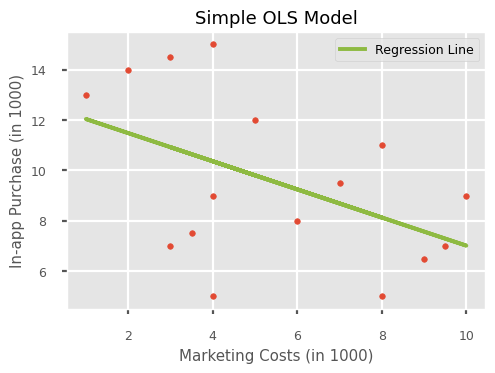

In [ ]:
plt.figure(figsize=(5.4, 3.6))

toy_panel = pd.DataFrame({
    "mkt_costs":[5,4,3.5,3, 10,9.5,9,8, 4,3,2,1, 8,7,6,4],
    "purchase":[12,9,7.5,7, 9,7,6.5,5, 15,14.5,14,13, 11,9.5,8,5],
    "city":["C0","C0","C0","C0", "C2","C2","C2","C2", "C1","C1","C1","C1", "C3","C3","C3","C3"]
})

m = smf.ols("purchase ~ mkt_costs", data=toy_panel).fit()

plt.scatter(toy_panel.mkt_costs, toy_panel.purchase)
plt.plot(toy_panel.mkt_costs, m.fittedvalues, c="C5", label="Regression Line")
plt.xlabel("Marketing Costs (in 1000)")
plt.ylabel("In-app Purchase (in 1000)")
plt.title("Simple OLS Model")
plt.legend();

Knowing a lot about causal inference, you decide to run a fixed effect model, adding the city's indicator as a dummy variable to your model. The fixed effect model controls for city specific characteristics that are constant in time, so if a city is less open to your product, it will capture that. When you run that model, you can finally see that more marketing costs leads to higher in-app purchase.

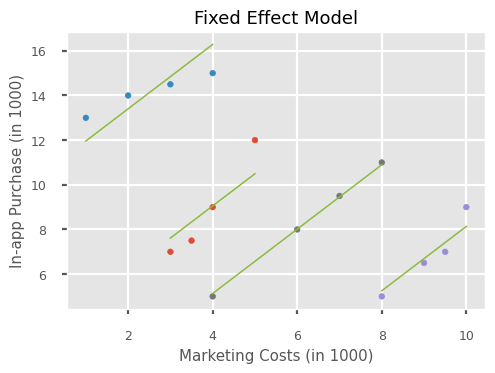

In [ ]:
plt.figure(figsize=(5.4, 3.6))

fe = smf.ols("purchase ~ mkt_costs + C(city)", data=toy_panel).fit()

fe_toy = toy_panel.assign(y_hat = fe.fittedvalues)

plt.scatter(toy_panel.mkt_costs, toy_panel.purchase, c=toy_panel.city)
for city in fe_toy["city"].unique():
    plot_df = fe_toy.query(f"city=='{city}'")
    plt.plot(plot_df.mkt_costs, plot_df.y_hat, c="C5", lw=1.1)

plt.title("Fixed Effect Model")
plt.xlabel("Marketing Costs (in 1000)")
plt.ylabel("In-app Purchase (in 1000)");

Take a minute to appreciate what the image above is telling you about what fixed effect is doing. Notice that fixed effect is fitting **one regression line per city**. Also notice that the lines are parallel. The slope of the line is the effect of marketing costs on in-app purchase. So the **fixed effect is assuming that the causal effect is constants across all entities**, which are cities in this case. This can be a weakness or an advantage, depending on how you see it. It is a weakness if you are interested in finding the causal effect per city. Since the FE model assumes this effect is constant across entities, you won't find any difference in the causal effect. However, if you want to find the overall impact of marketing on in-app purchase, the panel structure of the data is a very useful leverage that fixed effects can explore.

## Time Effects

Just like we did a fixed effect for the individual level, we could design a fixed effect for the time level. If adding a dummy for each individual controls for fixed individual characteristics, adding a time dummy would control for variables that are fixed for each time period, but that might change across time. One example of such a variable is inflation. Prices and salary tend to go up with time, but the inflation on each time period is the same for all entities. To give a more concrete example, suppose that marriage is increasing with time. If the wage and marriage proportion also changes with time, we would have time as a confounder. Since inflation also makes salary increase with time, some of the positive association we see between marriage and wage would be simply because both are increasing with time. To correct for that, we can add a dummy variable for each time period. In `linear models`, this is as simple as adding `TimeEffects` to our formula and setting the `cluster_time` to true.

In [ ]:
mod = PanelOLS.from_formula("lwage ~ expersq + union + married + hours + EntityEffects + TimeEffects",
                            data=data.set_index(["nr", "year"]))

result = mod.fit(cov_type="clustered", cluster_entity=True, cluster_time=True)
result.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
expersq,-0.0062,0.0008,-8.1479,0.0000,-0.0077,-0.0047
union,0.0727,0.0228,3.1858,0.0015,0.0279,0.1174
married,0.0476,0.0177,2.6906,0.0072,0.0129,0.0823
hours,-0.0001,3.546e-05,-3.8258,0.0001,-0.0002,-6.614e-05


In this new model, the effect of marriage on wage decreased significantly from `0.1147` to `0.0476`. Still, this result is significant at a 99% level, so man could still expect an increase in earnings from marriage.

## When Panel Data Won't Help You

Using panel data and fixed effects models is an extremely powerful tool for causal inference. When you don't have random data nor good instruments, the fixed effect is as convincing as it gets for causal inference with non experimental data. Still, it is worth mentioning that it is not a panacea. There are situations where even panel data won't help you.

The most obvious one is when you have confounders that are changing in time. Fixed effects can only eliminate bias from attributes that are constant for each individual. For instance, suppose that you can increase your intelligence level by reading books and eating lots of good fats. This causes you to get a higher paying job and a wife. Fixed effect won't be able to remove this bias due to unmeasured intelligence confounding because, in this example, intelligence is changing in time.


Another less obvious case when fixed effect fails is when you have **reversed causality**. For instance, let's say that it isn't marriage that causes you to earn more. Is earning more that increases your chances of getting married. In this case, it will appear that they have a positive correlation but earnings come first. They would change in time and in the same direction, so fixed effects wouldn't be able to control for that.


## Key Ideas

Here, we saw how to use panel data, data where we have multiple measurements of the same individuals across multiple time periods. When that is the case, we can use a fixed effect model that controls for the entity, holding all individual, time constant attributes, fixed. This is a powerful and very convincing way of controlling for confounding and it is as good as it gets with non random data.

Finally, we saw that FE is not a panacea. We saw two situations where it doesn't work: when we have reverse causality and when the unmeasured confounding is changing in time.




# 3 - Synthetic Control

## One Amazing Math Trick to Learn What can’t be Known

When we looked at difference-in-difference, we had data on multiple customers from 2 different cities: Porto Alegre and Florianopolis. The data span 2 different time periods: before and after a marketing intervention was done in Porto Alegre to boost customer deposits. To estimate the treatment effect, we ran a regression that gave us the difference-in-difference estimator and its standard error.

For that case, we had a lot of samples, because data was disaggregated. But what if all we have is aggregated data on the city level? For instance, let's pretend all we have is the average level of deposits in both cities before and after the intervention.

|city|before|after|
|--|--|--|
|FL|171.64|206.16|
|POA|46.01|87.06|

We would still be able to compute the Diff-in-Diff estimator

$
(E[Y(1)|D=1] - E[Y(1)|D=0]) - (E[Y(0)|D=1] - E[Y(0)|D=0]) = (87.06 - 206.16) - (46.01 - 171.64) = 6.53
$

However, note that the sample size here is 4, which is also the number of parameters in our Diff-in-Diff models. In this case, the standard error is not well defined, so what should we do? Another problem is that Florianopolis might not be as similar to Porto Alegre as we would want to. For instance, Florianopolis is known for its beautiful beaches and easy going people while Porto Alegre is more famous for its barbecue and prairies. The problem here is that you can't ever know for sure if you are using an appropriate control group.

To work around this, we will use what is known as [**"the most important innovation in the policy evaluation literature in the last few years"**](https://www.aeaweb.org/articles?id=10.1257/jep.31.2.3), Synthetic Controls. It is based on a simple, yet powerful idea. We don't need to find any single unit in the untreated that is very similar to the treated. Instead, we can forge our own as a combination of multiple untreated units, creating what is effectively a synthetic control. Synthetic control is so effective yet so intuitive that it even got an article published, not on a scientific journal, but on the [Washington Post](https://www.washingtonpost.com/news/wonk/wp/2015/10/30/how-to-measure-things-in-a-world-of-competing-claims/).

To see it in action, consider the problem of estimating the effect of cigarette taxation on its consumption. To give a bit of context, this is a question that had been debated for a long time in economics. One side of the argument says that taxes will increase the cost of cigars, which will lower its demand. The other side argues that since cigarettes cause addiction, change in their price won't change their demand by much. In economic terms, we would say that the demand for cigarettes is inelastic on price, and an increase in taxation is just a way to increase government income at the cost of smokers. To settle things, we will look at some US data regarding the matter.

In 1988, California passed a famous Tobacco Tax and Health Protection Act, which became known as [Proposition 99](https://en.wikipedia.org/wiki/1988_California_Proposition_99). "Its primary effect is to impose a 25-cent per pack state excise tax on the sale of tobacco cigarettes within California, with approximately equivalent excise taxes similarly imposed on the retail sale of other commercial tobacco products, such as cigars and chewing tobacco. Additional restrictions placed on the sale of tobacco include a ban on cigarette vending machines in public areas accessible by juveniles, and a ban on the individual sale of single cigarettes. Revenue generated by the act was earmarked for various environmental and health care programs, and anti-tobacco advertisements."

To evaluate its effect, we can gather data on cigarette sales from multiple states and across a number of years. In our case, we got data from the year 1970 to 2000 from 39 states. Other states had similar Tobacco control programs and were dropped from the analysis. Here is what our data looks like.

In [ ]:
cigar = (pd.read_csv("./data/smoking.csv").drop(columns=["lnincome", "beer", "age15to24"]))

cigar.query("california").head()

,state,year,cigsale,retprice,california,after_treatment
62,3,1970,123.000000,38.799999,True,False
63,3,1971,121.000000,39.700001,True,False
64,3,1972,123.500000,39.900002,True,False
65,3,1973,124.400002,39.900002,True,False
66,3,1974,126.699997,41.900002,True,False


We have `state` as the state index, where California is the number 3. Our covariates are `retprice`, the cigarette retail price, and `cigsale`, the per-capita sales of cigarettes in packs. Our outcome variable of interest is `cigsale`. Finally, we have boolean helper variables to signal the state of California and the post intervention period. If we plot the sales of cigarettes for California and other states across time, this is what we would get.

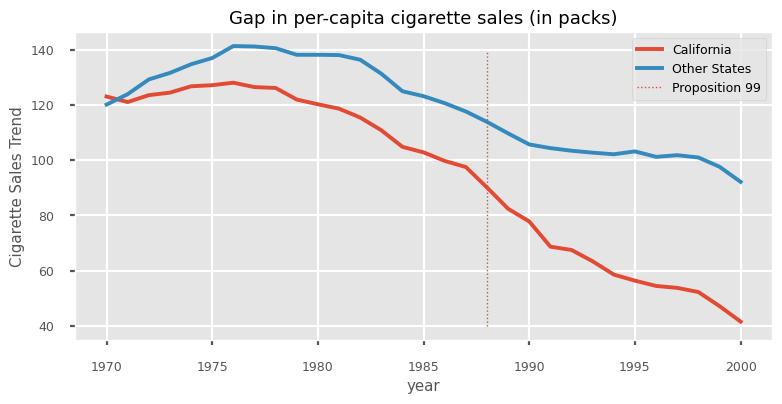

In [ ]:
ax = plt.subplot(1, 1, 1)

(cigar.assign(california = np.where(cigar["california"], "California", "Other States"))
        .groupby(["year", "california"])["cigsale"].mean()
        .reset_index()
        .pivot(index="year", columns="california",  values="cigsale")
        .plot(ax=ax, figsize=(9, 4)))

plt.vlines(x=1988, ymin=40, ymax=140, linestyles=":", lw=1, label="Proposition 99")
plt.ylabel("Cigarette Sales Trend")
plt.title("Gap in per-capita cigarette sales (in packs)")
plt.legend();

During the time for which we have data, people in California apparently bought less cigarettes than the national average. Also, it appears to be a decreasing movement in cigarette consumption after the 80s. It looks like after Proposition 99 the decreasing trend accelerated for California, compared to other states, but we can't say that for sure. It is just a guess that we have by examining the plot.

To answer the question of whether Proposition 99 had an effect on cigarette consumption, we will use the pre-intervention period to build a synthetic control. We will combine the other states to **build a fake state that resembles very closely the trend of California**. Then, we will see how this synthetic control behaves after the intervention.

## We have Time

To make matters a little bit more formal, suppose that we have $J+1$ units. Without loss of generality, assume that unit 1 is the unit that gets affected by an intervention. Units $j=2,...,J+1$ are a collection of untreated units that we will refer to as the "donor pool". Also assume that the data we have span T time periods, with $T_0$ periods before the intervention. For each unit j and each time t, we observe the outcome $Y_{jt}$. For each unit j and period t, define $Y^N_{jt}$ as the potential outcome without intervention and $Y^I_{jt}$, the potential outcome with intervention. Then, the effect for the treated unit $j=1$ at time t, for $t>T_0$ is defined as

$
\tau_{1t} = Y^I_{1t} - Y^N_{1t}
$

Since unit $j=1$ is the treated one, $Y^I_{1t}$ is factual but $Y^N_{1t}$ is not. The challenge then becomes how do we estimate $Y^N_{1t}$. Notice how the treatment effect is defined for each period, which means it can change in time. It doesn't need to be instantaneous. It can accumulate or dissipate. To put it in a picture, the problem of estimating the treatment effect boils down to the problem of **estimating what would have happened to the outcome of unit $j=1$ if it had not been treated**.



To estimate $Y^N_{1t}$, we remember that a combination of units in the donor pool may approximate the characteristics of the treated unit much better than any untreated unit alone. Thus, a synthetic control is defined as a weighted average of the units in the control pool. Given the weights $\pmb{W}=(w_2, ..., w_{J+1})$, the synthetic control estimate of $Y^N_{1t}$ is

$
\hat{Y}^N_{1t} = \sum^{J+1}_{j=2} w_j Y_{jt}
$

If all this math makes your head hurt, you are not alone. But don't worry, we have lots of examples to make it more intuitive. For once, I like to think about synthetic control as an upside down way of doing regression. As we know, linear regression is also a way of getting the prediction as a weighted average of the variables. Now, think about those regressions like the one in the diff-in-diff example where each variable is a dummy for a time period. In this case, regression can be represented as the following matrix multiplication



On the synthetic control case, we don't have lots of units, but we do have lots of time periods. So what we do is flip the input matrix around. Then, the units become the "variables" and we represent the outcome as a weighted average of the units, like in the following matrix multiplication.



If we have more than one feature per time period, we can pile up the features like this. The important thing is to make it so that the regression is trying to "predict" the treated unit 1 by using the other units. This way, we can choose the weights in some optimal way to achieve this proximity we want. We can even scale features differently to give different importance to them.



So, if synthetic control can be viewed as a linear regression, it also means that we can estimate its weights with OLS right? Yup! In fact, let's do this now.


## Synthetic Control as Linear Regression



To estimate the treatment effect with synthetic control, we will try to build a "fake unit" that resembles the treated unit before the intervention period. Then, we will see how this "fake unit" behaves after the intervention. The difference between the synthetic control and the unit that it mimics is the treatment effect.

To do this with linear regression, we will find the weight using OLS. We will minimise the square distance between the weighted average of the units in the donor pool and the treated unit for the pre-intervention period.

To do so, the first thing we need is to convert the units (in our case, the states) into the columns and the time into the rows. Since we have 2 features, `cigsale` and `retprice`, we will pile them on top of each other like we did in the picture above. We will build a synthetic control that looks a lot like California in the pre intervention period and see how it would behave in the post intervention period. For this reason, it is important that we select only the pre-intervention period. Here, the features seem to be on a similar scale, so we won't do anything to them. If features are in different scales, one in the thousands and another in the decimals, the bigger feature will be the most important when minimizing the difference. To avoid this, it's important to scale them first.

In [ ]:
features = ["cigsale", "retprice"]

inverted = (cigar.query("~after_treatment") # fiter pre-intervention period
            .pivot(index="state", columns="year")[features] # make one column per year and one row per state
            .T) # flip the table to have one column per state

inverted.head()

state                 1           2           3           4           5   \
        year                                                               
cigsale 1970   89.800003  100.300003  123.000000  124.800003  120.000000   
        1971   95.400002  104.099998  121.000000  125.500000  117.599998   
        1972  101.099998  103.900002  123.500000  134.300003  110.800003   
        1973  102.900002  108.000000  124.400002  137.899994  109.300003   
        1974  108.199997  109.699997  126.699997  132.800003  112.400002   

state                 6           7           8           9           10  ...  \
        year                                                              ...   
cigsale 1970  155.000000  109.900002  102.400002  124.800003  134.600006  ...   
        1971  161.100006  115.699997  108.500000  125.599998  139.300003  ...   
        1972  156.300003  117.000000  126.099998  126.599998  149.199997  ...   
        1973  154.699997  119.800003  121.800003  124.400002  156.000000  ...   
        1974  151.300003  123.699997  125.599998  131.899994  159.600006  ...   

state                 30          31          32          33         34  \
        year                                                              
cigsale 1970  103.599998   92.699997   99.800003  106.400002  65.500000   
        1971  115.000000   96.699997  106.300003  108.900002  67.699997   
        1972  118.699997  103.000000  111.500000  108.599998  71.300003   
        1973  125.500000  103.500000  109.699997  110.400002  72.699997   
        1974  129.699997  108.400002  114.800003  114.699997  75.599998   

state                 35          36          37          38          39  
        year                                                              
cigsale 1970  122.599998  124.300003  114.500000  106.400002  132.199997  
        1971  124.400002  128.399994  111.500000  105.400002  131.699997  
        1972  138.000000  137.000000  117.500000  108.800003  140.000000  
        1973  146.800003  143.100006  116.599998  109.500000  141.199997  
        1974  151.800003  149.600006  119.900002  111.800003  145.800003  

[5 rows x 39 columns]

Now, we can define our Y variable as the state of California and the X as the other states.

In [ ]:
y = inverted[3].values # state of california
X = inverted.drop(columns=3).values # other states

Then, we run a regression. Having an intercept is equivalent to adding another state where every row is 1. You can do that, but I think it's more complicated and I'll just leave it out. The regression will return the set of weights that minimize the square difference between the treated unit and the units in the donor pool.

In [ ]:
weights_lr = LinearRegression(fit_intercept=False).fit(X, y).coef_

weights_lr.round(3)

array([-0.436, -1.038,  0.679,  0.078,  0.339,  1.213,  0.143,  0.555,
       -0.295,  0.052, -0.529,  1.235, -0.549,  0.437, -0.023, -0.266,
       -0.25 , -0.667, -0.106, -0.145,  0.109,  0.242, -0.328,  0.594,
        0.243, -0.171, -0.02 ,  0.14 , -0.811,  0.362,  0.519, -0.304,
        0.805, -0.318, -1.246,  0.773, -0.055, -0.032])

These weights show us how to build the synthetic control. We will multiply the outcome of state 1 by -0.436, of state 2 by -1.038, of state 4 by 0.679 and so on. We can achieve this with a dot product between the matrix from the states in the pool and the weights.

In [ ]:
calif_synth_lr = (cigar.query("~california")
                            .pivot(index="year", columns="state")["cigsale"]
                            .values.dot(weights_lr))

Now that we have our synthetic control, we can plot it with the outcome variable of the State of California.

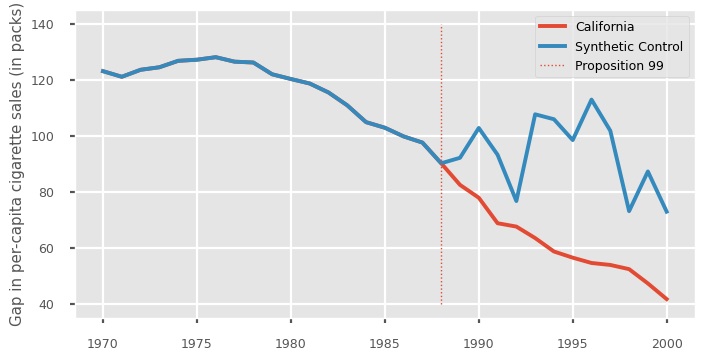

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth_lr, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=1, label="Proposition 99")
plt.ylabel('Gap in per-capita cigarette sales (in packs)')
plt.legend();

OK… Something seems off. What grabs your attention in this picture? First, after the intervention, the synthetic control has more cigarette sales than California. This is an indicative that the intervention was successful in lowering cigarette demand. Second, notice how the pre-intervention period is fitted perfectly. The synthetic control is able to match the state of California exactly. This is a sign that our synthetic control model is probably overfitting the data. Another sign is the huge variance on the outcome variable of the synthetic control after the intervention. Notice how it doesnt follow smooth patterns. Instead, it goes up and down and up and down.


If we think about why this is happening, remember that we have 38 states in our donor pool. So our linear regression has 38 parameters to play with in order to make the pretreatment pool match the treatment as close as it can. This is the case where, even if T is large, N is also large, which gives too much flexibility to our linear regression model. If you are familiar with regularized models, know that you could use Ridge or Lasso regression to fix this. Here, we will look at another more traditional way to avoid overfitting.

## Don't Extrapolate

Suppose you have data like in this table below and are asked to build a synthetic control to reproduce the treated unit using any linear combination of the control units.

|unit|sales|price|
|--|--|--|
|control 1|8|8|
|control 2|8|4|
|control 3|4|5|
|treated  |2|10|

Since there are 3 units and only 2 attributes to match, there are multiple exact solutions to this problem, but a nice one is multiplying the first control by 2.25, multiplying the second by -2 and adding both. Notice how the second multiplication creates a fake unit with sales of -16 and price of -8. This multiplication is extrapolating the control 2 unit to a region of the data that doesn't make a lot of sense, since negative price and sales are almost impossible. The first multiplication is also an extrapolation, since it takes the first unit to a region where sales and price are 18. These numbers are much higher than anything we have in our data, hence the extrapolation.

This is what regression is doing when we ask it to create a synthetic control. Extrapolation is not technically wrong, but it's dangerous in practice. We are making assumptions that the data we have never seen behaves like the data that we have.

One way to play safer is to constrain our synthetic control to only do interpolation. To do so, we will restrict the weights to be positive and sum up to one. Now, the synthetic control will be a convex combination of the units in the donor pool. When doing interpolation, we will project the treated unit in the convex hull defined by the untreated unit, much like in the picture below.


Notice two things here. First, interpolation won't be able to create a perfect match of the treated unit in this case. This is because the treated is the unit with the smallest number of sales and the highest price. Convex combinations can only replicate exactly features that are in between the control units. Another thing to notice is that interpolation is sparse. We will project the treated unit on a wall of the convex hull and this wall is defined only by a few units. For this reason, interpolation will assign weight zero to many of the units.

This is the general idea, now let's formalize it a little bit. The synthetic control is still defined as

$
\hat{Y}^N_{jt} = \sum^{J+1}_{j=2} w_j Y_{jt}
$

but now, we will use weights $\pmb{W}=(w_2, ..., w_{J+1})$ that minimises

$
||\pmb{X}_1 - \pmb{X}_0 \pmb{W}|| = \bigg(\sum^k_{h=1}v_h \bigg(X_{h1} - \sum^{J+1}_{j=2} w_j X_{hj} \bigg)^2 \bigg)^{\frac{1}{2}}
$

subject to the restriction that $w_2, ..., w_{J+1}$ are positive and sum to one. Notice that $v_h$ reflect the importance of each variable when minimising the difference between the treated and the synthetic control. Different $v$s would give different optimal weights. One way to choose $V$ is to make it so that each variable has mean zero and unit variance. A more complex way is to choose $V$ in such a way that variables that help to predict $Y$ better get higher importance. Since we want to keep the code simple, we will simply give the same importance for each variable.

To implement this, first, define the above loss function.

In [ ]:
from typing import List
from operator import add
from toolz import reduce, partial

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

Since we are using the same importance for every feature, we don't need to worry about $v$.

Now, to get the optimal weights, we will use the quadratic programming optimisation of scipy. We will constrain the weights to sum up to 1 with

```python
lambda x: np.sum(x) - 1
```

Also, we will set optimization bounds to be between 0 and 1.

In [ ]:
from scipy.optimize import fmin_slsqp

def get_w(X, y):

    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x:np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

With this implemented, let's get the weights that define the synthetic control

In [ ]:
calif_weights = get_w(X, y)
print('Sum:', calif_weights.sum())
np.round(calif_weights, 4)

Sum: 1.000000000000424


array([0.    , 0.    , 0.    , 0.0852, 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.113 , 0.1051, 0.4566, 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.2401, 0.    , 0.    , 0.    , 0.    , 0.    ])

With this weight, we are multiplying states 1,2, and 3 by zero, state 4 by 0.0852 and
so on. Notice how the weights are sparse, exactly as we've predicted. Also, all weights sum to one and are between 0 and 1, satisfying our convex combination constraint.

Now, to get the synthetic control, we can multiply those weights by the states exactly as we did before with the regression weights.

In [ ]:
calif_synth = cigar.query("~california").pivot(index='year', columns='state')['cigsale'].values.dot(calif_weights)

If we plot the outcome of the synthetic control now, we get a much smoother trend. Also notice that, in the pre intervention period, the synthetic control doesn't reproduce the treated exactly anymore. This is a good sign, as it indicates that we are not overfitting.

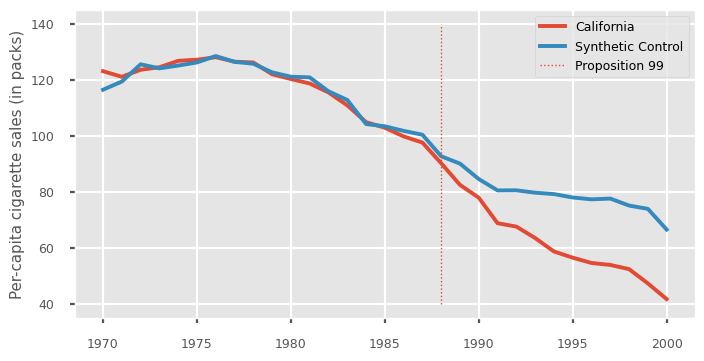

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=1, label="Proposition 99")
plt.ylabel("Per-capita cigarette sales (in packs)")
plt.legend();

With the synthetic control at hand, we can estimate the treatment effect as the gap between treated and the synthetic control outcomes.

$
\tau_{1t} = Y^I_{jt} - Y^N_{jt}
$

In our particular case, the effect gets bigger and bigger as time passes.

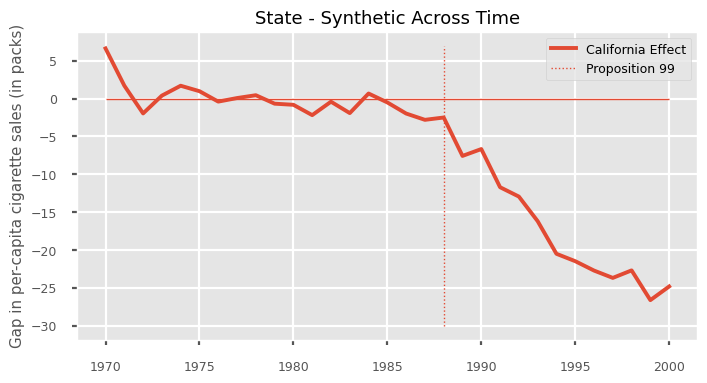

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth, label="California Effect")
plt.vlines(x=1988, ymin=-30, ymax=7, linestyle=":", lw=1, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=1)
plt.title("State - Synthetic Across Time")
plt.ylabel('Gap in per-capita cigarette sales (in packs)')
plt.legend();

By the year 2000, it looks like Proposition 99 has reduced the sales in cigarettes by 25 packs. That is very cool and all, but something you might be asking yourself is: how can I know if this is statistically significant?

## Making Inference

Since our sample size is very small (39), we will have to be a bit smarter when figuring out if our result is statistically significant and not just due to random luck. Here, we will use the idea of Fisher's Exact Test. Its intuition is very simple. We permute the treated and control exhaustively. Since we only have one treated unit, this would mean that, for each unit, we pretend it is the treated while the others are the control.

|iteration|1|2|...|39|
|----|-|-|-|-|
|1|treated|0|0|0|
|2|0|treated|0|0|
|...|0|0|0|0|0|0|
|39|0|0|0|treated|

In the end, we will have one synthetic control and effect estimates for each state. So what this does is it pretends that the treatment actually happened for another state, not California, and see what would have been the estimated effect for this treatment that didn't happen. Then, we see if the treatment in California is sufficiently larger when compared to the other fake treatment. The idea is that for states that weren't actually treated, once we pretend they were, we won't be able to find any significant treatment effect.

To implement this, I've built this function that takes as input a state and estimate the synthetic control for that state. This function returns a data frame with one column for the state, one for the year, one for the outcome `cigsale` and the synthetic outcome for that state.

In [ ]:
def synthetic_control(state:int, data:pd.DataFrame) -> np.array:

    features = ["cigsale", "retprice"]

    inverted = (data.query("~after_treatment")
                    .pivot(index='state', columns="year")[features].T)

    y = inverted[state].values # treated
    X = inverted.drop(columns=state).values # donor pool

    weights = get_w(X, y)
    synthetic = (data.query(f"~(state=={state})")
                    .pivot(index='year', columns="state")["cigsale"]
                    .values.dot(weights))

    return (data.query(f"state=={state}")[["state", "year", "cigsale", "after_treatment"]]
                       .assign(synthetic=synthetic))

Here is the result of it when we apply it to the first state.

In [ ]:
synthetic_control(1, cigar).head()

,state,year,cigsale,after_treatment,synthetic
0,1,1970,89.800003,False,95.029419
1,1,1971,95.400002,False,99.118199
2,1,1972,101.099998,False,101.881329
3,1,1973,102.900002,False,103.938655
4,1,1974,108.199997,False,107.038474


To get the result for all the state, we parallelize the computation across 8 processes. If your computer has more or less cores, you can use a different number. This code will return a list of data frames like the one above.

In [ ]:
from joblib import Parallel, delayed

control_pool = cigar["state"].unique()

parallel_fn = delayed(partial(synthetic_control, data=cigar))

synthetic_states = Parallel(n_jobs=8)(parallel_fn(state) for state in control_pool)

In [ ]:
synthetic_states[0].head()

,state,year,cigsale,after_treatment,synthetic
0,1,1970,89.800003,False,95.029419
1,1,1971,95.400002,False,99.118199
2,1,1972,101.099998,False,101.881329
3,1,1973,102.900002,False,103.938655
4,1,1974,108.199997,False,107.038474


With the synthetic control for all the states, we can estimate the gap between the synthetic and the true state for all states. For California, this is the treatment effect. For the other states, this is like a placebo effect, where we estimate the synthetic control treatment effect where the treatment didn't actually happen. If we plot all the placebo effects along with the California treatment effect, we get the following figure.

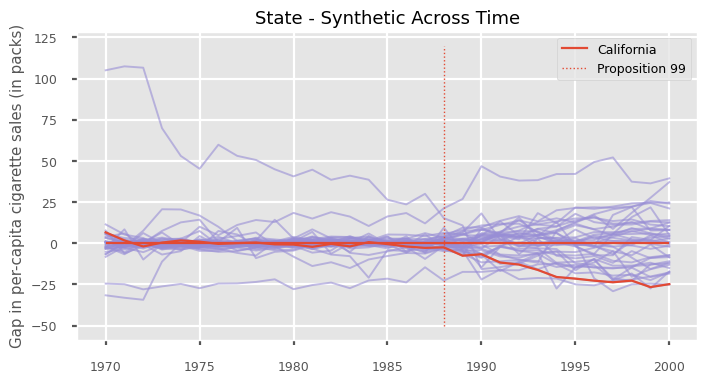

In [ ]:
plt.figure(figsize=(8, 4))
for state in synthetic_states:
    plt.plot(state["year"], state["cigsale"] - state['synthetic'], color='C9', alpha=0.6, lw=1.4)

plt.plot(cigar.query('california')["year"], cigar.query("california")['cigsale'] - calif_synth, label="California", lw=1.6);

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=1, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=1.6)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("State - Synthetic Across Time")
plt.legend();

Two aspects of this figure jump to the eyes. First, we can see that the variance after the intervention is higher than the variance before the intervention. This is expected, since the synthetic control is designed to minimize the difference in the pre-intervention period. Another interesting aspect is that there are some units we can't fit very well even in the pre-intervention period. This is also to be expected. For example, if some states have very high cigarette consumption, no convex combination of the other states will ever match them.

Since those units are so poorly fit, it is a good idea to remove them from the analysis. One way to do it objectively is to set a threshold for pre-intervention error

$
MSE = \frac{1}{N}\sum\bigg(Y_t - \hat{Y}^{Synth}_t\bigg)^2
$

and remove those units with high error. If we proceed like this and plot the same figure, this is what we get.

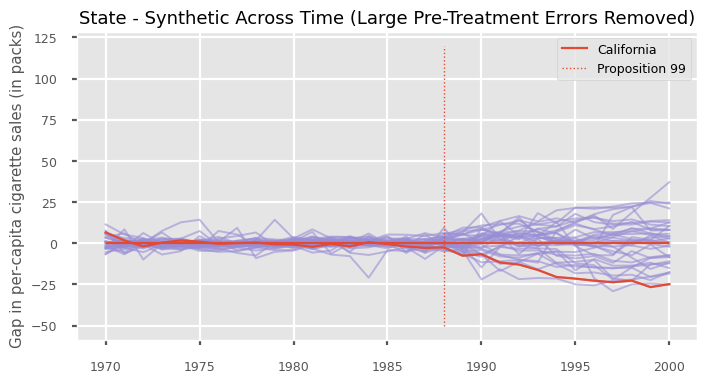

In [ ]:
def pre_treatment_error(state):
    pre_treat_error = (state.query("~after_treatment")["cigsale"]
                       - state.query("~after_treatment")["synthetic"]) ** 2

    return pre_treat_error.mean()

plt.figure(figsize=(8, 4))
for state in synthetic_states:

    # remove units with mean error above 80.
    if pre_treatment_error(state) < 80:
        plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C9", alpha=0.6, lw=1.4)

plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
        label="California", lw=1.6);

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=1, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=1.6)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("Distribution of Effects")
plt.title("State - Synthetic Across Time (Large Pre-Treatment Errors Removed)")
plt.legend();

Removing the noise, we can see how extreme of a value is the effect in the state of California. This image shows us that if we pretend the treatment had happened to any other state, we would almost never get an effect so extreme as the one we got with California.

This picture alone is a form of inference, but we can also derive a P-value from these results. All we have to do is see how many times the effects that we've got is below the effect of California.

In [ ]:
calif_number = 3

effects = [state.query("year==2000").iloc[0]['cigsale'] - state.query("year==2000").iloc[0]["synthetic"]
           for state in synthetic_states
           if pre_treatment_error(state) < 80] # filter out noise

calif_effect = cigar.query("california & year==2000").iloc[0]['cigsale'] - calif_synth[-1]

print("California Treatment Effect for the Year 2000:", calif_effect)
np.array(effects)

California Treatment Effect for the Year 2000: -24.83015975607075


array([  5.79715887,   0.89458999, -24.83015976,  -7.1662812 ,
       -10.92204855,  37.1164056 , -15.06971721,  -0.49805136,
       -18.45795109,  21.13366447,  12.57782745,  -1.47547826,
        10.49627389, -11.67012367,   4.29850832,   8.04811402,
        14.02322406,   8.25002775,   0.32576355,  -8.40826871,
        -2.12402707,  -7.42865061,   2.96157551,  24.10478092,
         4.25211766, -17.75844561,   7.93334017,   2.81640128,
        12.64955962, -17.47677514, -25.1604094 , -12.26469132,
        24.69067354,  10.36299584,  -8.59880347])

if we want to test the one sided hypothesis that the effect in California is below zero, we can estimate the P-value as the proportion of times the effect in California is bigger than all the estimated effects.

$
PV=\frac{1}{N}\sum \mathcal{1}\{\hat{\tau}_{Calif} > \hat{\tau}_j\}
$

As it turns out, the treatment effect for California in the year 2000 is -24.8, meaning that the intervention reduced the consumption of cigarettes by almost 25 packs. Out of all the other 34 placebo effects that we've estimated, only one is higher than the effect we found in California. So the p-value would be 1/35.

In [ ]:
np.mean(np.array(effects) < calif_effect)

np.float64(0.02857142857142857)

Finally, we can show the distribution of effects just to get a sense of how extreme the value of the effect in California really is.

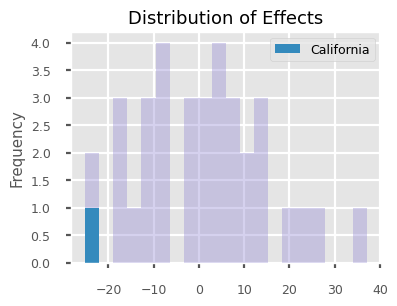

In [ ]:
plt.figure(figsize=(4, 3))
_, bins, _ = plt.hist(effects, bins=20, color="C9", alpha=0.4)
plt.hist([calif_effect], bins=bins, color='C1', label="California")
plt.ylabel('Frequency')
plt.title('Distribution of Effects')
plt.legend();

## Key Ideas

We've learned that if we only have aggregated level data on entities like cities or states, diff-in-diff won't allow us to do inference. Also, it has some other limitations, since it has to define a control unit and one single control unit might not be a very good representation of the counterfactual for the treated unit.

To correct for that, we learned that we can build a synthetic control that combines multiple control units to make them resemble the treated unit. With this synthetic control, we were able to see what would have happened to our treated unit in the absence of a treatment.

Finally, we saw how we could use Fisher's Exact Tests to do inference with synthetic control. Namely, we've pretended that the non-treated units were actually the treated and computed their effect. These were the placebo effects: the effects we would observe even without a treatment. We uses these to see if the treatment effect we've estimated was statistically significant.


# 4 - The Difference-in-Differences Saga



After discussing treatment effect heterogeneity, we will now switch gears a bit, back into average treatment effects. Over the next few chapters, we will cover some recent developments in panel data methods. A panel is a data structure that has repeated observations across time. The fact that we observe the same unit in multiple time periods allows us to see what happens before and after a treatment takes place. This makes panel data a promising alternative to identifying the causal effects when randomization is not possible.

To motivate the use of panel data, we will mostly talk about causal inference applications to marketing. Marketing is particularly interesting for its notorious difficulty in running randomized experiments. In marketing, we often can't control who receives the treatment, that is, who sees our advertisements. When a new user comes to our site or downloads our app, we have no good way of knowing if that user came because he or she saw one of our campaigns or due to some other factor.

(OBS: For those more familiar with marketing attribution, I'm aware of the many attribution tools that aim at solving this problem. But I'm also aware of their many limitations).

The problem is even bigger with offline marketing. How can you know if a TV campaign brought value in excess of its costs? Because of that, a common practice in marketing is Geo-Experiments: we deploy a marketing campaign to some geographical region but not others and compare them. In this design panel data methods are particularly interesting: we can collect data on an entire geography (unit) across multiple periods of time. To make sense of this sort of data and identify the causal effect, perhaps the most popular methods are those in the Diff-in-Diff (DiD) family.

The years 2020 and 2021 have not been easy for most of us. But it was particularly hard on DiD. A lot of recent research highlighted some severe flaws in these methods, flaws which were not well known in the past. So, although we already have a chapter in Part I covering DiD, the content there is rather introductory. It doesn’t cover the new findings and effervescent discussions around panel data methods. We should now take a more thorough look at them, beginning with Diff-in-Diff. In this specific chapter, I’ll try to summarize the recently discovered problems with diff-in-diff and also show how to fix them. This chapter is divided into three sections:

1. **Birth**: Recap why panel data is so attractive for causal inference and how DiD and Two Way Fixed Effect (TWFE) leverages the temporal structure in its favor.
2. **Death**: Digest one key assumption implied by DiD and TWFE models that has been overlooked. Understand when and how that assumption can fail.  
3. **Enlightenment**: Knowing the problem with DiD and TWFE, we can now think about a solution for it. This part shows a simple workaround to the problem explored in section 2.

Let’s get right into it!


## 1) Birth: The Promise of Panel Data


Like I’ve said, panel data is when we have multiple units `i` over multiple periods of time `t`. Think about a policy evaluation scenario in the US, where you want to check the effect of cannabis legalization on crime rate. You have crime rate data on multiple states `i` over multiple time periods `t`. You also observe at what point in time each state adopts legislation in the direction of cannabis legalization. I hope you can see why this is incredibly powerful for causal inference. Call cannabis legalization the treatment `D` (since `T` is taken; it represents time). We can follow the trend on crime rates for a particular state that eventually gets treated and see if there are any disruptions in the trend at the treatment time. In a way, a state serves as its own control unit, in a before and after comparison. Furthermore, because we have multiple states, we can also compare treated states to control states. When we put both comparisons together, treated vs control and before vs after treatment, we end up with an incredibly powerful tool to infer counterfactuals and, hence, causal effects.

Panel data methods are often used in government policy evaluation, but we can easily make an argument about why they are also incredibly useful for the (tech) industry. Companies often track user data across multiple periods of time, which results in a rich panel data structure. Not only that, sometimes experimentation is not possible, so we have to rely on other identification strategies. To explore that idea further, let's consider a hypothetical example of a young tech company that tracks the number of people that installed its app across multiple cities. At some point in 2021, the tech company launched a new feature in their app. It now wants to know how many new uses that feature brought to the company. The rollout was gradual. Some cities got the feature in `2021-06-01`. Others, in `2021-07-15`. The full rollout to the rest of the cities only happens in 2022. Since our data only goes up until `2021-07-31`, this last group can be considered the control group. In causal inference terms, rolling out this feature can be seen as the treatment and number of installs can be seen as the outcome. We want to know the treatment effect on the outcome, that is, the effect of the new feature on the number of installs.

Notice how the tech company cannot do an experiment here. They can’t control which person gets to know they have a new feature. We say that they have limited control over the treatment assignment. That's because the unit of analysis is **people that are not yet their customers**. They want to know how many of those they can convert to customers by installing their app. Of course they can’t randomize anything for those people. So, instead, they changed the unit of analysis to cities. The release in one city versus the other is something they can control, which is not the case for the release for one person versus the other.

The group of cities that got the feature (got treated) at a specific point in time is called a cohort. In our case, we have three cohorts: one that got treated in `2021-06-01`, another that got treated in `2021-07-15` and a control cohort, which only gets treated after the end of our data. To get a sense of what this data looks like, let's plot the average daily installs grouped by cohort.

In [ ]:
date = pd.date_range("2021-05-01", "2021-07-31", freq="D")
cohorts = pd.to_datetime(["2021-06-01", "2021-07-15", "2022-01-01"]).date
units = range(1, 100+1)

np.random.seed(1)

df = pd.DataFrame(dict(
    date = np.tile(date, len(units)),
    unit = np.repeat(units, len(date)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(date)),
    unit_fe = np.repeat(np.random.normal(0, 5, size=len(units)), len(date)),
    time_fe = np.tile(np.random.normal(size=len(date)), len(units)),
    week_day = np.tile(date.weekday, len(units)),
    w_seas = np.tile(abs(5-date.weekday) % 7, len(units)),
)).assign(
    trend = lambda d: (d["date"] - d["date"].min()).dt.days/70,
    day = lambda d: (d["date"] - d["date"].min()).dt.days,
    treat = lambda d: (d["date"] >= d["cohort"]).astype(int),
).assign(
    y0 = lambda d: 10 + d["trend"] + d["unit_fe"] + 0.1*d["time_fe"] + d["w_seas"]/10,
).assign(
    y1 = lambda d: d["y0"] + 1
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    installs = lambda d: np.where(d["treat"] == 1, d["y1"], d["y0"])
)

In [ ]:
df.head()

,date,unit,cohort,unit_fe,time_fe,week_day,w_seas,trend,day,treat,y0,y1,tau,installs
0,2021-05-01,1,2021-07-15,0.600795,0.232495,5,0,0.000000,0,0,10.624044,11.624044,1.0,10.624044
1,2021-05-02,1,2021-07-15,0.600795,0.682551,6,1,0.014286,1,0,10.783336,11.783336,1.0,10.783336
2,2021-05-03,1,2021-07-15,0.600795,-0.310117,0,5,0.028571,2,0,11.098355,12.098355,1.0,11.098355
3,2021-05-04,1,2021-07-15,0.600795,-2.434838,1,4,0.042857,3,0,10.800168,11.800168,1.0,10.800168
4,2021-05-05,1,2021-07-15,0.600795,1.038825,2,3,0.057143,4,0,11.061820,12.061820,1.0,11.061820


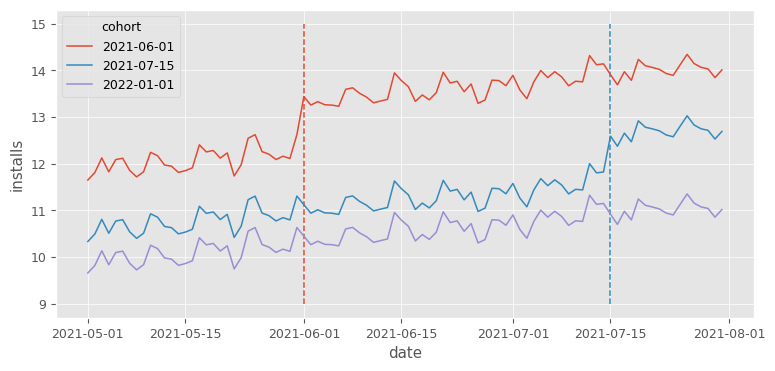

In [ ]:
plt.figure(figsize=(9, 4))
[plt.vlines(x=cohort, ymin=9, ymax=15, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts[:-1])]
sns.lineplot(
    data=(df.groupby(["cohort", "date"])["installs"].mean().reset_index()),
    x="date",
    y="installs",
    hue="cohort",);

The dashed lines mark the moment a cohort got the treatment (the feature was rolled out). Take a moment to appreciate the richness of the data depicted in the above plot. First, we can see that each cohort has its own baseline level. That's simply because different cities have different population sizes, leading to more or less installs depending on the city size. For instance, it looks like cities in the first cohort (treated in 06/01) have a higher baseline, compared to the cities in the other cohorts. Also, it looks like the control cohort has a lower baseline of intalls. This means that simply comparing treated cohorts against the control cohorts would yield a biased result, since $Y_{0}$ for the control is lower than the $Y_{0}$ for the treated, or $Y_{0}|G=Control < Y_{0}|G=Treated$, where we use $G$ to denote the cohort. Fortunately this won’t be a problem. Panel data allow us to compare across cities **and** time, which allows it to adjust for different baselines.

Speaking of time, notice how there is an overall upward trend with some wiggles (which looks like weekly seasonality). Focusing on the control cohort, it looks like daily installs went from about 10 in May to about 11 in June, an increase of about 1. In technical terms, latter time periods have higher $Y_{0}$ than early time periods. This means that simply comparing the same cities across time would also yield biased results. Once again, we are fortunate that the panel data structure allows us to compare not only across time, but also across cities, adjusting for trends.

Ideally, to infer the effect of the rollout of this new feature on installs, we want to know what would have happened to the cohorts that got the feature, had they not got it. We want to estimate the counterfactual outcome $Y(0)$ in the post treatment periods for the treated cohorts. If we denote each cohort by the time it got treated `g` (remember that a cohort is just a group of cities that got treated at the same time), we can write this counterfactual as $E[Y_0|t\geq g]$, which would then allow us to define the treatment effect on the treated (the ATT) for cohort `g` as follows:

$$
E[Y_1|t \geq g] - E[Y_0|t\geq g]
$$


The next question is how can we estimate this from the data we have. Well, one way is to exploit the power of the panel data structure and estimate those counterfactuals. For instance, we could use linear regression and the Diff-in-Diff formulation to get a Two Way Fixed Effect model. Let's say each city `i` has a base install level $\gamma_i$. This ties back to what we saw earlier: maybe a city has more installs because it has a bigger population or because its culture is more in line with the product from our tech company. Regardless of the reason and even if we don't know why, we say that those unit idiosyncrasies can be captured by a **time fixed parameter** $\gamma_i$. Similarly, we can say that each time period `t` has a baseline install level which we can capture by a **unit fixed parameter** $\theta_t$. If that is the case, a good way of modeling install is to say it depends on the city (unit) effect $\gamma$ and the time effect $\theta$, plus some random noise.

$$
Installs_{it} = \gamma_i + \theta_t + e_{it}
$$

To include the treatment in this picture, let's define a variable $D_{it}$ which is 1 if the unit is treated and zero otherwise. In our example, this variable would be always zero for the never treated cohort. It would also be zero for all the other cohorts at the beginning, but it would turn into 1 at 06/01 for the cohort treated on 06/01 and stay at 1 after that. Also, it would turn into 1 at 07/15 for the cohort treated on 07/15. We can include those treatment indicators in our model of installs as follows:

$$
Installs_{it} = \tau D_{it} + \gamma_i + \theta_t + e_{it}
$$

Estimating the above model with OLS is what is called the Two-Way Fixed Effects Model (TWFE). Notice that $\tau$ would be the treatment effect, as it tells us how much installs changes once units are treated.

Another way of looking at it is to invoke the "holding things constant" propriety of linear regression. If we estimate the above model, we could read the estimate of $\tau$ as how much installs would change if we flip the treatment from 0 to 1 while holding the unit `i` and time `t` fixed.

Notice how bold this is! To say we would hold each unit fixed while seeing how $D$ changes the outcome is to say we are controlling for all unit specific characteristics that are constant through time, known and unknown. For example, we would be controlling for cities' baseline install level, which we can measure, but also stuff we have no idea about, like how much a city culture is in line with our product. The only requirement is that this characteristic is fixed over the time of the analysis. Moreover, to say we would hold each time period fixed is to say we are controlling for all year specific characteristics. For instance, since we are holding the year fixed, while looking at the effect of $D$, we would be controlling for the trend and seasonalities we saw earlier.

To see all this power in action all we have to do is run an OLS model with the treatment indicator $D$ (`treat` here), plus dummies for the units and time. In our particular example, I've generated data in such a way that the effect of the treatment (new feature) is to increase installs by 1. Notice how TWFE can recover that treatment effect perfectly:

In [ ]:
formula = f"""installs ~ treat + C(unit) + C(date)"""

twfe_model = smf.ols(formula, data=df).fit()

twfe_model.params["treat"]

np.float64(1.0000000000000497)

Since I've simulated the data above, I know exactly the true individual treatment effect, which is stored in the `tau` column. Since the TWFE should recover the treatment effect on the treated, we can verify that the true ATT matches the one estimated above. All we have to do is filter the treated units and period (`treat==1`) and take the average of the `tau` column.

In [ ]:
df.query("treat==1")["tau"].mean()

np.float64(1.0)

Before anyone comes and says that generating one dummy column for each unit is impossible with big data, let me come forward and tell you that, yes, that is true. But there is an easy work around. We can use the FWL theorem to partition that single regression into two. In fact, running the above model is numerically equivalent to estimating the following model

$$
\tilde{Installs}_{it} = \tau \tilde D_{it} + e_{it}
$$

where

$$
\tilde{Installs}_{it} = Installs_{it} - \underbrace{\frac{1}{T}\sum_{t=0}^T Installs_{it}}_\text{Time Average} - \underbrace{\frac{1}{N}\sum_{i=0}^N Installs_{it}}_\text{Unit Average}
$$

and

$$
\tilde{D}_{it} = D_{it} - \frac{1}{T}\sum_{t=0}^T D_{it} - \frac{1}{N}\sum_{i=0}^N D_{it}
$$

In words now, in case the math is too crowded, we subtract the unit average across time (first term) and the time average across units (second term) from both the treatment indicator and the outcome variable to constrict the residuals. This process is oftentimes called de-meaning, since we subtract the mean from the outcome and treatment. Finally, here is the same exact thing, but in code:

In [ ]:
@curry
def demean(df, col_to_demean):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby("unit")[col_to_demean].transform("mean")
                                        - df.groupby("date")[col_to_demean].transform("mean"))})

formula = f"""installs ~ treat"""
mod = smf.ols(formula,
              data=df
              .pipe(demean(col_to_demean="treat"))
              .pipe(demean(col_to_demean="installs")))

result = mod.fit()

print(result.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.4580   6.12e-16  -1.87e+16      0.000     -11.458     -11.458
treat          1.0000   1.54e-15   6.48e+14      0.000       1.000       1.000


Another thing we can do to understand what TWFE model is doing is to plot the counterfactual predictions $\hat{Y_0}|t \geq g$. This is helpful because what our model sees as the treatment effect $\hat{\tau}$ as simply the estimated difference $Y_1 - \hat{Y_0}$. Looking at this explicit difference can shed some light on what the model is doing. In the plot below, we can see exactly that, $\hat{Y_0}$ represented by dotted lines.

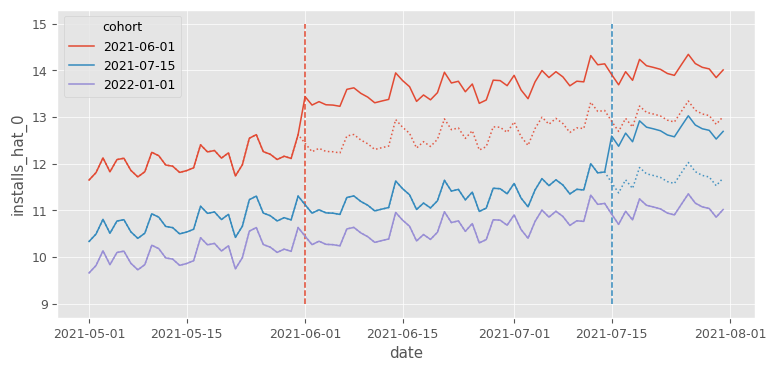

In [ ]:
df_pred = df.assign(**{"installs_hat_0": twfe_model.predict(df.assign(**{"treat":0}))})

plt.figure(figsize=(9,4))
[plt.vlines(x=cohort, ymin=9, ymax=15, color=color, ls="dashed") for color, cohort in zip(["C0","C1"], cohorts[:-1])]

sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs_hat_0"].mean().reset_index()),
    x="date",
    y="installs_hat_0",
    hue="cohort",
    alpha=0.9,
    ls="dotted",
    legend=None
)

sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs"].mean().reset_index()),
    x="date",
    y="installs",
    hue="cohort",
);

This plot shows us how TWFE is projecting the trend it sees in the control units onto the treated units and it is also adjusting the levels. For example, if we look at the red cohort, the counterfactual $Y_0$ is the average trend from the blue and purple cohorts (trend projection) but shifted to the level of the red cohort (level adjustment). This is why we see TWFE as a Difference-in-Differences method. It also does the trend projection and level adjustment, but it works for multiple time periods and multiple units (in the 2 units by 2 period case, TWFE and DiD are equivalent).

## 2) Death: Failures over Effect Heterogeneity


As we just saw, DiD and TWFE has its merits. It can estimate counterfactuals quite well, accommodating both time and unit specific variations. This makes it a powerful causal inference technique. But if this was all there was to it, we wouldn't need this chapter, as this is very much covered in Part I of this book. What happened recently is that many academics noticed that extending the 2 by 2 DiD to multiple periods with TWFE is not as straightforward as we first thought. In fact, **TWFE, in its usual formulation, turns out to be biased in many real life applications**. This event caused a wave of revisions in multiple studies in economics that relied on this technique. To understand all of that, the best way to start is by stating the underlying assumption.



For simplicity sake let's consider the FE model without the time effects:

$$
y_{it} = \tau D_{it} + \gamma_i + e_{it}
$$


We can group the assumption this model makes into two groups

1. Functional Form Assumptions:
    * No heterogeneous effects in time (constant effects);
    * Linearity in the covariates;
    * Additive fixed effects.
2. Strict Exogeneity
    * Parallel trends
    * No anticipation
    * No unobserved time varying confounders
    * Past treatment don't affect current outcome (no carryover)
    * Past outcome don't affect current treatment (no feedback)
    
Here, we will stick to the functional form assumptions. Linearity in the covariates is very well known and applies to all linear regression models. But, as we saw with the chapter on Double/Debiased Machine Learning, we can easily relax that assumption with a machine learning model. This means that we can relax this assumption if we wish to do so. As for the additive fixed effect, this is not a too restrictive assumption, so it doesn't cause a lot of problems. The one I want to focus on (and which generated a lot of fuss) is the one about no heterogeneous effects in time.

### Treatment Effect Heterogeneity in Time

If you ever worked with marketing or tech, you know things take time to mature. If you launch a new feature, it will take time for users to get used to it. Similarly, if you start a marketing campaign, the effect of that campaign won't be instantaneous. It will mature over time and perhaps bring new users even after the campaign is over. This is **not** the pattern that we had in install data we've seen earlier. There, installs jumped up instantaneously, at the moment the cohort is treated. What happens if we change that to be more in line with what we see in reality. Namely, let's make it so that the ATT is still 1, but now, it takes 10 days to mature (so it will be 0.1 at the first treatment day, 0.2 at the second treatment day and so on, until it reaches 1 on the 10th day). Also, I'll reduce the size of the time and unit effects so that the overall trend is easier to see.

In [ ]:
date = pd.date_range("2021-05-01", "2021-07-31", freq="D")
cohorts = pd.to_datetime(["2021-06-01", "2021-07-15", "2022-01-01"])
units = range(1, 100+1)

np.random.seed(1)

df_heter = pd.DataFrame(dict(
    date = np.tile(date, len(units)),
    unit = np.repeat(units, len(date)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(date)),
    unit_fe = np.repeat(np.random.normal(0, 5, size=len(units)), len(date)),
    time_fe = np.tile(np.random.normal(size=len(date)), len(units)),
    week_day = np.tile(date.weekday, len(units)),
    w_seas = np.tile(abs(5-date.weekday) % 7, len(units)),
)).assign(
    trend = lambda d: (d["date"] - d["date"].min()).dt.days/70,
    day = lambda d: (d["date"] - d["date"].min()).dt.days,
    treat = lambda d: (d["date"] >= d["cohort"]).astype(int),
).assign(
    y0 = lambda d: 10 + d["trend"] + 0.2*d["unit_fe"] + 0.05*d["time_fe"] + d["w_seas"]/50,
).assign(
    y1 = lambda d: d["y0"] + np.minimum(0.1*(np.maximum(0, (d["date"] - d["cohort"]).dt.days)), 1)
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    installs = lambda d: np.where(d["treat"] == 1, d["y1"], d["y0"])
)

In [ ]:
df_heter.head()

,date,unit,cohort,unit_fe,time_fe,week_day,w_seas,trend,day,treat,y0,y1,tau,installs
0,2021-05-01,1,2021-07-15,0.600795,0.232495,5,0,0.000000,0,0,10.131784,10.131784,0.0,10.131784
1,2021-05-02,1,2021-07-15,0.600795,0.682551,6,1,0.014286,1,0,10.188572,10.188572,0.0,10.188572
2,2021-05-03,1,2021-07-15,0.600795,-0.310117,0,5,0.028571,2,0,10.233225,10.233225,0.0,10.233225
3,2021-05-04,1,2021-07-15,0.600795,-2.434838,1,4,0.042857,3,0,10.121274,10.121274,0.0,10.121274
4,2021-05-05,1,2021-07-15,0.600795,1.038825,2,3,0.057143,4,0,10.289243,10.289243,0.0,10.289243


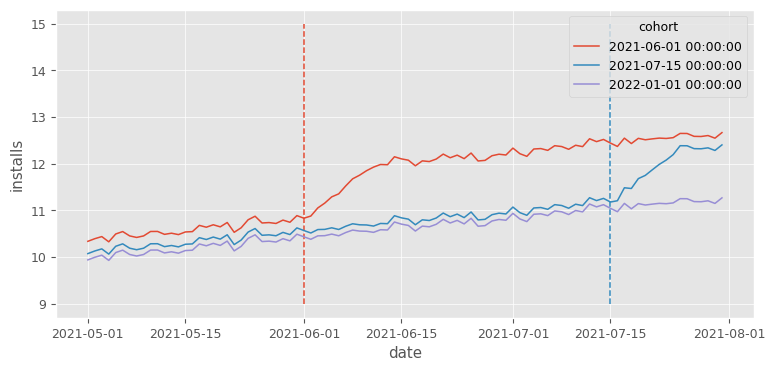

In [ ]:
plt.figure(figsize=(9,4))

[plt.vlines(x=cohort, ymin=9, ymax=15, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts)]
sns.lineplot(
    data=(df_heter
          .groupby(["cohort", "date"])["installs"]
          .mean().reset_index()),
    x="date",
    y="installs",
    hue="cohort",
);

What we see is that the installs still reach the same level as they did before, but it takes some time (10 days) for that. This seems reasonable right? Most of the data we see in real life works like that, with effects taking some time to mature. Ok, so let's run TWFE model on this data to see what happens.

In [ ]:
formula = f"""installs ~ treat + C(date) + C(unit)"""

twfe_model = smf.ols(formula, data=df_heter).fit()

print("Estimated Effect:", twfe_model.params["treat"])
print("True Effect:", df_heter.query("treat==1")["tau"].mean())

Estimated Effect: 0.7867708225724861
True Effect: 0.8544117647058823


First, notice that the true ATT is no longer 1. That is because it will be smaller in the first few periods. Second, and most importantly, we can see is that the **estimated ATT from TWFE is not recovering the true ATT** anymore. To put it simply:TWFE is biased. But why is that? We have parallel trends, no anticipation and all the other strict exogeneity assumptions here. So what is going on?

The first step towards understanding what is happening is to realize that TWFE can actually be decomposed into multiple 2 by 2 Diff-in-Diffs. In our example, that would be one that compares early treated to never treated, late treated against never treated, early treated against late treated (with late treated serving as the control) and late treated against early treated (with early treated being the control):

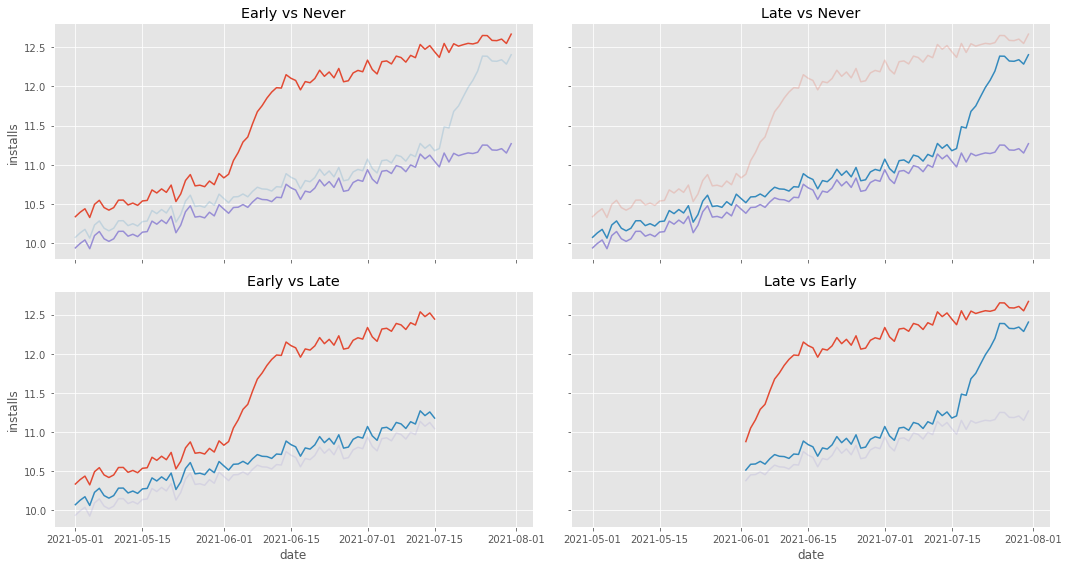

In [ ]:
g_plot_data = (df_heter
               .groupby(["cohort", "date"])["installs"]
               .mean()
               .reset_index()
               .astype({"cohort":str}))


fig, axs = plt.subplots(2, 2, figsize=(15,8), sharex=True, sharey=True)

def plot_comp(df, ax, exclude_cohort, name):

    palette=dict(zip(map(str, cohorts), ["C0", "C1", "C2"]))

    sns.lineplot(
        data=df.query(f"cohort != '{exclude_cohort}'"),
        x="date",
        y="installs",
        hue="cohort",
        palette=palette,
        legend=None,
        ax=ax
    )

    sns.lineplot(
        data=df.query(f"cohort == '{exclude_cohort}'"),
        x="date",
        y = "installs",
        hue="cohort",
        palette=palette,
        alpha=0.2,
        legend=None,
        ax=ax
    )

    ax.set_title(name)

plot_comp(g_plot_data, axs[0,0], cohorts[1], "Early vs Never")
plot_comp(g_plot_data, axs[0,1], cohorts[0], "Late vs Never")

plot_comp(g_plot_data[g_plot_data["date"]<=cohorts[1]], axs[1,0], cohorts[-1], "Early vs Late")
plot_comp(g_plot_data[g_plot_data["date"]>cohorts[0]], axs[1,1], cohorts[-1], "Late vs Early")

plt.tight_layout();

The first three comparisons are no reason for concern, mostly because what they use as control is very well behaved. However, the fourth comparison, late vs early, is problematic. Notice that this comparison uses the early treated as a control. Also notice that this early treated control has a weird behavior. It climbs up sharply at the beginning. That is a reflection of our ATT not being instantaneous, but instead taking 10 days to mature. Intuitively, we can see that this will mess up the estimation of the counterfactual trend in the DiD, making it steeper than it should be. To visualize that, let's plot the estimated counterfactual $Y_0$ for the late treated in this 4th group.

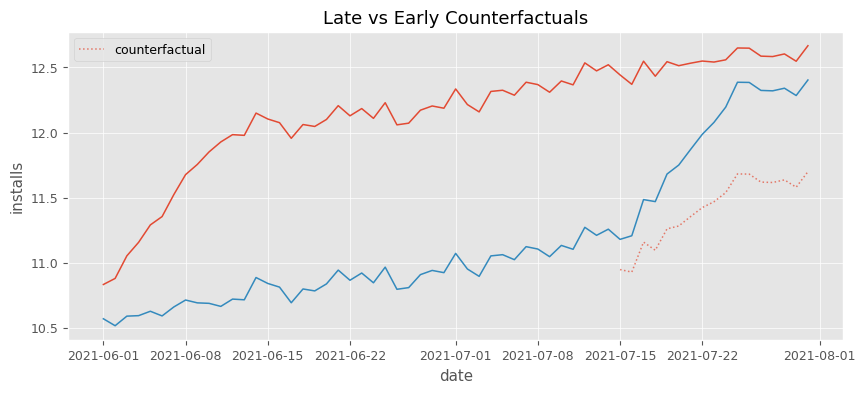

In [ ]:
late_vs_early = (df_heter
                 [df_heter["date"].astype(str)>="2021-06-01"]
                 [lambda d: d["cohort"].astype(str)<="2021-08-01"])


formula = f"""installs ~ treat + C(date) + C(unit)"""

twfe_model = smf.ols(formula, data=late_vs_early).fit()

late_vs_early_pred = (late_vs_early
                      .assign(**{"installs_hat_0": twfe_model.predict(late_vs_early.assign(**{"treat":0}))})
                      .groupby(["cohort", "date"])
                      [["installs", "installs_hat_0"]]
                      .mean()
                      .reset_index())


plt.figure(figsize=(10,4))
plt.title("Late vs Early Counterfactuals")
sns.lineplot(
    data=late_vs_early_pred,
    x="date",
    y = "installs",
    hue="cohort",
    legend=None
)

sns.lineplot(
    data=(late_vs_early_pred
          [late_vs_early_pred["cohort"].astype(str) == "2021-07-15"]
          [lambda d: d["date"].astype(str) >= "2021-07-15"]
         ),
    x="date",
    y ="installs_hat_0",
    alpha=0.7,
    color="C0",
    ls="dotted",
    label="counterfactual"
);

Just like we said, the counterfactuals have a much steeper trend than it should have. It is capturing that quick increase in the beginning of the early treatment and projecting that trend onto the late treated.

More technically, it can be shown (Goodman-Bacon, 2019) that, even under strict exogeneity (parallel trends, no anticipation...), if the cohorts have the same size, the TWFE estimator will converge to

$$
plim_{x \to \infty} \hat{\tau}^{TWFE} = VWATT - \Delta ATT
$$

The first term is the variance weighted ATT from multiple DiD comparisons like the ones we saw earlier. This is what we want. However, there is also that extra $\Delta ATT$ term there. This represents how much the ATT changes over time and it is what bias our estimate. Looking at this term, we can see that we will have downward bias if the magnitude of the effect increases with time (like in our example) or upward bias if the magnitude of the effect decreases with time.

In the example above, we saw that the effect from TWFE was smaller than the true ATT. But the situation can be even more extreme. I think it is worth going over one last example to see that this bias can be so strong as to even reverse the signal of the true ATT. Let's consider a very simple process, with only two cohorts. Here, the treatment effect will be negative and decreasing by 0.1 every day. I've also removed all time fixed effects and the trend so we can really see what is going on.

In [ ]:
date = pd.date_range("2021-05-15", "2021-07-01", freq="D")
cohorts = pd.to_datetime(["2021-06-01", "2021-06-15"])
units = range(1, 100+1)

np.random.seed(1)

df_min = pd.DataFrame(dict(
    date = np.tile(date, len(units)),
    unit = np.repeat(units, len(date)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(date)),
    unit_fe = np.repeat(np.random.normal(0, 5, size=len(units)), len(date)),
)).assign(
    trend = 0,
    treat = lambda d: (d["date"] >= d["cohort"]).astype(int),
).assign(
    y0 = lambda d: 10 - d["trend"] + 0.1*d["unit_fe"]
).assign(
    y1 = lambda d: d["y0"] - 0.1*(np.maximum(0, (d["date"] - d["cohort"]).dt.days))
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    installs = lambda d: np.where(d["treat"] == 1, d["y1"], d["y0"])
)

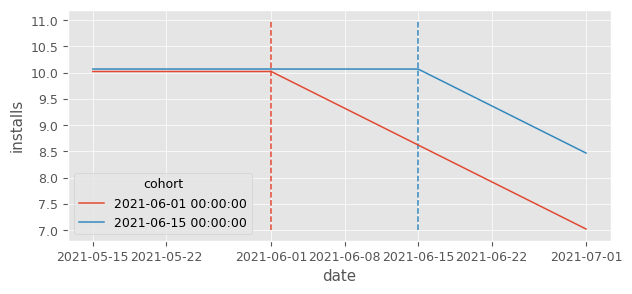

In [ ]:
plt.figure(figsize=(7, 3))
[plt.vlines(x=cohort, ymin=7, ymax=11, color=color, ls='dashed') for color, cohort in zip(["C0", "C1"], cohorts)]

sns.lineplot(
    data=(df_min
          .groupby(["cohort", "date"])["installs"].mean().reset_index()),
    x="date",
    y="installs",
    hue="cohort",
);

Looking at the plot above, we can clearly see that the ATT is negative right? The correct counterfactual should be a straight line at about 10. However, if we run the TWFE estimator, we get a positive effect!

In [ ]:
formula = f"""installs ~ treat + C(date) + C(unit)"""

twfe_model = smf.ols(formula, data=df_min).fit()

twfe_model.params["treat"]

np.float64(0.049999999999988984)

Once again, to see what is going on, focus your attention on the comparison where the early treated cohort serves as the control for the late treated. Remember that, like DiD, TWFE adjusts the trend from the control group to the level of the treated group, so the counterfactual should reflect that.

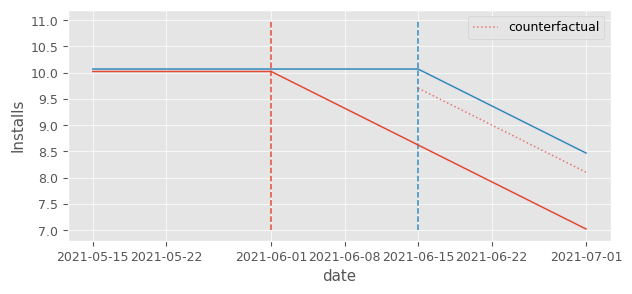

In [ ]:
df_pred = df_min.assign(**{"installs_hat_0": twfe_model.predict(df_min.assign(**{"treat":0}))})

plt.figure(figsize=(7,3))
[plt.vlines(x=cohort, ymin=7, ymax=11, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts)]
sns.lineplot(
    data=(df_pred
          [(df_pred["cohort"].astype(str) > "2021-06-01") & (df_pred["date"].astype(str) >= "2021-06-15")]
          .groupby(["cohort", "date"])["installs_hat_0"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs_hat_0",
    alpha=0.7,
    ls="dotted",
    color="C0",
    label="counterfactual",
)
sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
    legend=None
)
plt.ylabel("Installs");

Notice how the counterfactual level is pushed down from where it should be. The fact that the early treated group effect is decreasing pushed this level down from 10 to about 9.5. Not only that, the counterfactual also adjusts for a downward trend, which should not be there. It is pretty clear from the plot that the right counterfactual should be a straight line at 10, but instead, it is a downward sloping line, since that is what it sees in the early treated group it uses as a control.  

The end result is that the counterfactual $Y_0$ is actually below the $Y_1$ outcome, leading to a positive impact estimation. This is pretty awkward. By simply looking at the plot, we can pretty much see where the right counterfactual should be (the straight line at 10). Still, TWFE cannot recover that simply because it uses the early treated as a control for the late treated.

#### Event Study Design

Just to get it out of the way, I know someone might think we can easily solve this problem by what is called an event study design, where we add one dummy for each period before and after the treatment. In this case, we replace the original TWFE model by

$$
Y_{i,t} = \tau^{-K}~ D_{i,t}^{<-K} + \sum_{k=-K}^{-2} \tau^{lead} D_{i,t}^{k} +\sum_{k=0}^{L} \gamma_k^{lag} D_{i,t}^{k} + \gamma_k^{L+} D_{i,t}^{>L} \gamma_i + e_{it}
$$

where $D^k_{i,t}=1\{t-\text{Cohort}_i=k\}$ is an event study dummy that is 1 if the unit is `k` periods away from the treatment and 0 otherwise. I know this looks messy and complicated, but it is actually very simple once we look at it through some code. All we need to do is create a `relative_days` column which measures how far away is the unit from the period where treatment starts.

In [ ]:
df_min_rel = (df_min.assign(relative_days = (df_min["date"] - df_min["cohort"]).dt.days))

df_min_rel.head()

,date,unit,cohort,unit_fe,trend,treat,y0,y1,tau,installs,relative_days
0,2021-05-15,1,2021-06-15,-3.435864,0,0,9.656414,9.656414,0.0,9.656414,-31
1,2021-05-16,1,2021-06-15,-3.435864,0,0,9.656414,9.656414,0.0,9.656414,-30
2,2021-05-17,1,2021-06-15,-3.435864,0,0,9.656414,9.656414,0.0,9.656414,-29
3,2021-05-18,1,2021-06-15,-3.435864,0,0,9.656414,9.656414,0.0,9.656414,-28
4,2021-05-19,1,2021-06-15,-3.435864,0,0,9.656414,9.656414,0.0,9.656414,-27


Then, we can pass that column as a category so our model will estimate the expected number of installs for each period relative to the treatment. We can then define the effect as the extra expected number of installs compared to relative day -1, which is the last day prior to the treatment.

We might think that this formulation would capture the time heterogeneity in the ATT and solve all our issues. Unfortunately, that is not the case. If we try it out and plot the counterfactuals, we can see that they are far from where they should intuitively be (the horizontal line at 11).

In [ ]:
# remove the intercept, otherwise effects will be relative to relative day -30
formula = f"installs ~ -1 + C(relative_days) + C(date) + C(unit)"

twfe_model = smf.ols(formula, data=df_min_rel).fit()

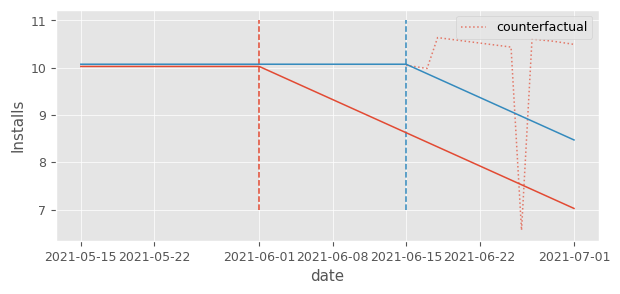

In [ ]:
df_pred = df_min_rel.assign(
    installs_hat_0=twfe_model.predict(df_min_rel.assign(relative_days=-1))
)

plt.figure(figsize=(7,3))
[plt.vlines(x=cohort, ymin=7, ymax=11, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts)]
sns.lineplot(
    data=(df_pred
          [(df_pred["cohort"].astype(str) > "2021-06-01") & (df_pred["date"].astype(str) >= "2021-06-15")]
          .groupby(["cohort", "date"])["installs_hat_0"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs_hat_0",
    alpha=0.7,
    ls="dotted",
    color="C0",
    label="counterfactual",
)
sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
    legend=None
)
plt.ylabel("Installs");



These counterfactuals are a bit better, though. We can see that they fall above the realized $Y_1$ outcome. As a result, we will at least estimate a negative effect, as we should. To see that, we can plot the estimated effects by first extracting the parameter associated with each dummy and then subtracting from them the parameter associated with relative day -1 (the baseline).

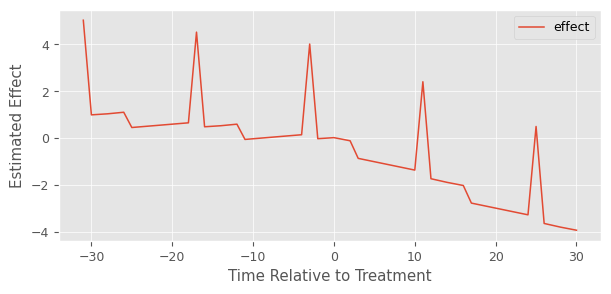

In [ ]:
effects = (twfe_model.params[twfe_model.params.index.str.contains("relative_days")]
           .reset_index()
           .rename(columns={0:"effect"})
           .assign(relative_day=lambda d: d["index"].str.extract(r'\[(.*)\]').astype(int))
           # set the baseline to period -1
           .assign(effect = lambda d: d["effect"] - d.query("relative_day==-1")["effect"].iloc[0]))

# effects
effects.plot(x="relative_day", y="effect", figsize=(7,3))
plt.ylabel("Estimated Effect")
plt.xlabel("Time Relative to Treatment");

We can kind of see it is a bit better because at least the estimated effect after the treatment is 1) mostly negative and 2) mostly decreasing. But there are these weird spikes and what looks like a positive pre-treatment effect, which obviously doesn’t make any sense.

The problem here is the same we’ve been discussing. Since we have different timing in the treatment, the early treated gets used as a control for the late treated units, which causes the model to estimate a very weird counterfactual trend. The bottom line is that adding time relative to treatment dummies does not solve the problem, but what does, exactly?

## 3) Enlightenment: A Flexible Functional Form

There are good news and bad news. First, the good news: we've identified the problem as being one related to the functional form, so we can fix it by correcting that form. Namely, we've said over and over that this specific bias in TWFE comes from the time heterogeneous effects. This can happen, among many other reasons, because the effect takes some time to mature (ex: it might take 10 days for a marketing campaign to reach its full potential). In other words, the functional form of traditional TWFE is simply not flexible enough to capture this heterogeneity, leading to the sort of bias we've discussed. Like in most cases, knowing the problem is already a long way in the direction of finding a solution.

In the end of the last section, we saw how simply allowing for a different effect on each time period relative to the treatment (event study design) was not enough. Even though that didn’t work, the intention behind it was good. It did make the model more flexible, but not in a way it solved the problem. We need to think of another way to make the model even more flexible than that.

To do that, let's go back to our original example, when we were trying to model the number of incremental installs that rolling out a new feature (treatment) brought us. We saw that the simple TWFE model does not work here:

$$
Installs_{it} = \tau D_{it} + \gamma_i + \theta_t + e_{it}
$$

More than that, we know it doesn't work because it is too restrictive. It forces the effect to be the same \\(\tau_{it}=\tau \ \forall i, t\\), that is, it forces time homogeneity. If that is the problem, an easy fix would be to simply allow for a different effect for each time and unit.

$$
Installs_{it} = \sum_{i=0}^N \sum_{t=0}^T \tau_{it} D_{it} + \gamma_i + \theta_t + e_{it}
$$

This would be equivalent to running the formula below:
```
installs ~ treat:C(unit):C(date) + C(unit) + C(date)
```

Unfortunately, we can't fit that. It would have more parameters than we have data points. Since we are interacting date and unit, we would have one treatment effect parameter for each unit for each time period $T*N$. But this is exactly the number of samples we have! OLS wouldn't even run here.

Ok, now, we need to reduce the number of treatment effect parameters of the model. To achieve that, we can think about a way of somehow grouping units. If we think about this a bit, we can see a very natural way to group units: by cohort! We know that the effect in an entire cohort follows the same pattern over time. So, a natural improvement on that impractical model above is to allow the effect to change by cohort instead of units:

$$
Installs_{it} = \sum_{g=0}^G \sum_{t=0}^T \tau_{gt} D_{it} + \gamma_i + \theta_t + e_{it}
$$

where `G` is the total number of cohorts and `g` marks each individual cohort. That model has a much reasonable number of treatment effect parameters ($T*G$) since $G$ is usually much smaller than $N$. Now, we can finally run it.

In [ ]:
formula = f"""installs ~ treat:C(cohort):C(date) + C(unit) + C(date)"""

# for nicer plots latter on
df_heter_str = df_heter.astype({"cohort":str, "date":str})

twfe_model = smf.ols(formula, data=df_heter_str).fit()

To see if this model works, we can make counterfactual predictions for $Y_0$ by forcing `treat` to be zero for everyone. Then, we can estimate the effect by taking the observed outcome for the treatment, which is $Y_1$, and subtract $\hat{Y}_0$ from it. Let's see if that matches the true ATT.

In [ ]:
df_pred = (df_heter_str
           .assign(**{"installs_hat_0": twfe_model.predict(df_heter_str.assign(**{"treat":0}))})
           .assign(**{"effect_hat": lambda d: d["installs"] - d["installs_hat_0"]}))

print("Number of params:", len(twfe_model.params))
print("True effect:", df_pred.query("treat==1")["tau"].mean())
print("Pred. Effect:", df_pred.query("treat==1")["effect_hat"].mean())

Number of params: 467
True effect: 0.8544117647058823
Pred. Effect: 0.8544117647059051


It does! We finally managed to make a model which is flexible enough to capture the time heterogeneity, which allowed us to estimate the correct treatment effect! Another cool thing we can do is extract the estimated effects by time and cohort and plot them. In this case, because we know how the data was generated, we know what to expect. Namely, the effect for each cohort must be zero before treatment, then 1 10 days after treatment and a line climbing up from zero to 1 in the days between the treatment and 10 days after it.

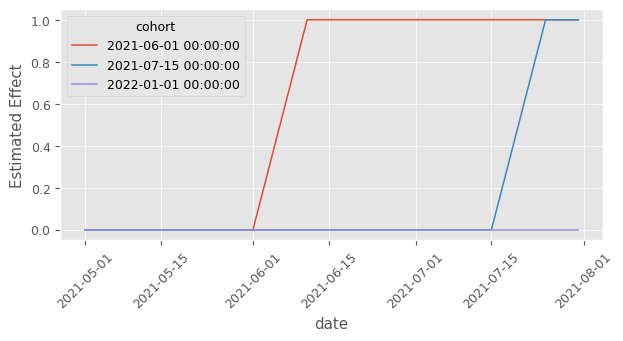

In [ ]:
effects = (twfe_model.params[twfe_model.params.index.str.contains("treat")]
           .reset_index()
           .rename(columns={0:"param"})
           .assign(cohort=lambda d: d["index"].str.extract(r'C\(cohort\)\[(.*)\]:'))
           .assign(date=lambda d: d["index"].str.extract(f':C\(date\)\[(.*)\]'))
           .assign(date=lambda d: pd.to_datetime(d["date"]), cohort=lambda d: pd.to_datetime(d["cohort"])))

plt.figure(figsize=(7, 3))
sns.lineplot(data=effects, x="date", y="param", hue="cohort")
plt.xticks(rotation=45)
plt.ylabel("Estimated Effect");

Once again, the plot above matches our expectations of the effects. They follow the exact pattern we described above.

This is already very good, but we can do even better. First, notice how that model has a huge number of parameters. Since we have 100 units and about 92 days in our data, we know that 192 of those parameters are the unit and time effects. Still, that leaves us with more than 250 treatment effect parameters.

If we assume a zero effect before the treatment (no anticipation), we can reduce the number of parameters by dropping the dates before treatment from the interaction term.

$$
Installs_{it} = \sum_{g=0}^G \sum_{t=g}^T \tau_{gt} D_{it} + \gamma_i + \theta_t + e_{it}
$$

Also, we can drop from the interaction the control cohorts, since its effect before the treatment is always zero

$$
Installs_{it} = \sum_{G=q}^g \sum_{t=g}^T \tau_{gt} D_{it} + \gamma_i + \theta_t + e_{it}
$$

where cohorts before $g<q$ are defined as the control cohorts.

Notice however that this is tricky to implement with formulas, so we have to do some feature engineering first. Namely, we will create the cohort dummies by hand, making one column which is 1 when the cohort is `2021-06-01` and 0 otherwise and another column which is 1 when the cohort is `2021-07-15` and 0 otherwise. Also, we will create a date column for cohort `2021-06-01` which collapses all dates before that cohort date to a `control` category. We can do a similar thing with the dates from the `2021-07-15` cohort. Here is what this looks like in code.

In [ ]:
def feature_eng(df):
    return (
        df
        .assign(date_0601 = np.where(df["date"]>="2021-06-01", df["date"], "control"),
                date_0715 = np.where(df["date"]>="2021-07-15", df["date"], "control"),)
        .assign(cohort_0601 = (df["cohort"]=="2021-06-01").astype(float),
                cohort_0715 = (df["cohort"]=="2021-07-15").astype(float))
    )

formula = f"""installs ~ treat:cohort_0601:C(date_0601)
                       + treat:cohort_0715:C(date_0715)
                       + C(unit) + C(date)"""

twfe_model = smf.ols(formula, data=df_heter_str.pipe(feature_eng)).fit()

If we now make counterfactual predictions like before, we can see that the estimated effect is still matching the true effect perfectly. The gain here is that we have a much simpler model, with only about 80 treatment effect parameters (remember that 192 of those parameters are the time and unit fixed effect).

In [ ]:
df_pred = (df_heter_str
           .assign(**{"installs_hat_0":twfe_model.predict(df_heter_str
                                                          .pipe(feature_eng)
                                                          .assign(**{"treat":0}))})
           .assign(**{"effect_hat": lambda d: d["installs"] - d["installs_hat_0"]}))

print(len(twfe_model.params))
print("True Effect:", df_pred.query("treat==1")["tau"].mean())
print("Pred Effect:", df_pred.query("treat==1")["effect_hat"].mean())

271
True Effect: 0.8544117647058823
Pred Effect: 0.8544117647058885


Plotting the treatment effect parameters, we can see how we've removed those from the control cohort and those from the dates before the cohort is treated.

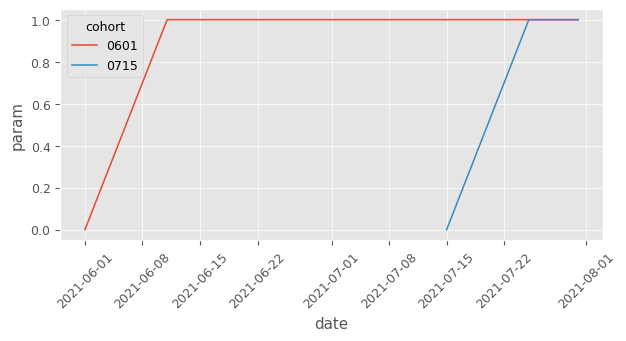

In [ ]:
effects = (twfe_model.params[twfe_model.params.index.str.contains("treat")]
           .reset_index()
           .rename(columns={0:"param"})
           .assign(cohort=lambda d: d["index"].str.extract(r':cohort_(.*):'),
                   date_0601=lambda d: d["index"].str.extract(r':C\(date_0601\)\[(.*)\]'),
                   date_0715=lambda d: d["index"].str.extract(r':C\(date_0715\)\[(.*)\]'))
           .assign(date=lambda d: pd.to_datetime(d["date_0601"].combine_first(d["date_0715"]), errors="coerce")))


plt.figure(figsize=(7,3))
sns.lineplot(data=effects.dropna(subset=["date"]), x="date", y="param", hue="cohort")
plt.xticks(rotation=45);

One last thing we should do besides showing the effects over time is to plot the counterfactuals to see if they are in a place that feels right. I know this is not a very scientific validation of our model, but trust me, it helps a tone. So here it is.

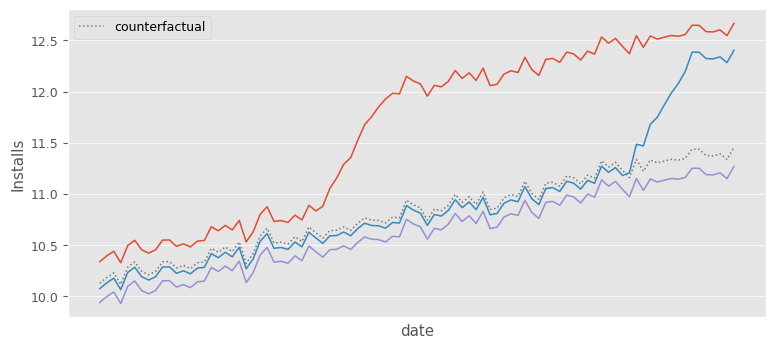

In [ ]:
plt.figure(figsize=(9,4))
sns.lineplot(
    data=(df_pred
        #   [(df_pred["cohort"].astype(str) > "2021-06-01") & (df_pred["date"].astype(str) >= "2021-06-01")]
          .groupby(["date"])["installs_hat_0"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs_hat_0",
    ls="dotted",
    color="C3",
    label="counterfactual",
)

sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
    legend=None
)

plt.xticks([])
plt.ylabel("Installs");

As we can see, the counterfactual $Y_0$ prediction falls right where we think it should fall, that is, pretty close to the control cohort. This is very comforting. We know that the TWFE model is estimating the treatment effect as $Y-\hat{Y_0}$. That is, it is simply comparing the outcome from the treated cohorts to that counterfactual. Since the counterfactual seems OK, we can rest assured that the treatment effect is also probably OK.

That is the good news, but don’t think I forgot about the bad news I’ve promised you. The thing is that, although we’ve solved the functional form problem with TWFE, there is still an arguably bigger problem with DiD and TWFE, which is related to its independence assumption.

When using DiD and TWFE, we often invoke the parallel trends assumption, without really thinking about what exactly that assumption means. Sadly, the parallel trends assumption is much more restrictive and less plausible than most people realize	. But since this chapter is already too big, I think it's fine to end it here, where we can still enjoy the taste of a small victory for DiD.

## Key Concepts

I think it is safe to say that we've finally managed not only to understand, but to correct the functional form problem with TWFE. We traced the problem down to its roots (time heterogeneity) and fixed it by allowing for more flexibility. We can now grab ourselves a drink and relax, knowing that TWFE is once again safe to use. Or is it?!



We can never forget that TWFE (and DiD more generally) is a mix of **both functional form and independence assumptions**. In this chapter, we've only tackled the functional form problems, but there is still a big elephant in the room: the parallel trend assumption. Parallel trends is the independence assumption DiD makes. This is very well known. But I feel we don't really understand what this assumption implies. We just invoke it out of thin air as if that would make it true. Unfortunately, the parallel trend assumption requires much more than what most people realize. In the next chapters, we will see why that is and what or if we can do something about it.


# 5 - Synthetic Difference-in-Differences

In previous chapters, we looked into both Difference-in-Differences and Synthetic Control methods for identifying the treatment effect with panel data (data where we have multiple units observed across multiple time periods). It turns out we can merge both approaches into a single estimator. This new Synthetic Difference-in-Differences estimation procedure manages to exploit advantages of both methods while also increasing the precision (decreasing the error bars) of the treatment effect estimate.

We will discuss Synthetic Difference-in-Differences mostly in the case of **block treatment assignment**. This means we observe multiple units across time and, at the **same** time, some units are treated while other units remain untreated. We can visualize this by a matrix of treatment assignments $D$, where the **columns of the matrix are units** and **rows of the matrix are time periods**.

$$
D = \begin{bmatrix}
    0 & 0 & 0 & \dots & 0 & 0 \\
    0 & 0 & 0 & \dots & 0 & 0 \\
    \vdots \\
    0 & 0 & 0 & \dots & 1 & 1 \\
    0 & 0 & 0 & \dots & 1 & 1 \\
\end{bmatrix}
$$

To make things more concrete, let's follow along with the example of estimating the impact of Proposition 99 in California's Cigarette consumption. In this case, we only have one treated unit, California, that gets treated (passed Proposition 99) at some point in time (November 1988, to be precise). If we say California is the last column of the matrix, we get something like this:

$$
D = \begin{bmatrix}
    0 & 0 & 0 & \dots & 0 & 0 \\
    0 & 0 & 0 & \dots & 0 & 0 \\
    \vdots \\
    0 & 0 & 0 & \dots & 0 & 1 \\
    0 & 0 & 0 & \dots & 0 & 1 \\
\end{bmatrix}
$$

Notice that here we are only talking about the case where all treated units get the treatment **at the same point in time**. In the end, we will discuss how to handle **staggered addoption treatment assignment**, where the treatment is gradually rolled out to units, causing them to get it at different points in time. The only thing we'll require in that design is that, once a unit is treated, it doesn't roll back to being untreated.

Back to the simple case, where we have all units treated at the same time, we can simplify the treatment assignment matrix to four blocks, each represented by another matrix. In general, as we move down the matrix, we are moving forward in time. We will also group the treated units to the right of the matrix. As a result, the first block in our matrix (top left) correspond to the control units prior to the treatment period; the second one (top right) corresponds to the treated units prior to the treatment period; the third block (bottom left) contains the control units after the treatment period and the fourth block (bottom right) is the treated unit after the treatment period. The treatment indicator is zero everywhere except for the block with the treated units after the treatment period.

$$
D = \begin{bmatrix}
    \pmb{0} & \pmb{0} \\
    \pmb{0} & \pmb{1} \\
\end{bmatrix}
$$

This assignment matrix will lead to the following outcome matrix:

$$
Y = \begin{bmatrix}
    \pmb{Y}_{pre, co} & \pmb{Y}_{pre, tr} \\
    \pmb{Y}_{post, co} & \pmb{Y}_{post, tr} \\
\end{bmatrix}
$$

Again, notice how the post-treatment period is on the bottom and the treated units are to the right.

In our example of estimating the effect of Proposition 99, the outcome $Y$ is cigarette sales. We use $pre$ and $post$ to represent the period prior and after the treatment respectively and $co$ and $tr$ to represent the control and treated unit respectively.

We will use the above matrix representation whenever we talk about estimating the synthetic control weights, but there is also another data representation which is useful, especially if we are talking about DiD. In this representation, we have a table with 5 columns: one representing the units, one representing the time periods, the outcome column and two boolean columns flagging the treated units and the treatment period. The number of rows in this table is the number of units $N$ times the number of periods $T$. Here you can see what it looks like for the Proposition 99 data:

In [6]:
data = (pd.read_csv("./data/smoking.csv")[["state", "year", "cigsale", "california", "after_treatment"]]
        .rename(columns={"california":"treated"})
        .replace({"state":{3: "california"}}))

data.head()

,state,year,cigsale,treated,after_treatment
0,1,1970,89.800003,False,False
1,1,1971,95.400002,False,False
2,1,1972,101.099998,False,False
3,1,1973,102.900002,False,False
4,1,1974,108.199997,False,False


In [7]:
data[data.state=="california"]

,state,year,cigsale,treated,after_treatment
62,california,1970,123.000000,True,False
63,california,1971,121.000000,True,False
64,california,1972,123.500000,True,False
65,california,1973,124.400002,True,False
66,california,1974,126.699997,True,False
67,california,1975,127.099998,True,False
68,california,1976,128.000000,True,False
69,california,1977,126.400002,True,False
70,california,1978,126.099998,True,False
71,california,1979,121.900002,True,False


In [8]:
data.query("state=='california'").query("year.between(1986, 1990)")

,state,year,cigsale,treated,after_treatment
78,california,1986,99.699997,True,False
79,california,1987,97.500000,True,False
80,california,1988,90.099998,True,False
81,california,1989,82.400002,True,True
82,california,1990,77.800003,True,True


If we want to go from this table to the matrix representation we discussed earlier, all we have to do is pivot the table by time (year) and unit (state). We'll be going back and forth between these two representations, as one is more convenient for DiD and the other, for Synthetic Controls estimation.

In [9]:
data_piv = data.pivot(index="year", columns="state", values="cigsale")
data_piv = data_piv.rename(columns={c: f"state_{c}" for c in data_piv.columns if c != "california"})

data_piv.head()[["state_1", "state_2", "state_4", "state_38", "state_39", "california"]].round()

state,state_1,state_2,state_4,state_38,state_39,california
year,,,,,,
1970,90.0,100.0,125.0,106.0,132.0,123.0
1971,95.0,104.0,126.0,105.0,132.0,121.0
1972,101.0,104.0,134.0,109.0,140.0,124.0
1973,103.0,108.0,138.0,110.0,141.0,124.0
1974,108.0,110.0,133.0,112.0,146.0,127.0


In terms of potential outcomes, we can go back to the outcome matrix to review the causal inference goal here. Since the treatment is only rolled out to the treated unit after the treatment period, we observe the potential outcome $Y_0$ everywhere in the matrix, except for the bottom right block.

$$
Y = \begin{bmatrix}
    \pmb{Y}(0)_{pre, co} & \pmb{Y}(0)_{pre, tr} \\
    \pmb{Y}(0)_{post, co} & \pmb{Y}(1)_{post, tr} \\
\end{bmatrix}
$$

Our goal is to estimate the $ATT =  \pmb{Y}(1)_{post, tr} -  \pmb{Y}(0)_{post, tr}$. For that, we need to somehow estimate the missing potential outcome $\pmb{Y}(0)_{post, tr}$. In words, we need to know what would have happened to the treated unit in the post-treatment period had it not been treated. With that in mind, a good place to start is by reviewing both Diff-in-Diff and Synthetic Control. At first, it looks like they are each doing very different things to estimate that missing potential outcome. Combining them sure feels weird. However, both methods have more in common than we might think.

## Diff-in-Diff Revisited

In the Diff-in-Diff chapter, we got the treatment effect by estimating the following linear model.

$$
Y_{it} = \beta_0 + \beta_1 Post_t + \beta_2 Treated_i + \beta_3 Treated_i  Post_t + e_{it}
$$

Where `post` is a time dummy indicating that the period is after the treatment and `treated` is a unit dummy marking units as being part of the treated group. If we estimate this model in the California example, we get -27.34 as the estimated $ATT$, indicating a strong negative effect of Proposition 99. This would mean that per capita consumption of cigarettes fell by 27 packs due to Proposition 99.

In [10]:
did_model = smf.ols("cigsale ~ after_treatment*treated", data=data).fit()
att = did_model.params["after_treatment[T.True]:treated[T.True]"]
print("DiD ATT:", att.round(3))

DiD ATT: -27.349


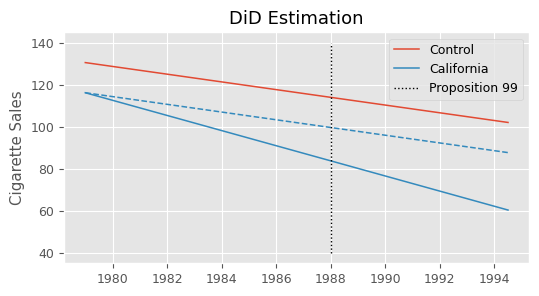

In [11]:
plt.figure(figsize=(6,3))

pre_year = data.query("~after_treatment")["year"].mean()
post_year = data.query("after_treatment")["year"].mean()

pre_control_y = did_model.params["Intercept"]
post_control_y = did_model.params["Intercept"] + did_model.params["after_treatment[T.True]"]

pre_treat_y = did_model.params["Intercept"] + did_model.params["treated[T.True]"]

post_treat_y0 = post_control_y + did_model.params["treated[T.True]"]

post_treat_y1 = post_treat_y0 + did_model.params["after_treatment[T.True]:treated[T.True]"]

plt.plot([pre_year, post_year], [pre_control_y, post_control_y], color="C0", label="Control")
plt.plot([pre_year, post_year], [pre_treat_y, post_treat_y0], color="C1", ls="dashed")
plt.plot([pre_year, post_year], [pre_treat_y, post_treat_y1], color="C1", label="California")

plt.vlines(x=1988, ymin=40, ymax=140, linestyles=":", lw=1, label="Proposition 99", color="black")
plt.title("DiD Estimation")
plt.ylabel('Cigarette Sales')
plt.legend();

This estimate should be taken with a grain of salt, though. We know that Diff-in-Diff requires the trend in the control group to be equal to that of the treated group in the absence of the treatment. Formally, $E[Y(0)_{post, co} - Y(0)_{pre, co}] = E[Y(0)_{post, tr} - Y(0)_{pre, tr}]$. This is an untestable assumption, but looking at the pre-treatment trend of California (the treated unit) and the other states, we can get a feeling for how plausible it is. Specifically, we can see that the trend in `cigsale` for California is not parallel to the other states, at least in the pre-treatment periods. Cigarette sales in California are decreasing faster than the average of the control states, even prior to the treatment. If this trend extends beyond the pre-treatment period, the DiD estimator will be downward biased, meaning that the true effect is actually less extreme than the one we've estimated above.

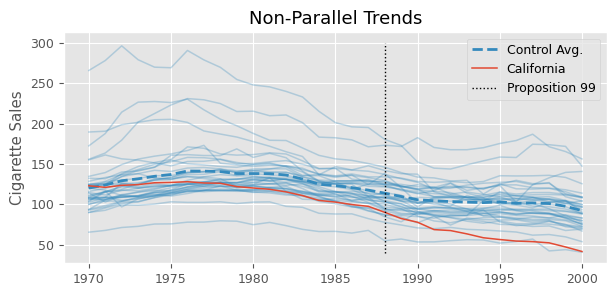

In [12]:
plt.figure(figsize=(7, 3))
plt.plot(data_piv.drop(columns=["california"]), color="C1", alpha=0.3)
plt.plot(data_piv.drop(columns=["california"]).mean(axis=1), lw=2, color="C1", ls="dashed", label="Control Avg.")
plt.plot(data_piv["california"], color="C0", label="California")
plt.vlines(x=1988, ymin=40, ymax=300, linestyle=":", lw=1, label="Proposition 99", color="black")
plt.legend()
plt.ylabel("Cigarette Sales")
plt.title("Non-Parallel Trends");

The problem of non-parallel trends is where Synthetic Control comes into play in the Synthetic Diff-in-Diff model. But we are getting ahead of ourselves. Regardless of DiD being a valid model for the data above, what is interesting about it is that we can recast it into the Two-Way Fixed-Effects formulation. To frame DiD like this, we fit unit ($\alpha_i$) and time ($\beta_t$) averages, alongside the treatment indicator.

$$
\hat{\tau}^{did} = \underset{\mu, \alpha, \beta, \tau}{argmin} \bigg\{ \sum_{i=1}^N \sum_{t=1}^T \big(Y_{it} - (\mu + \alpha_i + \beta_t + \tau D_{it}\big)^2 \bigg\}
$$

In this formulation, the unit effects capture the difference in intercepts for each unit while the time effects capture the general trend across both treated and control units. To implement this, we could either add time and unit dummies to the model or demean the data. In this process, we subtract the average across both time and units from both treatment and outcome variables:

$$
\ddot{Y}_{it} = Y_{it} - \bar{Y}_i  - \bar{Y}_t\\
\ddot{D}_{it} = D_{it} - \bar{D}_i - \bar{D}_t
$$

Where, $\bar{X}_i$ is the average across all time periods for unit $i$ and $\bar{X}_t$ is the average across all units for time $t$:

$$
\ddot{Y}_{it} = Y_{it} - T^{-1}\sum_{t=0}^{t=T} Y_{it}  - N^{-1}\sum_{i=0}^{i=N} Y_{it}\\
\ddot{D}_{it} = D_{it} - T^{-1}\sum_{t=0}^{t=T} D_{it} - N^{-1}\sum_{i=0}^{i=N} D_{it}
$$

After demeaning, a simple regression of the outcome on the treatment indicator (`treat*post`) yields the difference in difference estimator.

In [13]:
@curry
def demean(df, col_to_demean):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby("state")[col_to_demean].transform("mean")
                                        - df.groupby("year")[col_to_demean].transform("mean"))})

formula = f"""cigsale ~ treat"""
mod = smf.ols(formula,
              data=data
              .assign(treat = data["after_treatment"]*data["treated"])
              .pipe(demean(col_to_demean="treat"))
              .pipe(demean(col_to_demean="cigsale")))

print(mod.fit().summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -119.1647      0.333   -358.379      0.000    -119.817    -118.512
treat        -27.3491      4.283     -6.385      0.000     -35.753     -18.945


As you can see, we get the exact same parameter as before. After all, both approaches are simply different ways of looking at the same DiD estimator. However, the reason this formulation is much more interesting for our purpose is that it allows us to see how DiD is actually quite similar to Synthetic Controls. Take a very close look at the TWFE formulation above. Notice that it is a regression problem with time effects and unit effects. But notice how there are no weights in the optimization objective. That is the main difference between Diff-in-Diff and Synthetic Controls, as we will see shortly.

## Synthetic Controls Revisited

In the canonical Synthetic Control estimator, we find unit (state) weights that minimize the difference between the pre-treated outcome of the treated unit and the weighted average of the pre-treated outcome of the control units (in a setting with no covariates). We also constrain the weights to be all positive and sum up to one. To find those weights, we solve the following optimization problem:

$$
\hat{w}^{sc} = \underset{w}{\mathrm{argmin}} \ ||\pmb{\bar{y}}_{pre, tr} - \pmb{Y}_{pre, co} \pmb{w}_{co}||^2_2 \\
\text{s.t } \ \sum w_i = 1 \text{ and } \ w_i > 0 \ \forall \ i
$$

where the outcome $\pmb{Y}_{pre, co}$ is a $T_{pre}$ by $N_{co}$ matrix, where the columns are the units and the rows are the time periods. $\pmb{w}_{co}$ is a $N_{co}$ by 1 column vector, with one entry for each unit. Finally, $\pmb{\bar{y}}_{pre, tr}$ is a $T_{pre}$ by 1 column vector, where each entry is the time average of the treated units in the pre-treatment period. This is why we sometimes call Synthetic Control a horizontal regression. In most regression problems, the units are the rows of the matrix, but here they are the columns. Hence, we are regressing the average outcome of the treated units on the control units.

Once we find the weights that solve the problem above, we can multiply them by the control units at all time periods to get a synthetic control for the treated unit:

$$
\pmb{y}_{sc} = \pmb{Y}_{co}\hat{\pmb{w}}^{sc}
$$

The idea here is that $\pmb{y}_{post, sc}$ is a good estimator for our missing potential outcome $Y(0)_{post, tr}$. If that is the case, the $ATT$ is simply the average of the treated unit in the post-treatment period minus the average of the synthetic control, also in the post treatment period.

$$
\hat{\tau} =  \bar{y}_{post, tr} - \bar{y}_{post, sc}
$$


In [14]:
# %%writefile sc.py

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
import cvxpy as cp

class SyntheticControl(BaseEstimator, RegressorMixin):

    def __init__(self,):
        pass

    def fit(self, X, y):

        X, y = check_X_y(X, y)

        w = cp.Variable(X.shape[1])
        objective = cp.Minimize(cp.sum_squares(X@w - y))

        constraints = [cp.sum(w) == 1, w >= 0]

        problem = cp.Problem(objective, constraints)
        problem.solve(verbose=False)

        self.X_ = X
        self.y_ = y
        self.w_ = w.value

        self.is_fitted_ = True
        return self


    def predict(self, X):

        check_is_fitted(self)
        X = check_array(X)

        return X @ self.w_

In [15]:
# from sc import SyntheticControl

sc_model = SyntheticControl()

y_co_pre = (data.query("~after_treatment")
                            .query("~treated").pivot(index="year", columns="state", values="cigsale"))
y_tr_pre = data.query("~after_treatment").query("treated")["cigsale"]

sc_model.fit(y_co_pre, y_tr_pre)
sc_weights = pd.Series(sc_model.w_, index=y_co_pre.columns, name="sc_w")

sc = data.query("~treated").pivot(index="year", columns="state", values="cigsale").dot(sc_weights)

att = data.query("treated")["cigsale"][sc.index > 1988].mean() - sc[sc.index > 1988].mean()

print("SC ATT:", att.round(4))

SC ATT: -19.5136


This estimate is much smaller than the one we got with Diff-in-Diff. Synthetic Controls can accommodate non-parallel pre-treatment trends much better, so it is not susceptible to the same bias as Diff-in-Diff. Rather, the process of baking a Synthetic Control enforces parallel trends, at least in the pre-treatment period. As a result, the estimate we get is much smaller and much more plausible.

We can visualize this estimation process by plotting the realized outcome for California alongside the outcome of the synthetic control. We also plot as dashed lines the post intervention average of both California and the synthetic control. The difference between these lines is the estimated $ATT$.

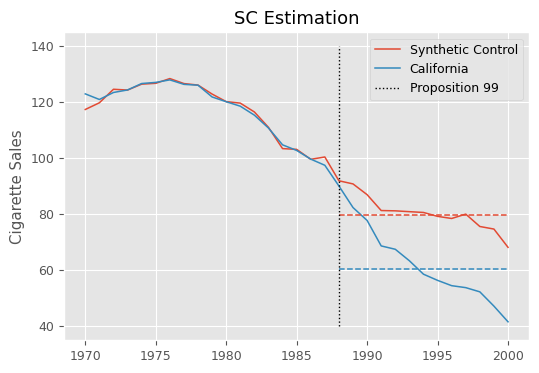

In [16]:
plt.figure(figsize=(6, 4))

plt.plot(sc, label="Synthetic Control")
plt.plot(sc.index, data.query("treated")["cigsale"], label="California", color="C1")

calif_avg = data.query("treated")["cigsale"][sc.index > 1988].mean()
sc_avg = sc[sc.index > 1988].mean()

plt.hlines(calif_avg, 1988, 2000, color="C1", ls="dashed")
plt.hlines(sc_avg, 1988, 2000, color="C0", ls="dashed")

plt.title("SC Estimation")
plt.ylabel("Cigarette Sales")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=1, label="Proposition 99", color="black")
plt.legend();

Interestingly enough, we can also recast the Synthetic Control estimator as solving the following optimization problem, which is quite similar to the Two-Way Fixed-Effects formulation we used for Diff-in-Diff

$$
\hat{\tau}^{sc} = \underset{\beta, \tau}{argmin}  \bigg\{ \sum_{i=1}^N \sum_{t=1}^T \big(Y_{it} - \beta_t - \tau D_{it}\big)^2 \hat{w}^{sc}_i \bigg\}
$$

where the $\hat{w}^{sc}_i$ weights for the control units are estimated from the optimization problem we saw earlier. For the treated unit,  the weights are simply $1/N_{tr}$ (uniform weighting).

Notice the difference between SC and DiD here. First, Synthetic Control adds unit weights $\hat{w}^{sc}_i$ to the equation. Second, we have time fixed effects $\beta_t$ but no unit fixed effect $\alpha_i$, nor an overall intercept  $\mu$.

To verify that these two formulations are actually equivalent, here is the code for it, which yields the exact same $ATT$ estimate.

In [17]:
@curry
def demean_time(df, col_to_demean):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby("year")[col_to_demean].transform("mean"))})

data_w_cs_weights = data.set_index("state").join(sc_weights).fillna(1/len(sc_weights))

formula = f"""cigsale ~ -1 + treat"""

mod = smf.wls(formula,
              data=data_w_cs_weights
              .assign(treat = data_w_cs_weights["after_treatment"] * data_w_cs_weights["treated"])
              .pipe(demean_time(col_to_demean="treat"))
              .pipe(demean_time(col_to_demean="cigsale")),
              weights=data_w_cs_weights["sc_w"]+1e-10)

print(mod.fit().summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
treat        -19.5136     13.289     -1.468      0.142     -45.586       6.559


We just saw how the two approaches, SC and DiD, are actually closely related. Now, we are ready to talk about Synthetic Diff-in-Diff. As you can probably guess, we will just add weights to the DiD estimator or unit fixed-effects to the Synthetic Control estimator.

## Synthetic Diff-in-Diff

Before we jump right into the Synthetic Diff-in-Diff estimator, let me just reproduce the same equations we saw earlier for SC and DiD, which will ease the comparison.

$$
\hat{\tau}^{sc} = \underset{\beta, \tau}{argmin}  \bigg\{ \sum_{i=1}^N \sum_{t=1}^T \big(Y_{it} - \beta_t - \tau D_{it}\big)^2 \hat{w}^{sc}_i \bigg\}
$$

$$
\hat{\tau}^{did} = \underset{\mu, \alpha, \beta, \tau}{argmin} \bigg\{ \sum_{i=1}^N \sum_{t=1}^T \big(Y_{it} - (\mu + \alpha_i + \beta_t + \tau D_{it}\big)^2 \bigg\}
$$

Next, just like I promised, we can easily merge the equations above into one which will contain elements from both of them:

$$
\hat{\tau}^{sdid} = \underset{\mu, \alpha, \beta, \tau}{argmin}  \bigg\{ \sum_{i=1}^N \sum_{t=1}^T \big(Y_{it} - (\mu + \alpha_i + \beta_t + \tau D_{it}\big)^2 \hat{w}^{sdid}_i \hat{\lambda}^{sdid}_t \bigg\}
$$

As you can see, we've added back the $\alpha_i$ unit fixed effects. We've also kept the unit weights $\hat{w}_i$. But there is something new, which is the time weights $\hat{\lambda}_t$. Don't worry. There is nothing fancy about them. Remember how the unit weights $w_i$ minimized the difference between the control units and the average of treated units? In other words, we use them to match the pre-trend of the treated and control groups. The time weight does the same thing, but for the periods. That is, it minimizes the difference between the pre and post-treated periods for the controls.

$$
\hat{\lambda}^{sdid} = \underset{\lambda}{\mathrm{argmin}} \ ||\bar{\pmb{y}}_{post, co} - (\pmb{\lambda}_{pre} \pmb{Y}_{pre, co} +  \lambda_0)||^2_2 \\
\text{s.t } \ \sum \lambda_t = 1 \text{ and } \ \lambda_t > 0 \ \forall \ t
$$

Again, $\pmb{Y}_{pre, co}$ is a $T_{pre}$ by $N_{co}$ matrix of outcomes where the rows represent time periods and the columns represent the units. But now $\bar{\pmb{y}}_{post, co}$ is a 1 by $N_{co}$ row vector, where each entry is the time average outcome for that control unit in the post-treatment period. Finally, $\pmb{\lambda}_{pre}$ is a 1 by $T_{pre}$ row vector, with one entry for each pretreatment period. Another way to see this is by noticing that the unit weights $w$ were post-multiplying the outcome matrix $\pmb{Y}_{pre, co} \pmb{w}_{co}$. This means we were regressing the average outcome **for each unit** of the treated group on the outcome of the units in the control group. Now, we are flipping that problem on its head, regressing the average outcome **for each post-treatment time period** of the control group on the outcome of the same control units, but in the pre-treatment period.

As for the time weights in the post-treated periods, we just set them to one over the number of post-treated periods $1/T_{post}$ (again, doing uniform weighting). Notice that we also have an intercept $\lambda_0$. We do this to allow the post-treatment period to be above or below all the pre-treatment periods, which is the case in many applications with a clear positive or negative trend.

If all of this seems a bit abstract, maybe code will help you understand what is going on.

In [18]:
def fit_time_weights(data, outcome_col, year_col, state_col, treat_col, post_col):

    control = data.query(f"~{treat_col}")

    # pivot the data to the (T_pre, N_co) matrix representation
    y_pre = (control
             .query(f"~{post_col}")
             .pivot(index=year_col, columns=state_col, values=outcome_col))

    # group post-treatment time period by units to have a (1, N_co) vector.
    y_post_mean = (control
                   .query(f"{post_col}")
                   .groupby(state_col)
                   [outcome_col].mean().values)

    # add a (1, N_co) vector of 1 to the top of the matrix, to serve as the intercept.
    X = np.concatenate([np.ones((1, y_pre.shape[1])), y_pre.values], axis=0)

    # estimate time weights
    w = cp.Variable(X.shape[0])
    objective = cp.Minimize(cp.sum_squares(w@X - y_post_mean))
    constraints = [cp.sum(w[1:]) ==1, w[1:] >= 0]
    problem = cp.Problem(objective, constraints)
    problem.solve(verbose=False)

    # print("Intercept:", w.value[0])
    return pd.Series(w.value[1:], # remove intercept
                     name="time_weights",
                     index=y_pre.index)

The first thing we do in this code is to filter out the treated group. Then, we pivot the pre-treated data so that we have the matrix $\pmb{Y}_{pre,co}$. Next, we group the post-treatment data to get the average outcome for each control unit in the post-treatment period. We then add a row full of ones to the top of $\pmb{Y}_{pre,co}$, which will serve as the intercept. Finally, we regress $\bar{\pmb{y}}_{post, co}$ on the pre-treated periods (the rows of $\pmb{Y}_{pre,co}$) to get the time weights $\lambda_t$. Notice how we add the constraints to have the weights sum up to 1 and be non-negative. Finally, we toss the intercept away and store the time weights in a series.

Here is the result we get by running the code above to find the time weights in the Proposition 99 problem. Notice that all periods except for 1986, 87 ans 88 get zero weights. This means that a weighted average of only the last 3 periods is enough to balance pre and post treatment periods.

In [19]:
time_weights = fit_time_weights(data,
                                outcome_col="cigsale",
                                year_col="year",
                                state_col="state",
                                treat_col="treated",
                                post_col="after_treatment")

time_weights.round(3).tail()

,time_weights
year,
1984,-0.000
1985,-0.000
1986,0.366
1987,0.206
1988,0.427


To understand a bit more about the role of these weights, we can plot $\hat{\pmb{\lambda}}_{pre} \pmb{Y}_{pre, co} +  \hat{\lambda}_0$ as a horizontal line in the pretreatment period that doesn't get zeroed out. Next to it, we plot the average outcome in the post-treatment period. Notice how they align perfectly. We also show the estimated time weights in red bars and in the secondary axis.

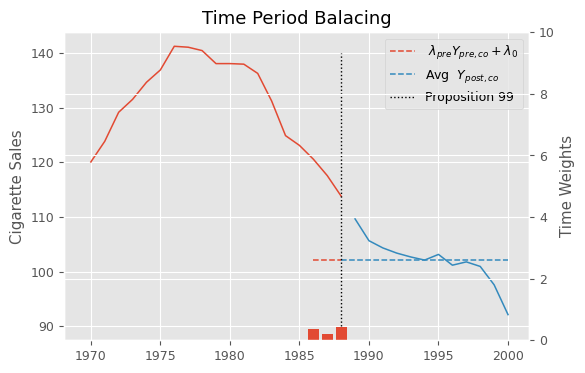

In [20]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

ax.plot(data.query("~treated").query("~after_treatment").groupby("year")["cigsale"].mean())
ax.plot(data.query("~treated").query("after_treatment").groupby("year")["cigsale"].mean())

intercept = -15.023877689807628
ax.hlines((data.query("~treated").query("~after_treatment")
                        .groupby("year")["cigsale"].mean() * time_weights).sum() - 15, 1986, 1988,
          color="C0", ls="dashed", label=""" $\lambda_{pre} Y_{pre, co} + \lambda_0$""")
ax.hlines(data.query("~treated").query("after_treatment").groupby("year")["cigsale"].mean().mean(), 1988, 2000,
          color="C1", ls="dashed", label="""Avg  $Y_{post, co}$""")
ax.vlines(x=1988, ymin=90, ymax=140, linestyle=":", lw=1, label="Proposition 99", color="black")
plt.legend()

plt.title("Time Period Balacing")
plt.ylabel("Cigarette Sales");

ax2 = ax.twinx()
ax2.bar(time_weights.index, time_weights, label="$\lambda$")
ax2.set_ylim(0, 10)
ax2.set_ylabel("Time Weights");

Now that we learned what are the time weights $\lambda_t$ in the Synthetic Diff-in-Diff estimator and how to estimate them, let's turn our attention to the unit weights $w_i$. And no, unfortunately they are not just like the ones we get when using traditional Synthetic Controls. The first difference between them is that we also allow for an intercept $w_0$. We do this because we don't need the treated unit and synthetic control to have the same level anymore. Since we will throw DiD into the mix, we only need to make the synthetic control and treated unit have parallel trends.

The next difference is that we add a $L_2$ penalty to the weights. This helps non-zero weights to be more distributed across the control units, as opposed to having just a few of them contributing to the synthetic control. The $L_2$ penalty ensures we don't have very big weights, which forces us to use more units.


$$
\hat{w}^{sdid} = \underset{w}{\mathrm{argmin}} \ ||\bar{\pmb{y}}_{pre, tr} - (\pmb{Y}_{pre, co} \pmb{w}_{co} +  w_0)||^2_2 + \zeta^2 T_{pre} ||\pmb{w}_{co}||^2_2\\
\text{s.t } \ \sum w_i = 1 \text{ and } \ w_i > 0 \ \forall \ i
$$


There is also this $\zeta^2$ term, which is theoretically motivated, but very complicated to explain, so I will unfortunately leave it as a bit of a mystery. In the reference, you can check the original article, which explains them. We define it like this:

$$
\zeta = (N_{tr}* T_{post})^{1/4}\sigma(\Delta_{it})
$$

where $\Delta_{it}$ is the first difference in the outcomes $Y_{it} - Y_{i(t-1)}$ and $\sigma(\Delta_{it})$ is the standard deviation of this difference. Here is the code to compute it.

In [21]:
def calculate_regularization(data, outcome_col, year_col, state_col, treat_col, post_col):

    n_treated_post = data.query(post_col).query(treat_col).shape[0]

    first_diff_std = (data
                      .query(f"~{post_col}")
                      .query(f"~{treat_col}")
                      .sort_values(year_col)
                      .groupby(state_col)
                      [outcome_col]
                      .diff()
                      .std())

    return n_treated_post**(1/4) * first_diff_std

As for the unit weights, there is nothing particularly new in them. We can reuse a lot of the code from the function to estimate the time weights. We only need to be careful about the dimensions, since the problem is now upside down.

In [22]:
def fit_unit_weights(data, outcome_col, year_col, state_col, treat_col, post_col):

    zeta = calculate_regularization(data, outcome_col, year_col, state_col, treat_col, post_col)
    pre_data = data.query(f"~{post_col}")

    # pivot the data to the (T_pre, N_co) matrix representation
    y_pre_control = (pre_data
                     .query(f"~{treat_col}")
                     .pivot(index=year_col, columns=state_col, values=outcome_col))

    # group treated units by time periods to have a (T_pre, 1) vector.
    y_pre_treat_mean = (pre_data
                        .query(f"{treat_col}")
                        .groupby(year_col)
                        [outcome_col].mean())

    # add a (T_pre, 1) column to the beginning of the (T_pre, N_co) matrix to serve as intercept
    T_pre = y_pre_control.shape[0]
    X = np.concatenate([np.ones((T_pre, 1)), y_pre_control.values], axis=1)

    # estimate unit weights. Notice the L2 penalty using zeta
    w = cp.Variable(X.shape[1])
    objective = cp.Minimize(cp.sum_squares(X@w - y_pre_treat_mean.values)
                                            + T_pre*zeta**2 * cp.sum_squares(w[1:]))
    constraints = [cp.sum(w[1:]) == 1, w[1:] >= 0]

    problem = cp.Problem(objective, constraints)
    problem.solve(verbose=False)

    # print("Intercept:", w.value[0])
    return pd.Series(w.value[1:], # remove intercept
                     name="unit_weights",
                     index=y_pre_control.columns)

First, we calculate $\zeta$ using the function we defined earlier and filter out the post-treatment period. Next, we pivot the pre-treatment data to get the $\bar{\pmb{y}}_{pre, tr}$ matrix of outcomes. Then, we add a column full of ones to the beginning of the $\bar{\pmb{y}}_{pre, tr}$ matrix. This column will allow us to estimate the intercept. With all of that, we define the optimization objective, which includes the $L_2$ penalty on the weights. Finally, we toss the intercept away and store the estimated weights in a series.

If we use this code to estimate the unit weights in the Proposition 99 problem, here is the result we get for the first 5 states:

In [23]:
unit_weights = fit_unit_weights(data,
                                outcome_col="cigsale",
                                year_col="year",
                                state_col="state",
                                treat_col="treated",
                                post_col="after_treatment")

unit_weights.round(3).head()

,unit_weights
state,
1,-0.000
2,-0.000
4,0.057
5,0.078
6,0.070


These unit weights also define a synthetic control that we can plot alongside the outcome of California. We'll also plot the traditional synthetic control we've estimated earlier alongside the one we've just estimated plus the intercept term. This will give us some intuition on what is going on and the difference between what we just did and traditional Synthetic Control.

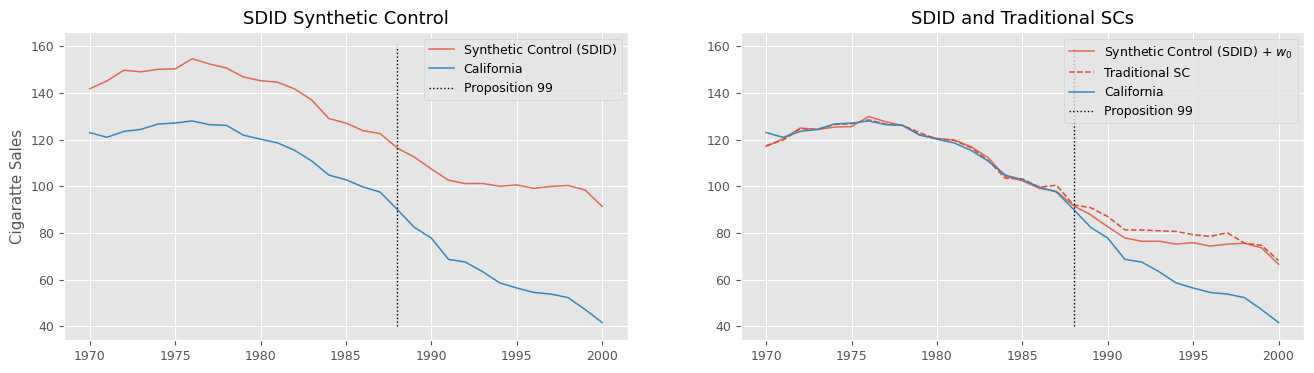

In [24]:
intercept = -24.75035353644767
sc_did = data_piv.drop(columns="california").values @ unit_weights.values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(data_piv.index, sc_did, label="Synthetic Control (SDID)", color="C0", alpha=.8)
ax1.plot(data_piv["california"], label="California", color="C1")
ax1.vlines(x=1988, ymin=40, ymax=160, linestyle=":", lw=1, label="Proposition 99", color="black")

ax1.legend()
ax1.set_title("SDID Synthetic Control")
ax1.set_ylabel('Cigaratte Sales');

ax2.plot(data_piv.index, sc_did+intercept, label="Synthetic Control (SDID) + $w_0$", color="C0", alpha=.8)
ax2.plot(data_piv.index, sc, label="Traditional SC", color="C0", ls="dashed")
ax2.plot(data_piv["california"], label="California", color="C1")
ax2.vlines(x=1988, ymin=40, ymax=160, linestyle=":", lw=1, label="Proposition 99", color="black")
ax2.legend()
ax2.set_title("SDID and Traditional SCs");

As we can see in the first plot, the obvious difference is that this new synthetic control is no longer on top of California. That's because we've included an intercept, which allows the treated unit to be on an arbitrarily different level than its synthetic control. This new Synthetic Control method is built to have the same pretreatment trend as the treated unit, but not necessarily the same level.

In the second plot, we shift this new SC by adding back the intercept we've removed earlier. This puts it on top of the treated unit, California. For comparison, we show the traditional SC we've fitted earlier as the red dashed line. Notice that they are not the same. This difference comes both from the fact that we allowed for an intercept and from the $L_2$ penalty, which pushed the weights towards zero.

Now that we have both time $\hat{\lambda}_t$ and unit $\hat{w}_t$ weights, we can proceed to running the Diff-in-Diff part of the Synthetic DiD estimator. For this part, it is better if we work with the data in the format of a table with $N$ by $T$ rows, where we have columns for the states, the years, the outcome, the post-treatment indicator and the treated unit indicator. To that table, we will add the time and unit weights. Since the time weight is in a series with a time index and the unit weights is in another series with unit index, we can simply join everything together.

In [25]:
def join_weights(data, unit_w, time_w, year_col, state_col, treat_col, post_col):
    return (data
            .set_index([year_col, state_col])
            .join(time_w)
            .join(unit_w)
            .reset_index()
            .fillna({time_w.name: 1 / len(pd.unique(data.query(f"{post_col}")[year_col])),
                     unit_w.name: 1 / len(pd.unique(data.query(f"{treat_col}")[state_col]))})
            .assign(**{"weights":lambda d: (d[time_w.name] * d[unit_w.name]).round(10)})
            .astype({treat_col: int, post_col: int}))

This joining process will leave `null` for the unit weights in the treated group and for the time weights in the post-treatment period. Fortunately, because we use uniform weighting in both cases, it is pretty easy to fill out those `null`s. For the time weights, we fill with the average of the post-treatment dummy, which will be $1/T_{post}$; for the unit weights, we fill with the average of the treated dummy, which will be $1/N_{tr}$. Finally, we multiply both weights together.

Here is the result we get by running this code on the Proposition 99 data:

In [26]:
did_data = join_weights(data, unit_weights, time_weights,
                        year_col="year",
                        state_col="state",
                        treat_col="treated",
                        post_col="after_treatment")

did_data.head()

,year,state,cigsale,treated,after_treatment,time_weights,unit_weights,weights
0,1970,1,89.800003,0,0,-4.600040e-14,-1.360745e-16,0.0
1,1971,1,95.400002,0,0,-4.582323e-14,-1.360745e-16,0.0
2,1972,1,101.099998,0,0,-5.274200e-14,-1.360745e-16,0.0
3,1973,1,102.900002,0,0,-5.766361e-14,-1.360745e-16,0.0
4,1974,1,108.199997,0,0,-5.617983e-14,-1.360745e-16,0.0


Finally, all we have to do is estimate a Diff-in-Diff model with the weights we've just defined. The parameter estimate associated with the interaction term for the post-treatment period and treated dummy will be the Synthetic Difference-in-Differences estimate for the $ATT$.

In [27]:
did_model = smf.wls("cigsale ~ after_treatment*treated",
                    data=did_data,
                    weights=did_data["weights"]+1e-10).fit()

print(did_model.summary().tables[1])

                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 120.4060      1.272     94.665      0.000     117.911     122.901
after_treatment           -19.1905      1.799    -10.669      0.000     -22.720     -15.661
treated                   -25.2601      1.799    -14.043      0.000     -28.789     -21.731
after_treatment:treated   -15.6054      2.544     -6.135      0.000     -20.596     -10.615


This estimate is much smaller than the one we get with Diff-in-Diff, but that is not surprising. As we've already discussed, the Diff-in-Diff estimator is probably biased in this case, since we have pretty good reasons to question the parallel trends assumption. What is perhaps less obvious is why the SDID estimate is smaller than the traditional SC estimate. If we go back and look at the SC plot, we can see that cigarette sales in California started to fall below its synthetic control prior to Proposition 99. This is probably due to the fact that traditional Synthetic Control has to match treated and control units in the entire pre-treatment period, causing it to miss one year or the other. This is less of an issue in SDID, since the time weights allow us to focus just on the periods that are more similar to the post-intervention period. In this case, those were precisely the three years anteceding Proposition 99.

To grasp what SDID is doing, we can plot the Diff-in-Diff lines for the treated (California) and the SDID Synthetic Control. Notice how we are projecting the trend we see in the synthetic control onto the treated unit to get the counterfactual $Y(0)_{tr, post}$. The difference between the dashed purple line and the lower solid purple line is the $ATT$. We start those lines in 1987 to show how the time weights zero out all periods but 1986, 87 and 88. The time weights are also shown in the small plot down below.

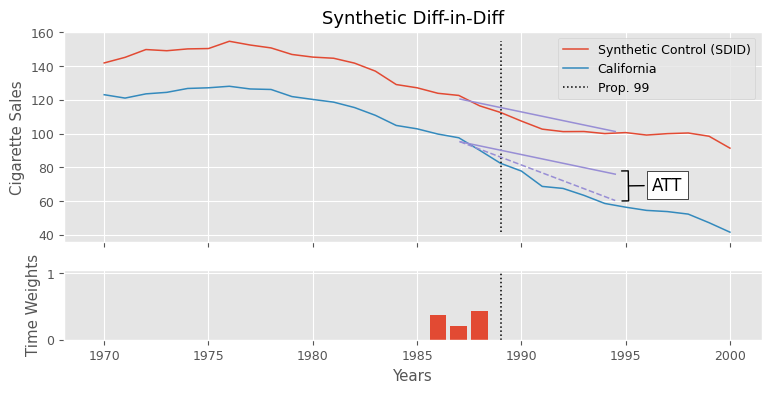

In [28]:
avg_pre_period = (time_weights * time_weights.index).sum()
avg_post_period = 1989 + (2000 - 1989) / 2

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,4), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(data_piv.index, sc_did, label="Synthetic Control (SDID)")
ax1.plot(data_piv.index, data_piv["california"], label="California")
ax1.vlines(1989, data_piv["california"].min(), sc_did.max(), color="black", ls="dotted", label="Prop. 99")

pre_sc = did_model.params["Intercept"]
post_sc = pre_sc + did_model.params["after_treatment"]
pre_treat = pre_sc + did_model.params["treated"]
post_treat = post_sc + did_model.params["treated"] + did_model.params["after_treatment:treated"]

sc_did_y0 = pre_treat + (post_sc - pre_sc)

ax1.plot([avg_pre_period, avg_post_period], [pre_sc, post_sc], color="C2")
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, post_treat], color="C2", ls="dashed")
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, sc_did_y0], color="C2")

ax1.annotate('ATT', xy=(1995, 69), xytext=(1997, 64),
            fontsize=12, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', color='k'),
            arrowprops=dict(arrowstyle='-[, widthB=0.9, lengthB=0.4', lw=1.0, color='k'))

ax1.legend()
ax1.set_title("Synthetic Diff-in-Diff")
ax1.set_ylabel("Cigarette Sales")

ax2.bar(time_weights.index, time_weights)
ax2.vlines(1989, 0, 1, color="black", ls="dotted")
ax2.set_ylabel("Time Weights")
ax2.set_xlabel("Years");

The above estimator estimates the $ATT$ which is the effect of Propostion 99 on California averaged out across all post-treatment time periods. But, from the above plot, it looks like the effect increases over time. What if we want to take that into account? Fortunately, it is very straightforward to do that.

Before we move on, just a word of caution about the above estimator. You should **not** trust the standard errors or confidence intervals reported by the regression we just ran. They don't reflect the variance in estimating the weights. We will take a look at how to do proper inference briefly, but first, let's see how to deal with effect heterogeneity across time.

## Time Effect Heterogeneity and Staggered Adoption

Fortunately, it is incredibly easy to estimate one effect for each time period using SDID. All we have to do is run it multiple times, one for each time period. To be more precise, let's say we have the following treatment assignment matrix, with just 4 time periods and 3 units. The last unit is the treated one.

$$
D = \begin{bmatrix}
    0_1 & 0_1 & 0_1 \\
    0_2 & 0_2 & 0_2 \\
    0_3 & 0_3 & 1_3 \\
    0_4 & 0_4 & 1_4 \\
\end{bmatrix}
$$

Running SDID with the above matrix would give us the average $ATT$ across periods 3 and 4. What we can do to estimate the effect on each period individually is simply to partition the problem into two, one for each post-treatment time period. Then, we run SDID on the data where we only keep post-treatment period 3 and again on the data where we only keep post-treatment period 4. That is, we run SDID on each of the following matrices individually.

$$
D_1 = \begin{bmatrix}
    0_1 & 0_1 & 0_1 \\
    0_2 & 0_2 & 0_2 \\
    0_3 & 0_3 & 1_3 \\
\end{bmatrix}
$$


$$
D_2 = \begin{bmatrix}
    0_1 & 0_1 & 0_1 \\
    0_2 & 0_2 & 0_2 \\
    0_4 & 0_4 & 1_4 \\
\end{bmatrix}
$$

To do that, it would be best if we first merge all the steps of SDID into a single function. That is, estimating the unit and time weights and running DiD.

In [29]:
def synthetic_diff_in_diff(data, outcome_col, year_col, state_col, treat_col, post_col):

    # find the unit weights
    unit_weights = fit_unit_weights(data,
                                    outcome_col=outcome_col,
                                    year_col=year_col,
                                    state_col=state_col,
                                    treat_col=treat_col,
                                    post_col=post_col)

    # find the time weights
    time_weights = fit_time_weights(data,
                                    outcome_col=outcome_col,
                                    year_col=year_col,
                                    state_col=state_col,
                                    treat_col=treat_col,
                                    post_col=post_col)

    # join weights into DiD Data
    did_data = join_weights(data, unit_weights, time_weights,
                            year_col=year_col,
                            state_col=state_col,
                            treat_col=treat_col,
                            post_col=post_col)

    # run DiD
    formula = f"{outcome_col} ~ {post_col}*{treat_col}"
    did_model = smf.wls(formula, data=did_data, weights=did_data["weights"]+1e-10).fit()

    return did_model.params[f"{post_col}:{treat_col}"]

synthetic_diff_in_diff(data,
                       outcome_col="cigsale",
                       year_col="year",
                       state_col="state",
                       treat_col="treated",
                       post_col="after_treatment")

np.float64(-15.60539723458704)

Now that we have a way of easily running SDID, we can run it multiple times, filtering out all the post-treatment periods except the one for which we want the effect.

In [30]:
effects = {year:synthetic_diff_in_diff(data.query(f"~after_treatment|(year=={year})"),
                                       outcome_col="cigsale",
                                       year_col="year",
                                       state_col="state",
                                       treat_col="treated",
                                       post_col="after_treatment")
for year in range(1989, 2001)}

effects = pd.Series(effects)

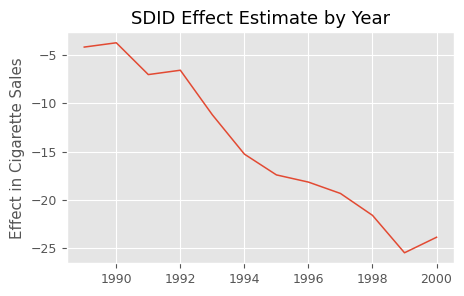

In [34]:
plt.figure(figsize=(5,3))
plt.plot(effects);
plt.ylabel("Effect in Cigarette Sales")
plt.title("SDID Effect Estimate by Year");

As expected, the effect gets bigger as time passes. It starts small, but it gradually increases to what seems like a decrease in consumption of 25 cigarette packs per capita in 2020.

Conveniently, running multiple SDID will also be important to deal with the staggered adoption case. With staggered addoption design, we have multiple treated units, which get the treatment at different time periods. For example, going back to our very simple assignment matrix, with 3 units and 4 time periods, let's say unit 1 never gets the treatment, unit 2 gets the treatment at period 4 and unit 3 gets the treatment at period 3. This would result in the following matrix

$$
D = \begin{bmatrix}
    0_1 & 0_1 & 0_1 \\
    0_2 & 0_2 & 0_2 \\
    0_3 & 0_3 & 1_3 \\
    0_4 & 1_4 & 1_4 \\
\end{bmatrix}
$$

Notice that SDID can't handle that matrix, because we don't have a clear definition about what is a pre-treatment period (before time 4, in the case of the second unit or before period 3, in the case of the second unit) or what is a control unit (unit 2 could be a control for the treatment starting at period 3). The key in solving this is realizing we can delete columns (units) or rows (time periods) in that matrix in order to go back to the block assignment design.

For example, we can create two block matrices from the one above by first deleting the 3rd time period and then another one where we delete the 4th time period.

$$
D_1 = \begin{bmatrix}
    0_1 & 0_1 & 0_1 \\
    0_2 & 0_2 & 0_2 \\
    0_4 & 1_4 & 1_4 \\
\end{bmatrix}
$$

$$
D_2 = \begin{bmatrix}
    0_1 & 0_1 & 0_1 \\
    0_2 & 0_2 & 0_2 \\
    0_3 & 0_3 & 1_3 \\
\end{bmatrix}
$$


The result is two block matrices, which means we can run SDID in both of them. The result will be two $ATT$ estimates, which we can then combine with a weighted average, where the weights are the proportion of treated time and periods in each block. In our example, the weight for $ATT_1$ would be $2/3$ and the weight for $ATT_2$ would be 1/3.

Alternatively, we could also have 2 block designs by removing columns, which would result in the following matrices

$$
D_1 = \begin{bmatrix}
    0_1 & 0_1  \\
    0_2 & 0_2  \\
    0_3 & 0_3  \\
    0_4 & 1_4  \\
\end{bmatrix}
$$

$$
D_2 = \begin{bmatrix}
    0_1 & 0_1 \\
    0_2 & 0_2 \\
    0_3 & 1_3 \\
    0_4 & 1_4 \\
\end{bmatrix}
$$

where $D_1$ has units 1 and 2 and $D_2$ has units 1 and 4.

Since we already saw how to estimate SDID for different time periods, let's look at this approach where we filter out units. Since we don't originally have a staggered adoption design in our Proposition 99 data, let's instead simulate one. We'll create 3 new states from our data and pretend they pass a law similar to Proposition 99, but in the year 1993. Maybe they were impressed with the results in California and wanted to try in their states too. Once they do, this law that they pass decreases cigarette consumption by 3% each year. We can visualize the average cigarette consumption for those  new states to better understand what is going on. In dashed black, we have the year in which these states pass this anti-tobacco law.

In [36]:
np.random.seed(1)
n = 3
tr_state = (data
            .query(f"state.isin({list(np.random.choice(data['state'].unique(), n))})")
            .assign(**{
                "treated": True,
                "state": lambda d: "new_" + d["state"].astype(str),
                "after_treatment": lambda d: d["year"] > 1992
            })
            # effect of 3% / year
            .assign(**{"cigsale": lambda d: np.random.normal(d["cigsale"] -
                                                             d["cigsale"]*(0.03*(d["year"] - 1992))*d["after_treatment"], 1)}))

new_data = pd.concat([data, tr_state]).assign(**{"after_treatment": lambda d: np.where(d["treated"], d["after_treatment"], False)})

In [38]:
new_data.tail()

,state,year,cigsale,treated,after_treatment
1173,new_38,1996,82.246917,True,True
1174,new_38,1997,78.300158,True,True
1175,new_38,1998,72.358713,True,True
1176,new_38,1999,66.037271,True,True
1177,new_38,2000,61.299493,True,True


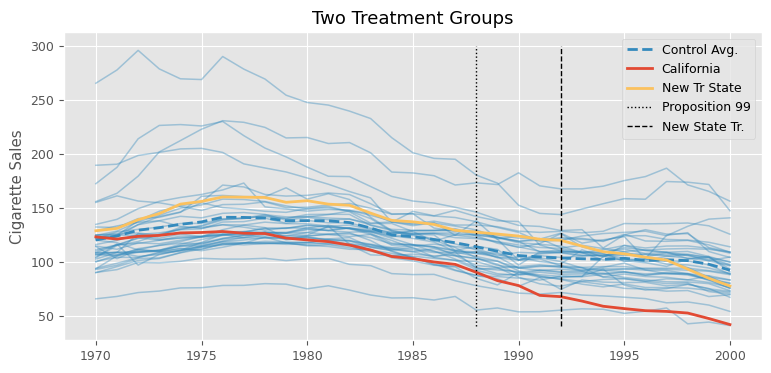

In [42]:
new_data_piv = new_data.pivot(index="year", columns="state", values="cigsale")

new_tr_states = list(filter(lambda c: str(c).startswith("new"), new_data_piv.columns))

plt.figure(figsize=(9, 4))
plt.plot(new_data_piv.drop(columns=["california"]+new_tr_states), color="C1", alpha=0.4)
plt.plot(new_data_piv.drop(columns=["california"]+new_tr_states).mean(axis=1), lw=2,
         color="C1", ls="dashed", label="Control Avg.")

plt.plot(new_data_piv["california"], color="C0", label="California", lw=2)
plt.plot(new_data_piv[new_tr_states].mean(axis=1), color="C4", label="New Tr State", lw=2)

plt.vlines(x=1988, ymin=40, ymax=300, linestyle=":", lw=1, label="Proposition 99", color="black")
plt.vlines(x=1992, ymin=40, ymax=300, linestyle="dashed", lw=1, label="New State Tr.", color="black")
plt.legend()
plt.ylabel("Cigarette Sales")
plt.title("Two Treatment Groups");

We finally have this staggered adoption data. Now, we need to figure out how to filter out some states so we can break the problem into multiple block assignment cases. First, we can group states by when they passed the law. The following code does exactly that.

In [50]:
assignment_blocks = (new_data.query("treated & after_treatment")
                                                   .groupby("state")["year"].min()
                                                   .reset_index()
                                                   .groupby("year")["state"].apply(list).to_dict())

assignment_blocks

{1989: ['california'], 1993: ['new_13', 'new_38', 'new_9']}

As you can see, we have two groups of states. One with only California, which was treated starting in 1989, and another with the three new states we've created, which were all treated starting in 1993. Now, we need to run SDID for each of those groups. We can easily do that, but keeping just the control units plus one of those groups. There is a catch, though. The `after_treatment` column will have a different meaning, depending on which group we are looking at. If we are looking at the group containing only California, `after_treatment` should be `year >= 1989`; if we are looking at the group with the new states, it should be `year >= 1993`. Fortunately, this is pretty easy to account for. All we need is to recreate the `after_treatment` in each iteration.

In [51]:
staggered_effects = {year: synthetic_diff_in_diff(new_data
                                                  .query(f"~treated|(state.isin({states}))")
                                                  .assign(**{"after_treatment": lambda d: d["year"] >= year}),
                                                  outcome_col="cigsale",
                                                  year_col="year",
                                                  state_col="state",
                                                  treat_col="treated",
                                                  post_col="after_treatment")
for year, states in assignment_blocks.items()}

staggered_effects

{1989: np.float64(-15.60539723458704), 1993: np.float64(-17.249435402003723)}

Not surprisingly, the $ATT$ estimate for the first group, the one with only California, is exactly the same as the one we've seen before. The other $ATT$ refers to the one we get with the new group of states. We have to combine them into a single $ATT$. This can be done with the weighted average we've explained earlier.

First, we calculate the number of treated entries (`after_treatment & treated`) in each block. Then, we combine the $ATT$s using those weights.

In [52]:
weights = {year: sum( (new_data["year"] >= year) & (new_data["state"].isin(states)) )
                for year, states in assignment_blocks.items()}

att = sum( [ effect*weights[year]/sum(weights.values()) for year, effect in staggered_effects.items() ] )

print("weights:", weights)
print("ATT:", att)

weights: {1989: 12, 1993: 24}
ATT: -16.701422679531497


Here, we have a total of 36 treatment instances: the usual 12 post-treatment periods for California plus 8 treatment periods (1993-2000) for each of the three new treatment states we've introduced. With that in mind, the weight for the first $ATT$ is $12/36$ and for the second $ATT$, $24/36$, which combines to the result above.

## Placebo Variance Estimation

This chapter is getting a bit too long, but there is one promise we haven't fulfilled yet. Remember how we said, in the very beginning, that SDID has better precision (lower error bars) when compared to Synthetic Controls? The reason is that the time and unit fixed effects in SDID capture a ton of the variation in the outcome, which in turn, reduces the variance of the estimator.

Of course I wouldn't ask you to take my word for it, so next, we'll show how to place a confidence interval around the SDID estimate. It turns out there are many solutions to this problem, but only one that fits the case for a single treated unit, which is the case we have here since only California was treated. The idea is to run a series of placebo tests, where we pretend a unit from the control pool is treated, when it actually isn't. Then, we use SDID to estimate the $ATT$ of this placebo test and store its result. We re-run this step multiple times, sampling a control unit each time. In the end, we will have an array of placebo $ATT$s. The variance of this array is the placebo variance of the SDID effect estimate, which we can use to construct a confidence interval.

$$
\hat{V}^{placebo}_{\tau} = B^{-1}\sum_{b=1}^B\bigg(\hat{\tau}^{(b)} - \bar{\hat{\tau}}^{(b)}\bigg)^2
$$

$$
\tau \in \hat{\tau}^{sdid} \pm \mathcal{z}_{\alpha/2} \sqrt{\hat{V}_{\tau}}
$$

In order to implement this, the first thing we need is a function which creates the placebo. This function will filter out the treated units, sample a single control unit and flip the `treated` column for that control unit from 0 to a 1.

In [53]:
def make_random_placebo(data, state_col, treat_col):
    control = data.query(f"~{treat_col}")
    states = control[state_col].unique()
    placebo_state = np.random.choice(states)
    return control.assign(**{treat_col: control[state_col] == placebo_state})

In [58]:
np.random.seed(1)
placebo_data = make_random_placebo(data, state_col="state", treat_col="treated")

placebo_data.query("treated").tail()

,state,year,cigsale,treated,after_treatment
1204,39,1996,110.300003,True,True
1205,39,1997,108.800003,True,True
1206,39,1998,102.900002,True,True
1207,39,1999,104.800003,True,True
1208,39,2000,90.500000,True,True


In the example above, we've sampled state 39 and we are now pretending that it was treated. Notice how the `treated` column was flipped to `True`.

The next thing we need is to compute the SDID estimate with this placebo data and repeat that a bunch of times. The next function does that. It runs the `synthetic_diff_in_diff` function to get the SDID estimate, but instead of passing the usual data, we pass the result of calling `make_random_placebo`. We do that multiple times to get an array of SDID estimates and, finally, compute the square root of the variance of this array, which is just the standard deviation.

In [59]:
from joblib import Parallel, delayed # for parallel processing

def estimate_se(data, outcome_col, year_col, state_col, treat_col, post_col, bootstrap_rounds=400, seed=0, njobs=4):
    np.random.seed(seed=seed)

    sdid_fn = partial(synthetic_diff_in_diff,
                      outcome_col=outcome_col,
                      year_col=year_col,
                      state_col=state_col,
                      treat_col=treat_col,
                      post_col=post_col)

    effects = Parallel(n_jobs=njobs)(delayed(sdid_fn)(make_random_placebo(data, state_col=state_col,
                                                                          treat_col=treat_col))
    for _ in range(bootstrap_rounds))

    return np.std(effects, axis=0)

In [60]:
effect = synthetic_diff_in_diff(data,
                                outcome_col="cigsale",
                                year_col="year",
                                state_col="state",
                                treat_col="treated",
                                post_col="after_treatment")

se = estimate_se(data,
                 outcome_col="cigsale",
                 year_col="year",
                 state_col="state",
                 treat_col="treated",
                 post_col="after_treatment")

The standard deviation can then be used to construct confidence intervals much like we described in the formula above.

In [61]:
print(f"Effect: {effect}")
print(f"Standard Error: {se}")
print(f"90% CI: ({effect-1.65*se}, {effect+1.65*se})")

Effect: -15.60539723458704
Standard Error: 9.912089736240306
90% CI: (-31.96034529938354, 0.7495508302094631)


Notice that the $ATT$ is not significant in this case, but what's more interesting here is to compare the standard error of the SDID estimate with the one we get from traditional Synthetic Control.

In [63]:
def synthetic_control(data, outcome_col, year_col, state_col, treat_col, post_col):

    x_pre_control = (data
                     .query(f"~{treat_col}")
                     .query(f"~{post_col}")
                     .pivot(index=year_col, columns=state_col, values=outcome_col)
                     .values)

    y_pre_treat_mean = (data
                        .query(f"~{post_col}")
                        .query(f"{treat_col}")
                        .groupby(year_col)
                        [outcome_col].mean())

    w = cp.Variable(x_pre_control.shape[1])
    objective = cp.Minimize(cp.sum_squares(x_pre_control@w - y_pre_treat_mean.values))
    constraints = [cp.sum(w) == 1, w >= 0]

    problem = cp.Problem(objective, constraints)
    problem.solve(verbose=False)

    sc = (data
          .query(f"~{treat_col}")
          .pivot(index=year_col, columns=state_col, values=outcome_col).values) @ w.value

    y1 = data.query(f"{treat_col}").query(f"{post_col}")[outcome_col]
    att = np.mean(y1 - sc[-len(y1):])

    return att

def estimate_se_sc(data, outcome_col, year_col, state_col, treat_col, post_col, bootstrap_rounds=400, seed=0):
    np.random.seed(seed=seed)
    effects = [synthetic_control(make_random_placebo(data, state_col=state_col, treat_col=treat_col),
                                 outcome_col=outcome_col,
                                 year_col=year_col,
                                 state_col=state_col,
                                 treat_col=treat_col,
                                 post_col=post_col)
    for _ in range(bootstrap_rounds)]

    return np.std(effects, axis=0)

effect_sc = synthetic_control(data,
                              outcome_col="cigsale",
                              year_col="year",
                              state_col="state",
                              treat_col="treated",
                              post_col="after_treatment")

se_sc = estimate_se_sc(data,
                       outcome_col="cigsale",
                       year_col="year",
                       state_col="state",
                       treat_col="treated",
                       post_col="after_treatment")

In [64]:
print(f"Effect: {effect_sc}")
print(f"Standard Error: {se_sc}")
print(f"90% CI: ({effect_sc-1.65*se_sc}, {effect_sc+1.65*se_sc})")

Effect: -19.51362976399856
Standard Error: 11.241927832796224
90% CI: (-38.06281068811232, -0.9644488398847919)


Notice how the error for synthetic control is higher than for SDID. Again, that is because SDID captures a lot of the variance in the outcome via its time and unit fixed effects. With this, we fulfill the promise we made earlier. But, before we close, it is worth mentioning that we can also use the same procedure to estimate the variance to make a confidence interval around the effect we've estimated for each post-treatment time period. All we need to do is run the code above once for each time period. Just keep in mind that this might take some time to run, even with the parallelization we've implemented.

In [65]:
standard_errors = {year: estimate_se(data.query(f"~after_treatment|(year=={year})"),
                                     outcome_col="cigsale",
                                     year_col="year",
                                     state_col="state",
                                     treat_col="treated",
                                     post_col="after_treatment")
for year in range(1989, 2001)}

standard_errors = pd.Series(standard_errors)

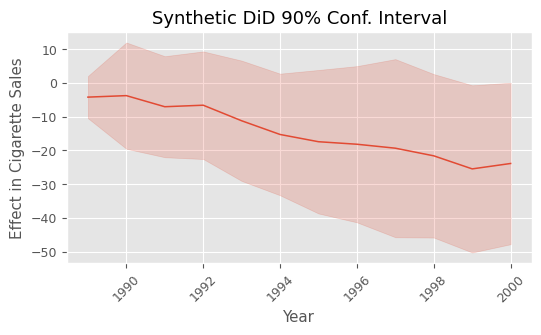

In [69]:
plt.figure(figsize=(6, 3))

plt.plot(effects, color="C0")
plt.fill_between(effects.index, effects-1.65*standard_errors, effects+1.65*standard_errors, alpha=0.2, color="C0")

plt.ylabel("Effect in Cigarette Sales")
plt.xlabel('Year')
plt.title("Synthetic DiD 90% Conf. Interval")
plt.xticks(rotation=45);

## Key Concepts

Synthetic-Diff-in-Diff (SDID) draws inspiration from both Diff-in-Diff and Synthetic Control, which brings advantages from both models.  Like SC, SDID still works with multiple periods when pre-treatment trends are not parallel. However, unlike SC, SDID estimates unit weights to build a control unit which is only parallel to the treated group (it doesn't have to match its level). From DID, SDID leverages time and unit fixed effects, which helps to explain a lot of the variance in the outcome, which in turn reduces the variance of the SDID estimator. Synthetic-Diff-in-Diff also introduces some new ideas of its own. First, there is an additional $L2$ penalty in the optimization of the unit weights which makes them more spread out across control units. Second, SDID allows for an intercept (and hence, extrapolation) when building such weights. Third, SDID introduces the use of time weights, which are not present in either DID nor SC. For this reason, I wouldn't say SDID is just merging SC and SDID. It is rather building something new, inspired by these two approaches. I also wouldn't say that SDID is better or worse than traditional Synthetic Control. Each of them have different properties that might be appropriate or not, depending on the situation. For example, you might find yourself in a situation where allowing the extrapolations from SDID is dangerous. In which case, SC might be a good alternative.  


## References

This chapter is essentially an explainer to the *Synthetic Difference in Differences* (2019) article, by Dmitry Arkhangelsky, Susan Athey, David A. Hirshberg, Guido W. Imbens and Stefan Wager. Additionally, I would love to recognize Masa Asami for his python implementation of SDID, pysynthdid. His code helped me make sure I didn't have any bugs in mine, which was extremely helpful.



# 6 - Conformal Inference for Synthetic Controls


## Synthetic Control Refresher

Synthetic Control (SC) is a particularly useful causal inference technique for when you have a single treatment unit and very few control units, but you have repeated observation of each unit through time (although there are plenty of SC extensions in the Big Data world). The canonical use case is when you want to know the impact of the treatment in one geography (like a state) and you use the other untreated states as controls. In our Synthetic Control chapter, we've motivated the technique by trying to estimate the effect of Proposition 99 (a bill passed in 1988 that increased cigarette tax in California) in cigarette sales.

In order to do that, we have to estimate what would have happened to California, had it not passed Proposition 99. This boils down to estimating the counterfactual $Y_{t}(0)$ so that we can compare it to the observed outcome in the post intervention periods:

$$
ATT = Y_{t}(1) - Y_{t}(0) = Y_{t} - Y_{t}(0)  \text{ for } t \geq 1988
$$

There are many methods to do that, among which, we have Synthetic Controls. Synthetic Controls tries to model $Y(0)$ for the treated unit by combining multiple control units in such a way that they mimic the pre-treatment behavior of the treated unit. In our case, this means finding a combination of states that, together,  approximate the cigarette sales trend in California prior to Proposition 99. This is done because we rarely have a control unit that follows the same pattern as the treatment unit. We can see that by plotting the cigarette sales trend for multiple states. Notice none of them have a trend that closely resembles that of California.

In [9]:
data = pd.read_csv("./data/smoking.csv")

data = data.pivot(index="year", columns="state", values="cigsale")
data = data.rename(columns={c: f"state_{c}" for c in data.columns}).rename(columns={"state_3":"california"})
data.shape

(31, 39)

In [10]:
data.head()

state,state_1,state_2,california,state_4,state_5,state_6,state_7,state_8,state_9,state_10,...,state_30,state_31,state_32,state_33,state_34,state_35,state_36,state_37,state_38,state_39
year,,,,,,,,,,,,,,,,,,,,,
1970,89.800003,100.300003,123.000000,124.800003,120.000000,155.000000,109.900002,102.400002,124.800003,134.600006,...,103.599998,92.699997,99.800003,106.400002,65.500000,122.599998,124.300003,114.500000,106.400002,132.199997
1971,95.400002,104.099998,121.000000,125.500000,117.599998,161.100006,115.699997,108.500000,125.599998,139.300003,...,115.000000,96.699997,106.300003,108.900002,67.699997,124.400002,128.399994,111.500000,105.400002,131.699997
1972,101.099998,103.900002,123.500000,134.300003,110.800003,156.300003,117.000000,126.099998,126.599998,149.199997,...,118.699997,103.000000,111.500000,108.599998,71.300003,138.000000,137.000000,117.500000,108.800003,140.000000
1973,102.900002,108.000000,124.400002,137.899994,109.300003,154.699997,119.800003,121.800003,124.400002,156.000000,...,125.500000,103.500000,109.699997,110.400002,72.699997,146.800003,143.100006,116.599998,109.500000,141.199997
1974,108.199997,109.699997,126.699997,132.800003,112.400002,151.300003,123.699997,125.599998,131.899994,159.600006,...,129.699997,108.400002,114.800003,114.699997,75.599998,151.800003,149.600006,119.900002,111.800003,145.800003


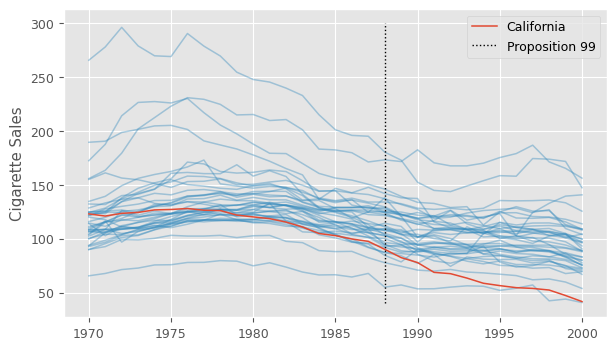

In [13]:
plt.figure(figsize=(7,4))
plt.plot(data.drop(columns=["california"]), color="C1", alpha=0.4)
plt.plot(data["california"], color="C0", label="California")
plt.vlines(x=1988, ymin=40, ymax=300, linestyle=":", lw=1, label="Proposition 99", color="black")
plt.legend()
plt.ylabel("Cigarette Sales");

That is why we combine multiple treated units. The goal is, if we don't have a good enough control, we can craft a synthetic one that resembles the treated unit the way we want.

In order to find the combination of states that better approximate the pretreatment trend of California, the Synthetic Control method runs a horizontal regression, where the rows are the time periods and the columns are the states. It tries to find the weights that, when multiplied by the control states, better approximate the treated state

Since we have more states (39, some were discarded from the analysis) than time periods, an unconstrained regression would simply overfit, which is why Synthetic Control imposes two restrictions:

1. Weights must sum to 1;
2. Weights must be non-negative;

Or, in mathematical terms, let $\pmb{y}$ be the vector of outcomes for the treated state in the pre-treated periods, $\pmb{X}$ the $J$ by $T0$ matrix, where each column is a state $j$ and each row is a period $t$ prior to the intervention period, $T1 = T0 + 1$

$$
\underset{w}{\mathrm{argmin}} \ ||\pmb{y} - \pmb{X} \pmb{w}|| \\
\text{s.t } \ \sum w_j = 1 \text{ and } \ w_j > 0 \ \forall \ j
$$

Combined, these constraints means we are defining the synthetic control as a convex combination of the control units. It also means we are not doing any dangerous extrapolation and that our synthetic control will use only a small subset of control units.

Here is what this looks like in code, as an Sklearn estimator:

In [14]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
import cvxpy as cp

class SyntheticControl(BaseEstimator, RegressorMixin):

    def __init__(self,):
        pass

    def fit(self, X, y):

        X, y = check_X_y(X, y)

        w = cp.Variable(X.shape[1])
        objective = cp.Minimize(cp.sum_squares(X@w - y))

        constraints = [cp.sum(w) == 1, w >= 0]

        problem = cp.Problem(objective, constraints)
        problem.solve(verbose=False)

        self.X_ = X
        self.y_ = y
        self.w_ = w.value

        self.is_fitted_ = True
        return self

    def predict(self, X):

        check_is_fitted(self)
        X = check_array(X)

        return X @ self.w_

Let's apply this method to our data, fitting it in the pre-intervention period (prior to 1988).

In [15]:
model = SyntheticControl()

train = data[data.index < 1988]

model.fit(train.drop(columns=["california"]), train["california"]);

We can now plot, side by side the trend for California and for the synthetic control we've just created. The difference between these two lines is the estimated effect of Proposition 99 in California.

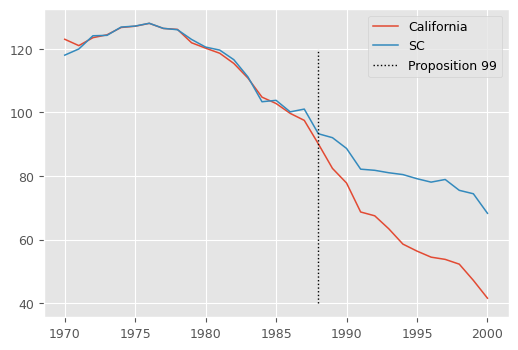

In [21]:
plt.figure(figsize=(6,4))
plt.plot(data["california"], label="California")
plt.plot(data["california"].index, model.predict(data.drop(columns=["california"])), label="SC")
plt.vlines(x=1988, ymin=40, ymax=120, linestyle=":", lw=1, label="Proposition 99", color="black")

plt.legend();

From the look of this plot, it looks like Proposition 99 had a pretty big effect on the reduction of cigarette sales.

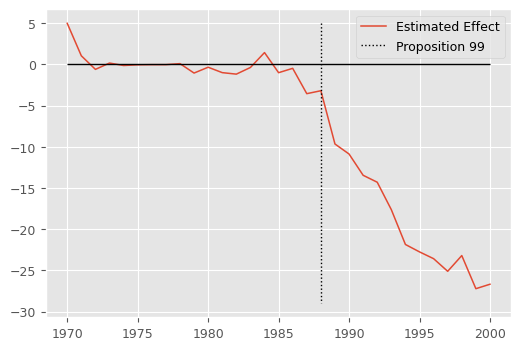

In [23]:
plt.figure(figsize=(6,4))
pred_data = data.assign(**{"residuals":data["california"] - model.predict(data.drop(columns=["california"]))})

plt.plot(pred_data["california"].index, pred_data["residuals"], label="Estimated Effect")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=1, color="Black")
plt.vlines(x=1988, ymin=5, ymax=-29, linestyles=":", lw=1, label="Proposition 99", color="Black")
plt.legend();

## Inference for Grown Ups

In the Synthetic Control chapter, we showed an inference procedure where we've permuted units, pretending control units where treated. This is also referred to as a placebo test, where we check the effect of units that haven't gone through the treatment. If the estimated effect in the treated unit is bigger than most of the placebo effects, we say that this effect estimate is significant.

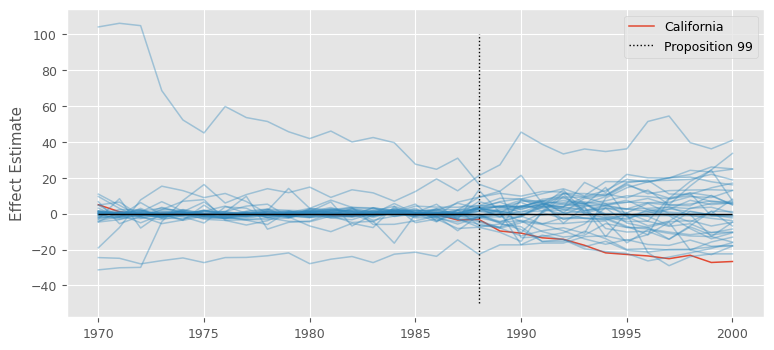

In [24]:
plt.figure(figsize=(9, 4))

for state in data.columns:

    model_iter = SyntheticControl()
    train_iter = data[data.index < 1988]
    model_iter.fit(train_iter.drop(columns=[state]), train_iter[state])

    effect = data[state] - model_iter.predict(data.drop(columns=[state]))

    is_california = (state == "california")

    plt.plot(effect, color="C0" if is_california else "C1",
             alpha=1 if is_california else 0.4,
             label="California" if is_california else None)

plt.hlines(y=0, xmin=1970, xmax=2000, lw=1, color="Black")
plt.vlines(x=1988, ymin=-50, ymax=100, linestyle=":", lw=1, label="Proposition 99", color="Black")
plt.ylabel("Effect Estimate")
plt.legend();

In our example, we can see that the post-treatment difference for California is quite extreme, when compared to the other states. However, there are also some states with terrible pre-treatment fit, which then translates to a huge error in the post-intervention period. The guideline here is to remove units with high pretreatment error, but how high is a bit more complicated. Not only that, this procedure assumes a random assignment of the intervention, which is hard to believe for this kind of policy intervention (see Abadie, 2021)

One alternative method for inference is to recast the problem of effect estimation as counterfactual prediction. If you think about it, all we are trying to do is predict the counterfactual $Y_{i, t}(0)$ where $i$ is the treated unit and $t \geq T1$, that is, in the post intervention period. If we do that, we can leverage the literature on **Conformal Prediction for inference**. Interestingly enough, this method is quite general and applies to other models of $Y_{i, t}(0)$ but let's focus just on Synthetic Controls here.

To understand this procedure, let's first look at how we would do Hypothesis Tests and get P-Values.

### Hypothesis Test and P-Values

Let's say we are interested in testing the Hypothesis about the trajectory of effects in the post treatment period $\theta = (\theta_{T0+1}, ..., \theta_{T})$

$$
H_0 : \theta = \theta^0
$$

For instance, if we wish to test for no effect whatsoever, we can set $\theta^0 = (0, ..., 0)$. Notice that this hypothesis fully determines the counterfactual outcome in the absence of treatment:

$$
Y_t(0) = Y_t(1) - \theta_t = Y_t - \theta_t
$$

The key idea is to then generate data following the null hypothesis we want to test and check the residuals of a model for $Y(0)$ in this generated data. If the residuals are too extreme, we say that the data is unlikely to have come from the null hypothesis we've postulated. If this whole procedure sounds obscure at first, don't worry, it will become clear as we walk through a step by step implementation of it.

The first step is to generate data under the null hypothesis. This is achieved by simply subtracting the postulated null from the outcome of the treated unit, just like in the equation above. Here is the code to do that.

In [27]:
def with_effect(df, state, null_hypothesis, start_at, window):
    window_mask = (df.index >= start_at) & (df.index < (start_at + window))

    y = np.where(window_mask, df[state] - null_hypothesis, df[state])

    return df.assign(**{state: y})

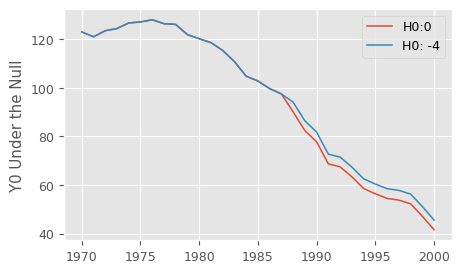

In [29]:
plt.figure(figsize=(5, 3))
plt.plot(with_effect(data, "california", 0, 1988, 2000-1988+1)["california"], label="H0:0")
plt.plot(with_effect(data, "california", -4, 1988, 2000-1988+1)["california"], label="H0: -4")

plt.ylabel("Y0 Under the Null")
plt.legend();

If we postulate the null of no effect, the data under that null means that $Y(0) = Y(1) = Y$, which is just the trajectory of observed outcome we see for the treated state of California. Now, if we postulate that the null is -4, that is, Proposition 99 decreases cigarette sales by 4 packs, then $Y(0) = Y(1) - (-4)$, which shifts the trajectory of the post treatment outcomes by +4. This is very intuitive. If we think the bill decreases cigarette sales, then, in the absence of it, we should see higher levels of cigarette sales than the one we have in our observed data.

The next part of the inference procedure is to fit a model for the counterfactual $Y(0)$ (which we get with the function we just created) in the entire data, pre **and** post-treatment period. This is an important distinction between how we usually fit synthetic controls. The idea here is that the model must be estimated with the entire data, under the postulated null hypothesis, to avoid huge post intervention residuals. With this model, we then compute the residuals $\hat{u_t} = Y_t - \hat{Y}_t(0)$ for all time periods $t$.

The function to do that first uses the `with_effect` function we created earlier to generate data under then null. Then, it fits the model in this data under the null. Next, we estimate $Y(0)$ by making predictions with the recently fit model. Finally, we compute the residuals $\hat{u}_t$ and stores everything in a dataframe.

In [30]:
@curry
def residuals(df, state, null, intervention_start, window, model):

    null_data = with_effect(df, state, null, intervention_start, window)

    model.fit(null_data.drop(columns=[state]), null_data[state])

    y0_est = pd.Series(model.predict(null_data.drop(columns=[state])), index=null_data.index)

    residuals = null_data[state] - y0_est

    test_mask = (null_data.index >= intervention_start) & (null_data.index < (intervention_start + window))

    return pd.DataFrame({
        "y0":null_data[state],
        "y0_est":y0_est,
        "residuals":residuals,
        "post_intervention":test_mask
    })[lambda d: d.index < (intervention_start + window)] # just discard points after the defined effect window

With our data, to get the residuals for $H_0 : 0$, meaning Proposition 99 had no effect, we can simply pass 0 as the null for our function.

In [31]:
model = SyntheticControl()

residuals_df = residuals(data,
                         "california",
                         null=0.0,
                         intervention_start=1988,
                         window = 2000-1988+1,
                         model=model)

residuals_df.head()

,y0,y0_est,residuals,post_intervention
year,,,,
1970,123.000000,112.529475,10.470525,False
1971,121.000000,114.315723,6.684277,False
1972,123.500000,119.302289,4.197711,False
1973,124.400002,121.265554,3.134447,False
1974,126.699997,124.356696,2.343301,False


The result is a dataframe containing the estimated residuals for each time period, something we will use going forward. Remember that the idea here is to see if that residual, in the post intervention period, is too high. If it is, the data is unlikely to have come from this null, where the effect is zero. To get a visual idea of what we are talking about, we can inspect the error of our model in the post intervention period.

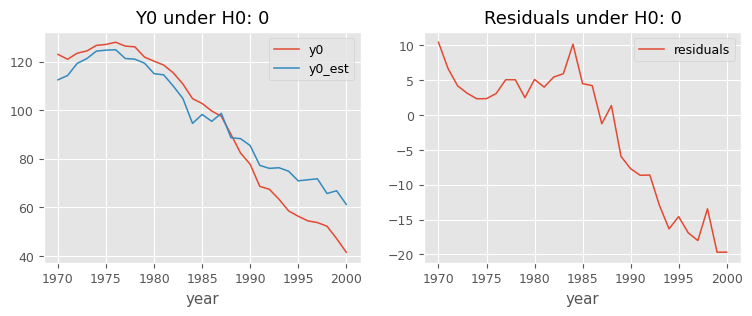

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))

residuals_df[["y0", "y0_est"]].plot(ax=ax1)
ax1.set_title("Y0 under H0: 0")
residuals_df[["residuals"]].plot(ax=ax2)
ax2.set_title("Residuals under H0: 0");

We can already see that the model fitted under $H_0: 0$ yields quite large and negative residuals, which is some evidence we might want to reject this null of no effect.

#### Test Statistic

This visual evidence is interesting for our own understanding, but we need to be a bit more precise here. This is done by the definition of a **Test Statistic S**, which summarizes how big are the residuals and hence, how unikly is the data we saw, under the null.

$$
S(\hat{u})_q = \bigg(\sum_{t=T0 + 1}^{T} |u_t|^q \bigg) ^{1/q}
$$

Here, we focus on $q=1$, which gives us $S(\hat{u}) = \sum_{t=T0 + 1}^{T} |u_t|$.

Notice that this statistic is computed using only the post-intervention period, with $t \geq T0 + 1$. So, although we use all the data to fit our model for the counterfactual $Y(0)$, we check the residuals only for the outcome which concerns the formulated null hypothesis, that is, the post-intervention period.

In [35]:
def test_statistic(u_hat, q=1, axis=0):
    return (np.abs(u_hat) ** q).mean(axis=axis) ** (1/q)

In [36]:
print("H0:0", test_statistic(residuals_df.query("post_intervention")["residuals"]))

H0:0 12.602929955114217


High values of this test statistic indicate poor post intervention fit and, hence rejection of the null. However, we could have pretty big test statistics in the post-intervention period if our model is poorly fitted, even if $H_0$ is true. This means we can't define high in absolute terms. Rather, we have to think about how high are the post intervention residuals - and test statistics - in comparison to the pre-intervention residuals.

#### P-Value

To compute the P-value, we block-permute the residuals, calculating the test statistic in each permutation.

Once we do that, we will end up with $T$ test statistics, one for each of the block permutations.

Let $\Pi$ be the set of all block permutations, by the definition of P-value

$$
\text{P-value} = \frac{1}{|\Pi|}\sum_{\pi \in \Pi} \mathcal{1}\{S(\hat{u}_{\pi_0}) \leq S(\hat{u}_{\pi})\}
$$

and $\hat{u}_{\pi_0}$ is the original (unpermuted) vector or residuals. In plain terms, we are simply finding the proportion of times that the unpermuted test statistic is higher (more extreme) than the test statistics obtained by all possible block permutations.

To implement this, we will make use of the `np.roll` function, which takes an array and circles it, mujustch like we've represented in the image above.

In [37]:
def p_value(resid_df, q=1):

    u = resid_df["residuals"].values
    post_intervention = resid_df["post_intervention"].values

    block_permutations = np.stack([np.roll(u, permutation, axis=0)[post_intervention]
                                   for permutation in range(len(u))])

    statistics = test_statistic(block_permutations, q=1, axis=1)

    p_val = np.mean(statistics >= statistics[0])

    return p_val

We can now compute the P-value for $H_0: 0$. As we can see, it is a low P-value, but not extremely low. At $\alpha=0.1$, we would not reject this null of no effect.

In [39]:
p_value(residuals_df)

np.float64(0.16129032258064516)

Remember, this is the P-value for the null hypothesis which states that the effect in all time periods is zero: $\theta = (\theta_{T0+1}=0, ..., \theta_{T}=0)$. From our effect plot from the Synthetic Control, we get the feeling that the effect of Proposition 99 is not a fixed number. We can see that it starts small, around -5, but gradually increases to -25. For this reason, it might be interesting to plot the confidence interval for effect each post treatment period individually, rather than just testing a null hypothesis about an entire affect trajectory.

### Confidence Intervals

To understand how we can place a confidence interval around the effect of each post-treatment period, let's first try to understand how we would define the confidence interval for a single time period. If we have a single period, then $H_0$ is defined in terms of a scalar value, rather than a trajectory vector $\theta$. This means we can generate a fine line of $H_0s$ and compute the P-value associated with each null. For example, Let's say we think the effect of Proposition 99 in the year 1988 (the year it passed) is somewhere between -20 and 20. We can then build a table containing a bunch of $H_0$, from -20 to 20, and each associated P-value:

```
P-value(H_0: -20) = 0.01
P-value(H_0: -19) = 0.01
P-value(H_0: -18) = 0.02
...
P-value(H_0: 18) = 0.03
P-value(H_0: 19) = 0.03
P-value(H_0: 20) = 0.02
```

With the functions we've defined, this can be achieved by first appending the period of interest (1988 in this example) at the end of the pre-intervention period, creating what is called an augmented dataset. Then, we iterate over the fine line of nulls, computing the p-value of a post-intervention window of size 1, which starts at the period of interest

In [61]:
def p_val_grid(df, state, nulls, intervention_start, period, model):

    df_aug = df[(df.index < intervention_start) | (df.index == period)]

    p_vals =  {null: p_value(residuals(df_aug,
                                       state,
                                       null=null,
                                       intervention_start=period,
                                       window=1,
                                       model=model)) for null in nulls}

    return pd.DataFrame(p_vals, index=[period]).T

In [62]:
model = SyntheticControl()

nulls = np.linspace(-20, 20, 100)

p_values_df = p_val_grid(
    data,
    "california",
    nulls=nulls,
    intervention_start=1988,
    period=1988,
    model=model
)

p_values_df

,1988
-20.000000,0.052632
-19.595960,0.052632
-19.191919,0.052632
-18.787879,0.052632
-18.383838,0.052632
...,...
18.383838,0.052632
18.787879,0.052632
19.191919,0.052632
19.595960,0.052632


As you can see, the result is a table where the row index is the null hypothesis and the row values are the p-values.

To build the confidence interval, all we need to do is filter out the $H_0$s that gave us a low P-value. Remember that low p-value means that the data we have is unlikely to have come from that null. For instance, if we define the significant level $\alpha$ to be 0.1, we remove $H_0$s that have P-value lower than 0.1.

In [69]:
def confidence_interval_from_p_values(p_values, alpha=0.1):
    big_p_values = p_values[p_values.values >= alpha]
    return pd.DataFrame({
        f"{int(100-alpha*100)}_ci_lower": big_p_values.index.min(),
        f"{int(100-alpha*100)}_ci_upper": big_p_values.index.max(),
    }, index=[p_values.columns[0]])

In [70]:
confidence_interval_from_p_values(p_values_df)

,90_ci_lower,90_ci_upper
1988,-12.323232,8.686869


This gives us the confidence interval for the effect in 1988.

We can also plot the $H_0$ by P-value to better understand how this confidence interval was obtained. In the figure below, the dashed line is the 0.1 line, which is the $\alpha$ we've specified. The blue lines mark the confidence intervals. $H_0$ outside these lines have a P-value lower than 0.1.

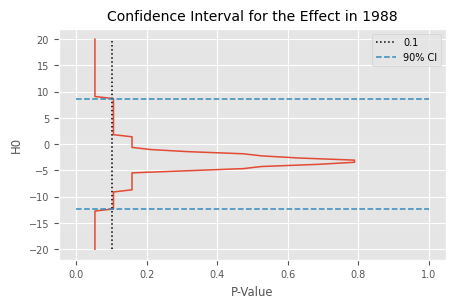

In [79]:
plt.figure(figsize=(5,3))

plt.plot(p_values_df[1988], p_values_df.index)
plt.xlabel("P-Value")
plt.ylabel('H0')
plt.vlines(0.1, nulls.min(), nulls.max(), color="black", ls="dotted", label="0.1")

plt.hlines(confidence_interval_from_p_values(p_values_df)["90_ci_upper"], 0, 1, color="C1", ls="dashed")
plt.hlines(confidence_interval_from_p_values(p_values_df)["90_ci_lower"], 0, 1, color="C1", ls="dashed", label="90% CI")

plt.legend()
plt.title("Confidence Interval for the Effect in 1988");

All there's left to do is repeat the procedure above for each time period. This means that, for each post intervention year, appending it to the end of the pre-intervention period to create the augmented dataset and then computing the confidence interval just like we've done above.


In [80]:
def compute_period_ci(df, state, nulls, intervention_start, period, model, alpha=0.1):
    p_vals = p_val_grid(df=df,
                        state=state,
                        nulls=nulls,
                        intervention_start=intervention_start,
                        period=period,
                        model=model)

    return confidence_interval_from_p_values(p_vals, alpha=alpha)

def confidence_interval(df, state, nulls, intervention_start, window, model, alpha=0.1, jobs=4):
    return pd.concat([compute_period_ci(df, state, nulls, intervention_start, period, model, alpha)
    for period in range(intervention_start, intervention_start+window)])

We are now ready to compute the confidence interval for all the post-intervention periods

In [81]:
model = SyntheticControl()

nulls = np.linspace(-60, 20, 100)

ci_df = confidence_interval(
    data,
    "california",
    nulls=nulls,
    intervention_start=1988,
    window=2000 - 1988 + 1,
    model=model
)

ci_df

,90_ci_lower,90_ci_upper
1988,-12.323232,8.686869
1989,-16.363636,2.222222
1990,-17.171717,5.454545
1991,-19.595960,-5.858586
1992,-22.828283,-7.474747
1993,-32.525253,-12.323232
1994,-36.565657,-15.555556
1995,-43.030303,-14.747475
1996,-41.414141,-16.363636
1997,-48.686869,-13.131313


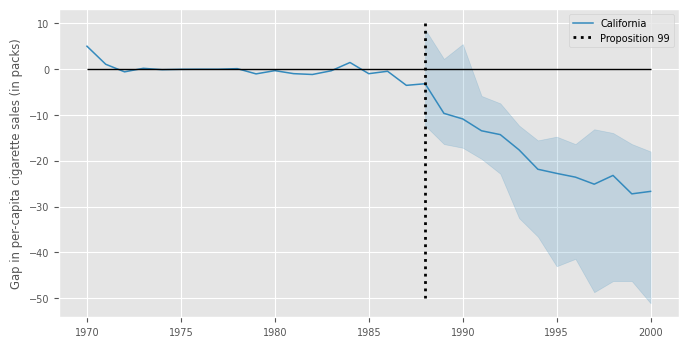

In [85]:
plt.figure(figsize=(8,4))
plt.fill_between(ci_df.index, ci_df["90_ci_lower"], ci_df["90_ci_upper"], alpha=0.2,  color="C1")
plt.plot(pred_data["california"].index, pred_data["residuals"], label="California", color="C1")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=1, color="Black")
plt.vlines(x=1988, ymin=10, ymax=-50, linestyle=":", color="Black", lw=2, label="Proposition 99")
plt.legend()
plt.ylabel("Gap in per-capita cigarette sales (in packs)");